# Modeling Perseveration Behavior in a Two-Step Decision-Making Task Using Reinforcement Learning

### Authors (Group 19):
    - Ibrahim Muhip Tezcan (itezcan@uos.de)
    - Se Eun Choi
    - Andrei Klimenok
    - Mohamad Aljammal
    - Therese Mayr

This Python notebook implements model-free, model-based and hybrid reinforcement learning models to model human behavior in a two-step decision-making task. The task and the hybrid model are from Daw et al. (2011) - "Model-based influences on humans’ choices and striatal prediction errors".



## Model Implementation *(3 points)*

For this exercise you should:

*   Implement and simulate data from two* models that are suitable to test your hypothesis. *(3 points)*

<font size=2>*You may implement more than two models if you wish. However, two models are sufficient for this group project.</font>

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


### 1. Define the Two-Step Task Environment

We first implement an environment to replicate the two-step task. 

In [120]:
import numpy as np
import pandas as pd

In [121]:
class TwoStepEnv:
    action_space = [0, 1]  # 0: Left 1: Right
    state_space = [0, 1, 2]  # 0: First stage, 1: Second stage left, 2: Second stage right

    def __init__(self):
        self.state = 0
        self.transition_prob = 0.7
        self.reward = 1
        self.terminal = False
        self.info = {}

        # Matrix of transition probabilities. Rows represent actions and columns represent states.
        # 0(action left) -> [0(stay in 0), p(go to 1), 1-p(go to 2)]
        # 1(action right) -> [0(stay in 0), 1-p(go to 1), p(go to 2)]
        # Example: [0, 0.7, 0.3] means that if the agent takes action 0, it will stay in state 0 with probability 0, go to state 1 with probability 0.7 and go to state 2 with probability 0.3.
        self.stage_1_transition_matrix = np.array(
            [[0, self.transition_prob, 1 - self.transition_prob],  # action left
             [0, 1 - self.transition_prob, self.transition_prob]])  # action right

        self.min_reward_prob = 0.25
        self.max_reward_prob = 0.75
        # Reward probabilities. Reward is always 0 for stage 1 (state 0). For stage 2, it is random within a range.
        p_1_0 = np.random.uniform(self.min_reward_prob, self.max_reward_prob)
        p_1_1 = np.random.uniform(self.min_reward_prob, self.max_reward_prob)
        p_2_0 = np.random.uniform(self.min_reward_prob, self.max_reward_prob)
        p_2_1 = np.random.uniform(self.min_reward_prob, self.max_reward_prob)

        self.reward_prob_matrix = np.array(
            [[0, 0],  # first stage (state 0) for both actions
             [p_1_0, p_1_1],  # second stage (state 1) for both actions
             [p_2_0, p_2_1]])  # second stage (state 2) for both actions

        # 1 -> fixed reward prob.
        # 0 -> reward prob. can be changed along the trials
        self.fixed_reward_prob_matrix = np.array([[1, 1],
                                                  [0, 0],
                                                  [0, 0]])
        # Distribution of rewards according to the reward probabilities
        self.reward_distribution = np.zeros_like(self.reward_prob_matrix)
        self.update_reward_distribution()
  
    def reset(self):
        """
        Reset the environment to the initial state.
        :return: The initial state.
        """

        self.state = 0
        self.terminal = False
        self.info = {}
        return self.state

    def step(self, action):
        """
        Take a step in the environment with the given action.
        :param action: The action to take.
        :return: The new state, the reward, whether the episode is terminated and additional information.
        """
        if self.terminal:
            raise ValueError("Episode has already terminated")
        if action not in self.action_space:
            raise ValueError(f"The action: {action} is not valid, action space: {self.action_space}")

        # If in stage 1 (state 0)
        if self.state == 0:
            reward = self.reward_function(self.state, action)  # Reward will be 0
            # Transition to the next state according to the transition matrix
            self.state = np.random.choice(self.state_space, p=self.stage_1_transition_matrix[action])

            # Update the info
            self.info["common_transition"] = self.is_common_state(self.state, action)
            self.info["state_transition_to"] = self.state
            self.info["stepOneChoice"] = action

        # If in stage 2 (states 1 or 2)
        elif self.state in [1, 2]:
            reward = self.reward_function(self.state, action)
            self.terminal = True
            # Update the info
            self.info["reward"] = reward > 0
            self.info["stepTwoChoice"] = action
            # [2:] -> take the reward probabilities for the second stage only
            self.info["rewardProbabilities"] = self.reward_prob_matrix.flatten()[2:]
            self.info["rewardDistribution"] = self.reward_distribution.flatten()[2:]

        else:
            raise ValueError(f"state:{self.state} is an invalid state, state space: {self.state_space}")

        return self.state, reward, self.terminal, self.info

    def reward_function(self, state, action):
        """
        Probabilistic calculation of the reward for the given state and action. Always 0 for the first stage.
        :param state: The state
        :param action: The action
        :return: The reward
        """
        if action not in self.action_space:
            raise ValueError(f"The action: {action} is not valid, action space: {self.action_space}")
        if state not in self.state_space:
            raise ValueError(f"state:{state} is an invalid state, state space: {self.state_space}")

        self.update_reward_distribution()
        reward = self.reward_distribution[state][action]
        # Scale the reward for a custom reward value equal to self.reward
        # Makes no difference in case self.reward = 1
        reward = int(reward) * self.reward
        return reward

    def is_common_state(self, state, action):
        """
        Check if the given state is a common state for the given action (0.7 probability) or not (0.3 probability)
        :param state: The state that the action leads to
        :param action: The action
        :return: True if the next state is common for the given action, False otherwise.
        """
        if action not in self.action_space:
            raise ValueError(f"The action: {action} is not valid, action space: {self.action_space}")
        if state not in self.state_space:
            raise ValueError(f"state:{state} is an invalid state, state space: {self.state_space}")

        return self.stage_1_transition_matrix[action, state] == np.max(self.stage_1_transition_matrix[action])

    def update_reward_distribution(self):
        """
        Update the reward distribution according to the reward probabilities.
        """
        self.reward_distribution = np.random.uniform(size=self.reward_prob_matrix.shape) < self.reward_prob_matrix
        self.reward_distribution = self.reward_distribution.astype(float)
        return self.reward_distribution
                
    def set_reward_probabilities(self, reward_prob_matrix):
        """
        Set the reward probabilities to the given matrix
        :param reward_prob_matrix: The reward probability matrix
        :return: The reward probability matrix
        """
        if reward_prob_matrix.shape != self.reward_prob_matrix.shape:
            raise ValueError(
                f"reward_prob_matrix shape: {reward_prob_matrix.shape} is not valid, shape should be {self.reward_prob_matrix.shape}")
        # Clip the reward probabilities to be between min_reward_prob and max_reward_prob
        reward_prob_matrix = np.clip(reward_prob_matrix, self.min_reward_prob,
                                     self.max_reward_prob)

        # Update the reward_prob_matrix
        # if the reward_prob_matrix is fixed -> do not update it, else update it with from the new reward_prob_matrix
        self.reward_prob_matrix = np.where(self.fixed_reward_prob_matrix,
                                           self.reward_prob_matrix, reward_prob_matrix)
        return self.reward_prob_matrix

### 2. Agent implementations

Define the agents (models) that will interact with the environment. We implement the following agents:
- RandomAgent: An agent that takes random actions.
- AgentModelFree: A model-free reinforcement learning agent that uses Q-learning.
- AgentModelBased: A model-based reinforcement learning agent that uses Q-learning and a transition model.
- HybridAgent: A hybrid reinforcement learning agent that uses a combination of model-free and model-based methods.

#### 2.1 Random Agent

The random agent is the simplest agent that just takes random actions. It is used as a baseline to compare the performance of other agents.

In [122]:
class RandomAgent:
    def __init__(self, action_space, state_space):
        self.action_space = action_space
        self.state_space = state_space

    def policy(self, state, method=None):
        return np.random.choice(self.action_space)

    def update_beliefs(self, state, action, reward, next_state, terminal):
        return

    def reset(self):
        return

    def get_action_probabilities(self, state):
        return np.ones(len(self.action_space)) / len(self.action_space)

#### 2.2 Simple Model-Free Agent

The simple model-free agent uses Q-learning to learn the state-action values.

Let's first define the softmax function that will be used by both model-free and model-based agents

In [123]:
def softmax(arr, beta):
    """
    Softmax function for action selection
    :param arr: The array of action values
    :param beta: Inverse temparature parameter for the softmax policy (higher beta -> more deterministic)
    :return: The probabilities of each action, sums up to 1
    """
    e_x = np.exp(beta * (arr - np.max(arr)))  # Subtract max value to prevent overflow
    return e_x / e_x.sum(axis=0)

In [124]:
class AgentModelFree:
    def __init__(self, action_space, state_space, alpha=0.1, beta=1.0, epsilon=0.2, gamma=0.9):
        """
        Initialize the model-free agent.
        :param action_space: The action space
        :param state_space: The state space
        :param alpha: Learning rate
        :param beta: Inverse temparature parameter for the softmax policy (higher beta -> more deterministic)
        :param epsilon: Epsilon for epsilon-greedy policy
        :param gamma: Discount factor
        """
        self.action_space = action_space
        self.state_space = state_space
        self.alpha = alpha
        self.gamma = gamma
        self.beta = beta
        self.epsilon = epsilon
        # Initialize the Q-table
        self.q_table = np.zeros((len(self.state_space), len(self.action_space)))

    def policy(self, state, beta=None, epsilon=None, method="softmax"):
        """
        Choose an action according to the policy
        :param state: The current state
        :param beta: (optional) Inverse temparature parameter for the softmax policy (higher beta -> more deterministic)
        :param epsilon: (optional) Epsilon for epsilon-greedy policy
        :param method: (optional) Method for action selection (softmax or epsilon-greedy)
        :return: The chosen action
        """
        q_values = self.q_table[state, :]
        beta = self.beta if beta is None else beta
        epsilon = self.epsilon if epsilon is None else epsilon
        # calculate the probability of each action in the state with softmax
        if method == "softmax":
            action_probabilities = softmax(q_values, beta)
            action = np.random.choice(self.action_space, p=action_probabilities)

        # epsilon-greedy
        else:
            # random with probability epsilon
            if np.random.uniform() < epsilon:
                action = np.random.choice(self.action_space)
            # max action with probability 1-epsilon
            else:
                action = np.argmax(q_values)

        return action

    def update_q_table_sarsa(self, state, action, reward, next_state, terminal):
        """
        Update the Q-table according to the SARSA algorithm
        :param state: Current state
        :param action: Current action
        :param reward: Reward received
        :param next_state: Where the action has led
        :param terminal: Whether the episode has terminated
        :return: 
        """
        if state not in self.state_space or next_state not in self.state_space:
            raise ValueError(f"state:{state} is an invalid state, state space: {self.state_space}")
        if action not in self.action_space:
            raise ValueError(f"The action: {action} is not valid, action space: {self.action_space}")
        
        self.q_table[state, action] += self.alpha * self.reward_prediction_error(state,
                                                                                 action,
                                                                                 reward,
                                                                                 next_state,
                                                                                 terminal)

        return self.q_table

    def reward_prediction_error(self, state, action, reward, next_state, terminal):
        """
        Calculate the reward prediction error for the given state, action, reward and next state
        :param state: Current state
        :param action: Current action
        :param reward: Reward received
        :param next_state: Where the action has led
        :param terminal: Whether the episode has terminated
        :return: 
        """
        # In the last stage we don't have Q(s', a')
        if terminal:
            return reward - self.q_table[state, action]

        # Take an action according to the policy
        next_action = self.policy(next_state)
         # r + gamma * Q(s', a') - Q(s, a)
        return reward + self.gamma * self.q_table[next_state, next_action] - self.q_table[state, action]
    
    def update_beliefs(self, state, action, reward, next_state, terminal):
        """
        Common function for all agents to update their state-action values
        Here it just calls update_q_table_sarsa
        """
        self.update_q_table_sarsa(state, action, reward, next_state, terminal)

    def get_action_probabilities(self, state):
        """
        Return action probabilities for the given state
        :param state: Current state
        :return: Probability of each action
        """
        q_values = self.q_table[state, :]
        action_probabilities = softmax(q_values, self.beta)
        return action_probabilities

#### 2.3 Simple Model-Based Agent

The simple model-based agent learns transition probabilities and uses it to update the Q-table

In [125]:
class AgentModelBased:
    def __init__(self, action_space, state_space, alpha=0.1, beta=1.0, epsilon=0.2, gamma=0.9):
        """
        Initialize the model-based agent
        :param action_space: The action space
        :param state_space: The state space
        :param alpha: Learning rate
        :param beta: Inverse temparature parameter for the softmax policy (higher beta -> more deterministic)
        :param epsilon: Epsilon for epsilon-greedy policy
        :param gamma: Discount factor
        """
        self.action_space = action_space
        self.state_space = state_space
        self.alpha = alpha
        self.gamma = gamma
        self.beta = beta
        self.epsilon = epsilon
        # Initialize Q-table with zeros
        self.q_table = np.zeros((len(state_space), len(action_space)))

        # Initialize transition model as a 3D numpy array
        # Dimensions: [current_state, action, next_state]
        # For simplicity, initializing all transitions as equally likely
        self.transition_model = np.zeros((len(state_space),
                                          len(action_space),
                                          len(state_space)))
        self.transition_counts = np.zeros((len(state_space),
                                           len(action_space),
                                           len(state_space)))

    def policy(self, state, beta=None, epsilon=None, method="softmax"):
        q_values = self.q_table[state, :]
        beta = self.beta if beta is None else beta
        epsilon = self.epsilon if epsilon is None else epsilon
        # calculate the probability of each action in the state with softmax
        if method == "softmax":
            action_probabilities = softmax(q_values, beta)
            action = np.random.choice(self.action_space, p=action_probabilities)

        # epsilon greedy policy
        else:
            if np.random.uniform() < epsilon:
                action = np.random.choice(self.action_space)
            else:
                action = np.argmax(q_values)

        return action

    def update_transition_model(self, current_state, action, next_state, terminal):
        """
        Simple counting method to update transition probabilities
        :param current_state: 
        :param action: 
        :param next_state: 
        :param terminal: 
        :return: 
        """
        # TODO - Implement more sophisticated methods like Bayesian update ?
        if terminal:
            return
        # update transition model only for stage 1 (state 0) 
        if current_state == 0:
            # Increment the count for the observed transition
            self.transition_counts[current_state, action, next_state] += 1
            # Normalize the transition probabilities for the current state-action pair
            total_transitions = self.transition_counts[current_state, action, :].sum()

            # # high-low update
            P_COMMON = 0.7
            # self.transition_model[current_state, action, 0] = 0
            # what state got visited more sofar
            most_visited_state = self.transition_counts[current_state, action, 1] >= total_transitions / 2  
            most_visited_state = int(most_visited_state)
            self.transition_model[current_state, action, 1:][1-most_visited_state] = P_COMMON
            self.transition_model[current_state, action, 1:][most_visited_state] = 1 - P_COMMON  
        

    def update_q_table(self, state, action, reward, next_state, terminal):
        """
        Update the Q-table using the transition model
        :param state: 
        :param action: 
        :param reward: 
        :param next_state: 
        :param terminal: 
        :return: 
        """
        if terminal:  # -> second stage -> update with TD
            self.q_table[state, action] += self.alpha * self.reward_prediction_error(
                state, action, reward, next_state, terminal)

        else:  # -> first stage -> update with transition model following the Bellman equation
            # iterate over all possible states
            # we can do that since the transition model will regulate which states
            # will be considered for the update
            # -> transition probabilities are 0 for states that are not possible
            # initialize the sum for the Q-table update
            q_value_sum = 0
            for possible_state in self.state_space:
                # a list to hold Q-values for all actions from the possible state
                q_values = []
                # iterate over all possible actions in the next state
                for next_action in self.action_space:
                    # get the reward prediction error for the next state
                    next_terminal = possible_state in [1, 2]
                    reward_pred_error = self.reward_prediction_error(state, next_action, reward, next_state, next_terminal)
                    # Q-value for this action in the possible state
                    q_value = self.q_table[possible_state, next_action] + self.alpha * reward_pred_error
                    q_values.append(q_value)
                
                # take the maximum Q-value among all actions for the possible state
                max_q_value = np.max(q_values)
                # scale the max Q-value by the transition probability from current state-action pair to the possible state
                weighted_q_value = self.transition_model[state, action, possible_state] * max_q_value
                # add the weighted Q-value to the sum
                q_value_sum += weighted_q_value

            # update the Q-table entry for the state-action pair 
            self.q_table[state, action] = q_value_sum

    def reward_prediction_error(self, state, action, reward, next_state, terminal):
        """
        Calculate the reward prediction error for the given state, action, reward and next state
        :param state: 
        :param action: 
        :param reward: 
        :param next_state: 
        :param terminal: 
        :return: 
        """
        # In the last stage we don't have Q(s', a')
        if terminal:
            return reward - self.q_table[state, action]

        next_action = self.policy(next_state)
        # r + gamma * Q(s', a') - Q(s, a)
        return reward + self.gamma * self.q_table[next_state, next_action] - self.q_table[state, action]

    def update_beliefs(self, state, action, reward, next_state, terminal):
        # First update the transition model, then update the Q-table
        self.update_transition_model(state, action, next_state, terminal)
        self.update_q_table(state, action, reward, next_state, terminal)

    def get_action_probabilities(self, state):
        """
        Return action probabilities for the given state
        :param state: Current state
        :return: Probability of each action
        """
        q_values = self.q_table[state, :]
        action_probabilities = softmax(q_values, self.beta)
        return action_probabilities

#### 2.4 Hybrid Agent

The hybrid agent uses a combination of model-free and model-based methods to update the Q-table, controlled by the parameter w.
For special case of w = 1 it acts as a model-based agent. If w = 0, it acts as a model-free agent. For 0 < w < 1, it is a hybrid agent.
The implementation is based on Daw et al. (2011) - "Model-based influences on humans’ choices and striatal prediction errors".

In [126]:
class HybridAgent:
    def __init__(self, action_space, state_space, alpha_1=0.1, alpha_2=0.1, beta_1=1.0, beta_2=1.0, _lambda=0.5,
                 w=0.5, p=0):
        """
        Initialize hybrid agent
        :param action_space: Action space of the environment
        :param state_space: State space of the environment
        :param alpha_1: Learning rate for first step
        :param alpha_2: Learning rate for second step
        :param beta_1: Inverse temperature parameter for softmax policy for first step
        :param beta_2: Inverse temperature parameter for softmax policy for second step
        :param w: Weight of model-based values (0 for model-free, 1 for model-based)
        """
        self.action_space = action_space
        self.state_space = state_space
        self.alpha_1 = alpha_1
        self.alpha_2 = alpha_2
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self._lambda = _lambda
        self.w = w
        self.p = p

        # Initialize Q-tables for model-free, model-based and hybrid
        self.q_td = np.zeros((len(state_space), len(action_space)))  # Q-table for model-free
        self.q_mb = np.zeros((len(state_space), len(action_space)))  # Q-table for model-based
        self.q_net = np.zeros((len(state_space), len(action_space)))  # Q-table for hybrid
        self.q_table = self.q_net  # For compatibility with other agents

        # Initialize transition model as a 3D numpy array
        # Dimensions: [current_state, action, next_state]
        # For simplicity, initializing all transitions as equally likely
        self.transition_model = np.zeros((len(state_space), len(action_space), len(state_space)))
        self.transition_counts = np.zeros((len(state_space), len(action_space), len(state_space)))

        self.eligibility_traces = np.zeros((len(state_space), len(action_space)))

        self.previous_action = None

    def calculate_rpe(self, state, action, reward, next_state, next_action, terminal):
        """
        Calculate the reward prediction error
        :param state: current state
        :param action: current action
        :param reward: reward received in the current state
        :param next_state: next state
        :param next_action: next action
        :param terminal: whether this state is terminal
        :return:
        """
        if terminal:
            return reward - self.q_td[state, action]
        else:
            return reward + self.q_td[next_state, next_action] - self.q_td[state, action]

    def update_q_td(self, rpe):
        """
        Update the Q-table for model-free agent. Use eligibility traces for the update.
        :param state: Current state
        :param action: Current action
        :param rpe: Reward prediction error
        :return:
        """
        # On stage 1, trace is 1 for the current state-action and 0 for others
        # On stage 2, trace is 1 for the current state-action and lambda for the previous state-action pair (since it is decayed)
        for s in range(len(self.state_space)):
            for a in range(len(self.action_space)):
                alpha = self.alpha_1 if s == 0 else self.alpha_2
                self.q_td[s, a] += alpha * rpe * self.eligibility_traces[s, a]

    def update_transition_model(self, current_state, action, next_state, terminal):
        """
        Update the transition model. Simply count the transitions and set 0.7 for the more visited state and 0.3 for the other state.
        :param current_state: 
        :param action: 
        :param next_state: 
        :param terminal: 
        :return: 
        """
        # There is no transition if the state is terminal
        if terminal:
            return

        # Increment the count for the observed transition
        self.transition_counts[current_state, action, next_state] += 1

        # Check if the transition is common or rare
        is_common_transition = self.transition_counts[current_state, action, next_state] == np.max(
            self.transition_counts[current_state, action])
        # Update the transition probabilities
        self.transition_model[current_state, action, next_state] = 0.7 if is_common_transition else 0.3
        other_states = np.array([state for state in self.state_space[1:] if state != next_state])
        for other_state in other_states:
            self.transition_model[current_state, action, other_state] = 0.3 if is_common_transition else 0.7

    def update_q_mb(self):
        """
        Update MB table for all state-action pairs so that first stage considers updated TD values
        :return: 
        """
        for state in self.state_space:
            for action in self.action_space:
                if state == 0:
                    self.q_mb[state, action] = np.sum(
                        [self.transition_model[state, action, i] * np.max(self.q_td[i, :]) for i in
                         self.state_space[1:]])
                else:
                    # For stage 2, MB values are the same as TD values (Daw et al., 2011)
                    self.q_mb[state, action] = self.q_td[state, action]

    def update_q_net(self):
        """
        Update hybrid table for all state-action pairs so that first stage considers updated TD values
        :return: 
        """
        for state in self.state_space:
            for action in self.action_space:
                if state == 0:
                    self.q_net[state, action] = self.w * self.q_mb[state, action] + (1 - self.w) * self.q_td[state, action]
                else:
                    # For stage 2, hybrid values are the same as TD values (Daw et al., 2011)
                    self.q_net[state, action] = self.q_td[state, action]

    def update_beliefs(self, current_state, action, reward, next_state, terminal):
        # Decay all eligibility traces. This effectively sets trace for previous stage to lambda, if it's stage 2
        self.eligibility_traces *= self._lambda
        # Set eligibility trace = 1 for the current state-action pair
        self.eligibility_traces[current_state, action] = 1

        next_action = self.policy(next_state)
        rpe = self.calculate_rpe(current_state, action, reward, next_state, next_action, terminal)
        self.update_q_td(rpe)
        self.update_transition_model(current_state, action, next_state, terminal)
        self.update_q_mb()
        self.update_q_net()

        if terminal:
            # Clear all eligibility traces at the end of the episode
            self.eligibility_traces = np.zeros((len(self.state_space), len(self.action_space)))
        else:
            self.previous_action = action

    def get_action_probabilities(self, state):
        beta = self.beta_1 if state == 0 else self.beta_2
        # Calculate the rep(a) based on the current state and previous action (see: Daw et al., 2011)
        rep_a = np.zeros_like(self.q_net[state, :])
        if state == 0 and self.previous_action is not None:
            rep_a[self.previous_action] = 1
        return self.softmax(self.q_net[state, :], beta, self.p, rep_a)

    def policy(self, state, method=None):
        return np.random.choice(self.action_space, p=self.get_action_probabilities(state))

    def softmax(self, q_values, beta, p, rep_a):
        """
        Modified softmax function for the hybrid agent based on Daw et al. (2011)
        :param q_values: Q-values
        :param beta: Inverse temperature parameter
        :param p: Perseveration parameter
        :param rep_a: Repetition component. Should be a one-hot vector with 1 at the previous action (if first stage)
        :return: 
        """
        adjusted_q_values = (q_values + p * rep_a - np.max(q_values))
        # Calculate the exponentiated weighted Q values with the repetition component
        exp_values = np.exp(beta * adjusted_q_values)

        # Ensure no division by zero and no 0 probabilities
        exp_values += 1e-8
        exp_values_sum = np.sum(exp_values, axis=0)

        # Compute the softmax probabilities
        probabilities = exp_values / exp_values.sum(axis=0)

        return probabilities

### 3. Simulating Data Using the Environment and Agents

Here we define funcntions to simulate data from the two-step task. We will run it below and save its output.

#### 3.1 Code for simulation

In [127]:
def random_walk_gaussian(prob, sd, min_prob=0, max_prob=1):
    """
    Simulate a random walk in the reward probabilities using Gaussian noise
    :param prob: initial reward probabilities
    :param sd: standard deviation of the noise
    :param min_prob: minimum range
    :param max_prob: maximum range
    :return: new reward probabilities with added noise
    """
    new_prob = prob + np.random.normal(scale=sd, size=np.shape(prob))
    new_prob = np.clip(new_prob, min_prob, max_prob)
    return new_prob

def simulate(agent_type='random', trials=200, seed=None, verbose=False, params:dict={}, from_data:pd.DataFrame=None, use_reward_distribution=True):
    """
    Simulate the two-step task using the environment and the given agent
    :param agent_type: ['random', 'model_free', 'model_based', 'hybrid']
    :param trials: number of trials to simulate
    :param seed: random seed
    :param verbose: print details if True
    :param params: parameters for the agent
    :param from_data: use reward probabilities from the given data
    :param use_reward_distribution: use reward distribution if True
    :return: simulated task data as a dataframe and the agent
    """
    if verbose:
        print(f"Simulating {agent_type} agent, {trials} trials.")
        print(f"Agent parameters: {params if params else 'default'}")
    # set a random seed
    np.random.seed(seed)

    # simulate the task
    action_space = TwoStepEnv.action_space
    state_space = TwoStepEnv.state_space

    if agent_type == 'model_based':
        agent = AgentModelBased(action_space, state_space, **params)
    elif agent_type == 'model_free':
        agent = AgentModelFree(action_space, state_space, **params)
    elif agent_type == 'hybrid' or agent_type.startswith('hybrid'):
        agent = HybridAgent(action_space, state_space, **params)
    else:
        agent = RandomAgent(action_space, state_space)
    env = TwoStepEnv()
    task_data = simulate_two_step_task(env, agent, trials=trials, from_data=from_data, use_reward_distribution=use_reward_distribution)

    # convert the data to a dataframe
    task_df = pd.DataFrame.from_dict(task_data, orient='index')

    # unset the random seed
    np.random.seed(None)
    return task_df, agent

def simulate_two_step_task(env: TwoStepEnv, agent=None, trials=200, policy_method="softmax", from_data:pd.DataFrame=None, use_reward_distribution=True):
    """
    Simulate with given agent
    :param env: environment
    :param agent: given agent
    :param trials: number of trials
    :param policy_method: method for action selection ['softmax', 'epsilon-greedy']
    :param from_data: use reward probabilities from the given data
    :param use_reward_distribution: use reward distribution if True
    :return: simulated task data
    """
    env.reset()
    if from_data is not None:
        if use_reward_distribution:
            reward_distribution = from_data['rewardDistribution'].iloc[0]
            # convert the reward distribution to float
            reward_probabilities = reward_distribution.astype(float)
        else:
            reward_probabilities = from_data['rewardProbabilities'].iloc[0]
        # reshape the reward probabilities to the correct shape, with zeros for the first stage
        reward_probabilities = np.array([0, 0, *reward_probabilities])
        # reshape
        reward_probabilities = reward_probabilities.reshape((3, 2))
        env.set_reward_probabilities(reward_probabilities)

    task_data = {}

    sd_for_random_walk = 0.025
    time_step = 0
    while time_step < trials:
        # first stage choice
        terminal = False
        while not terminal:
            current_state = env.state
            if agent:
                action = agent.policy(env.state, method=policy_method)
            else:  # if no agent is given -> random action
                action = np.random.choice(env.action_space)

            next_state, reward, terminal, info = env.step(action)

            if agent:
                agent.update_beliefs(current_state, action, reward, next_state,
                                     terminal)

        info['trial_index'] = int(time_step)
        task_data[time_step] = info
        env.reset()
        # update the reward probabilities for the next trial
        # 3 cases:
        # 1. free simulation -> simulate a random walk in the reward probabilities
        # 2. simulate according to the reward probabilities from data and sample reward distribution in the environment 
        #                                                            -> use the same reward probabilities as the data
        # 3. simulate according to the reward distribution from data -> use the same reward distribution as the data
        if from_data is not None and time_step < trials - 1:
            if use_reward_distribution:
                reward_distribution = from_data['rewardDistribution'].iloc[time_step + 1]
                # convert the reward distribution to float
                new_reward_prob_matrix = reward_distribution.astype(float)
            else:
                new_reward_prob_matrix = from_data['rewardProbabilities'].iloc[time_step + 1]
            # include zeros for the first stage
            new_reward_prob_matrix = np.array([0, 0, *new_reward_prob_matrix])
            # reshape to the epxpected shape (3, 2): state-action
            new_reward_prob_matrix = new_reward_prob_matrix.reshape((3, 2))
        else:
            # simulate a random walk in the reward probabilities
            new_reward_prob_matrix = random_walk_gaussian(env.reward_prob_matrix,
                                                      sd_for_random_walk)
        env.set_reward_probabilities(new_reward_prob_matrix)
        time_step += 1

    return task_data

#### 3.2 Run Simulation with Default Parameters

In [128]:
seed = 0
task_df_mf, agent_mf= simulate(agent_type='model_free', seed=seed)
task_df_mb, agent_mb= simulate(agent_type='model_based', seed=seed)
task_df_hybrid, agent_hybrid= simulate(agent_type='hybrid', seed=seed)
task_df_hybrid_mf, agent_hybrid_mf= simulate(agent_type='hybrid', seed=seed, params={'w':0.0}) # special case of pure model-free from hybrid
task_df_hybrid_mb, agent_hybrid_mb= simulate(agent_type='hybrid', seed=seed, params={'w':1.0}) # special case of pure model-based from hybrid

In [129]:
import os
from datetime import datetime

def save_simulated_data(task_df: pd.DataFrame, agent_type: str):
    """
    Save the simulated data to a csv file
    :param task_df: data as a dataframe
    :param agent_type: ['model_free', 'model_based', 'hybrid'] (used in path)
    :return: 
    """
    # save the data to a csv file
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    file_path = os.path.join("data", "simulated", agent_type, timestamp)
    # Create folder if it does not exist
    os.makedirs(file_path, exist_ok=True)
    filename = os.path.join(file_path, "simulated_data.csv")
    task_df.to_csv(filename, index=False)
    print("Data saved to", filename)

save_simulated_data(task_df_mf, agent_type='model_free')
save_simulated_data(task_df_mb, agent_type='model_based')
save_simulated_data(task_df_hybrid, agent_type='hybrid')
save_simulated_data(task_df_hybrid_mf, agent_type='hybrid_mf')
save_simulated_data(task_df_hybrid_mb, agent_type='hybrid_mb')

Data saved to data/simulated/model_free/20240228-233145/simulated_data.csv
Data saved to data/simulated/model_based/20240228-233145/simulated_data.csv
Data saved to data/simulated/hybrid/20240228-233145/simulated_data.csv
Data saved to data/simulated/hybrid_mf/20240228-233145/simulated_data.csv
Data saved to data/simulated/hybrid_mb/20240228-233145/simulated_data.csv


#### 3.3. Analysis of Simulated Data

Define functions for analyzing simulated data and use them to print some summary statistics and plots.

In [130]:
def print_simple_task_summary(data: pd.DataFrame, title="", full=False):
    """
    Print some simple statistics about the data
    :param data: 
    :param title: 
    :param full: print full statistics if True
    :return: 
    """
    # print some statistics 
    # print_simple_statistics(task_df)
    task_df = data.copy()
    print("###", title)

    print("common transitions percentage:", np.mean(task_df["common_transition"])*100, "%")
    print("rewarded trails percentage:", np.mean(task_df["reward"] > 0)*100, "%")

    if full:
        print("transition percentage from state 0 action 0 to state 1:", np.mean(task_df[task_df["stepOneChoice"] == 0]["state_transition_to"] == 1)*100, "%")
        print("transition percentage from state 0 action 1 to state 2:", np.mean(task_df[task_df["stepOneChoice"] == 1]["state_transition_to"] == 2)*100, "%")
        # get the counts of state transitions and action in stage 1
        counts_stage_2_action_1 = pd.DataFrame({
            'State Counts': task_df['state_transition_to'].value_counts(),
            'Action Stage 1 Counts': task_df['stepOneChoice'].value_counts()
        })
        display(counts_stage_2_action_1)

        mean_reward = task_df.groupby('state_transition_to')['reward'].mean().reset_index()
        mean_reward.columns = ['state_transition_to', 'mean_reward']
        display(mean_reward)

        # get the reward probability distributions for the final stage (2)
        def index_reward_probabilities(row):
            try:
                return row['rewardProbabilities'][row['state_transition_to'] + row['stepTwoChoice']]
            except:
                print(row)

        task_df_tmp = task_df.copy()
        task_df_tmp['mean_reward_prob_stepTwoChoice'] = task_df.apply(index_reward_probabilities, axis=1)
        reward_probabilities = task_df_tmp.groupby(['state_transition_to', 'stepTwoChoice'])['mean_reward_prob_stepTwoChoice'].mean().reset_index()
        display(reward_probabilities)

In [131]:
# print q table and transition matrix
print("q_table model based:\n", agent_mb.q_table)
print("q_table hybrid:\n", agent_hybrid.q_table)
print("q_table hybrid mf:\n", agent_hybrid_mf.q_table)
print("q_table hybrid mb:\n", agent_hybrid_mb.q_table)

if hasattr(agent_mb, 'transition_model'):
    print("transition_matrix model based:\n", agent_mb.transition_model[0])
if hasattr(agent_hybrid, 'transition_model'):
    print("transition_matrix hybrid:\n", agent_hybrid.transition_model[0])
if hasattr(agent_hybrid_mf, 'transition_model'):
    print("transition_matrix hybrid mf:\n", agent_hybrid_mf.transition_model[0], 'NOT USED IN BELIEF UPDATE!')
if hasattr(agent_hybrid_mb, 'transition_model'):
    print("transition_matrix hybrid mb:\n", agent_hybrid_mb.transition_model[0])

# print some summary statistics about the task
full = False
print_simple_task_summary(task_df_mf, title='model_free', full=full)
print_simple_task_summary(task_df_mb, title='model_based', full=full)
print_simple_task_summary(task_df_hybrid, title='hybrid', full=full)
print_simple_task_summary(task_df_hybrid_mf, title='hybrid_mf', full=full)
print_simple_task_summary(task_df_hybrid_mb, title='hybrid_mb', full=full)

q_table model based:
 [[0.51209287 0.46954224]
 [0.64127226 0.57287122]
 [0.46909978 0.48409035]]
q_table hybrid:
 [[0.64792575 0.61331761]
 [0.62589829 0.5813574 ]
 [0.64796417 0.54779762]]
q_table hybrid mf:
 [[0.66941918 0.58012492]
 [0.62589829 0.5813574 ]
 [0.64796417 0.54779762]]
q_table hybrid mb:
 [[0.63251806 0.64134441]
 [0.62589829 0.5813574 ]
 [0.64796417 0.54779762]]
transition_matrix model based:
 [[0.  0.7 0.3]
 [0.  0.3 0.7]]
transition_matrix hybrid:
 [[0.  0.7 0.3]
 [0.  0.3 0.7]]
transition_matrix hybrid mf:
 [[0.  0.7 0.3]
 [0.  0.3 0.7]] NOT USED IN BELIEF UPDATE!
transition_matrix hybrid mb:
 [[0.  0.7 0.3]
 [0.  0.3 0.7]]
### model_free
common transitions percentage: 69.0 %
rewarded trails percentage: 56.00000000000001 %
### model_based
common transitions percentage: 74.0 %
rewarded trails percentage: 50.5 %
### hybrid
common transitions percentage: 74.5 %
rewarded trails percentage: 52.5 %
### hybrid_mf
common transitions percentage: 75.5 %
rewarded trails perce

In [132]:
# Collect the dataframes for the analysis
task_dfs = [task_df_mf, task_df_mb, task_df_hybrid, task_df_hybrid_mf, task_df_hybrid_mb]
model_names = ['model_free', 'model_based', 'hybrid', 'hybrid_mf', 'hybrid_mb']

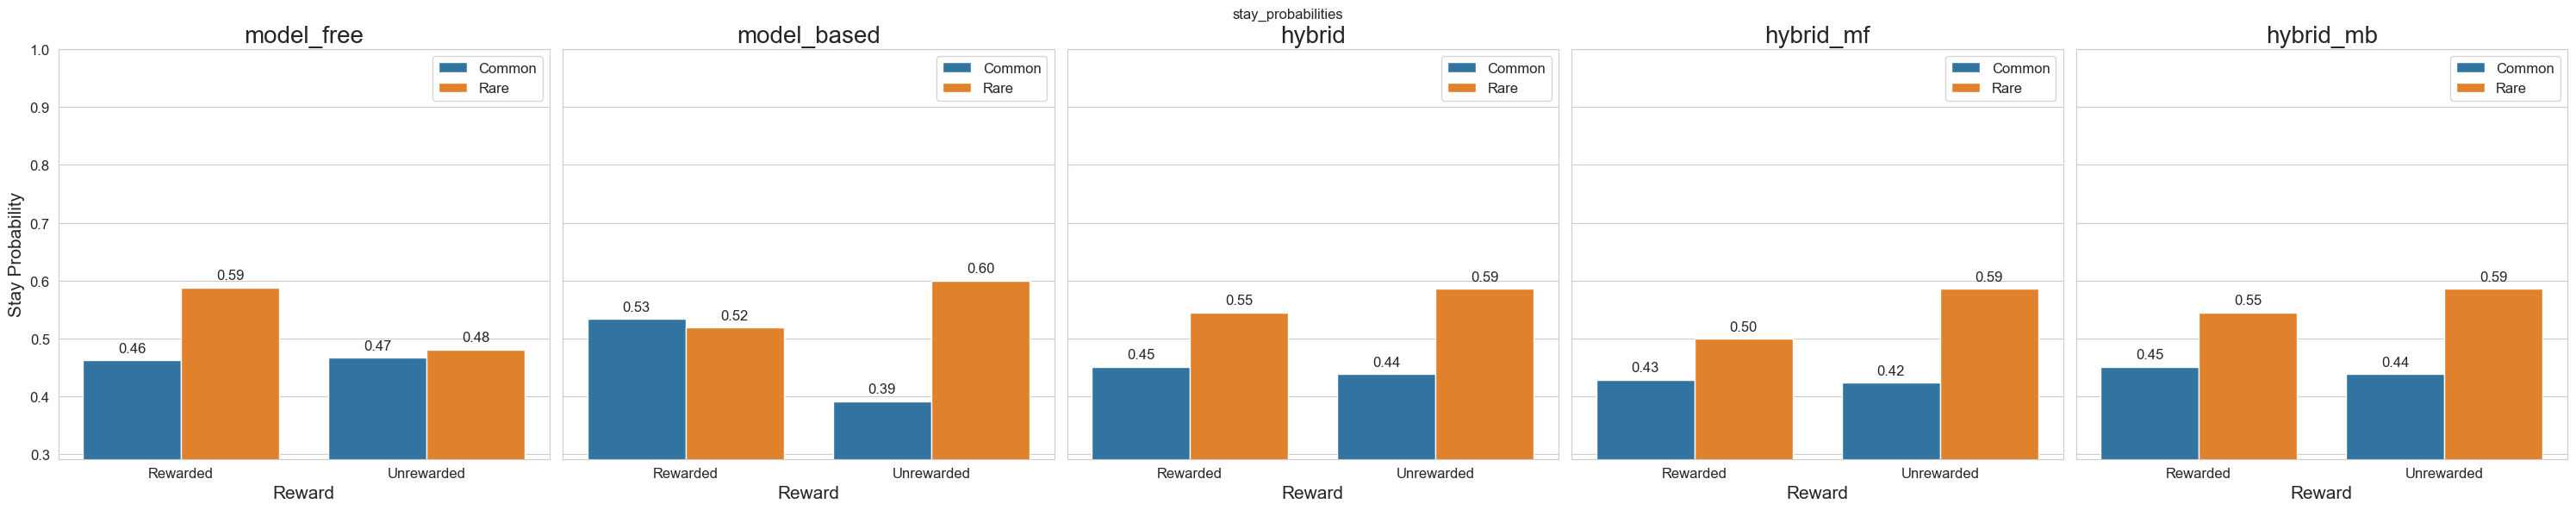

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from tqdm.notebook import tqdm

def calculate_repeated_action(data: pd.DataFrame) -> pd.DataFrame:
    # get a copy of the data
    tmp_df = data.copy()

    # flag for the repeated action (stage 1), same action as the previous trial
    tmp_df['repeated_stepOneAction'] = tmp_df['stepOneChoice'].shift(1) == tmp_df['stepOneChoice']
    
    # flag for the repeated action (stage 1), same action as the next trial (to calculate the stay probability)
    tmp_df['repeated_stepOneAction_next'] = tmp_df['repeated_stepOneAction'].shift(-1)
    
    # discard last trial (no next trial to compare with)
    tmp_df = tmp_df.iloc[:-1]

    return tmp_df

def calculate_stay_probability(data: pd.DataFrame) -> pd.DataFrame:
    # get a copy of the data
    tmp_df = data.copy()
    tmp_df = calculate_repeated_action(tmp_df)

    # stay probabilities based on conditions
    # 2 factors:
    #       rewarded trail ( whether the reward in stage 2 is greater than )
    #       common_transition ( whether the transition from stage 1 to stage 2 is common or rare)
    results = tmp_df.groupby(['reward', 'common_transition'])[
        'repeated_stepOneAction_next'].mean().reset_index()

    # rename columns for clarity
    results.rename(
        columns={'repeated_stepOneAction_next': 'Stay Probability', 'reward': 'Rewarded',
                 'common_transition': 'Common'}, inplace=True)

    conditions = {
        (True, True): 'rewarded_common',
        (True, False): 'rewarded_rare',
        (False, True): 'unrewarded_common',
        (False, False): 'unrewarded_rare'
    }
    results['Condition'] = results.apply(
        lambda row: conditions[(row['Rewarded'], row['Common'])], axis=1)

    # rounding the stay probabilities
    results['Stay Probability'] = results['Stay Probability'].apply(
        lambda x: np.round(x, 3))

    return results

def plot_stay_probabilities(dfs: list[pd.DataFrame], labels: list[str]=None, title='', max_plots_per_row=4, save=False, filename="plots/stay_probabilities.png"):
    sns.set_style("whitegrid")
    
    if isinstance(dfs, pd.DataFrame) or not isinstance(dfs, list):
        dfs = [dfs]  # Wrap the single DataFrame in a list
    
    if labels is not None and not isinstance(labels, list):
        labels = [labels]

    n_plots = len(dfs)
    # Calculate the number of rows and columns for the subplot grid
    rows = (n_plots - 1) // max_plots_per_row + 1  # Ensure at least one row
    cols = min(n_plots, max_plots_per_row)  # Max of 4 columns
    
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(6*cols, 6*rows), sharey=True, sharex=True)
    
    # If there's only one subplot, axes won't be an array, so we wrap it in a list for consistency
    if n_plots == 1:
        axes = [axes]
    else:
        # Flatten the axes array to simplify indexing
        axes = axes.flatten()

    fig.suptitle(title)

    if labels is None:
        labels = [f"Plot {i}" for i in range(len(dfs))]
    if len(labels) < len(dfs):
        labels = labels + [f"Plot {i}" for i in range(len(dfs) - len(labels))]
    
    min_stay_prob = np.min([data['Stay Probability'].min() for data in dfs])
    y_limit_min = 0.5 if min_stay_prob > 0.5 else min_stay_prob - 0.1

    for i, data in enumerate(dfs):
        ax = axes[i]
        df = data.copy()
        # Convert 'Rewarded' to a string type for clear plotting
        df['Rewarded'] = df['Rewarded'].map({True: 'Rewarded', False: 'Unrewarded'})
        df['Common'] = df['Common'].map({True: 'Common', False: 'Rare'})
        # Create the bar plot
        bar = sns.barplot(x='Rewarded', y='Stay Probability', hue='Common',
                        data=df, ax=ax,
                        order=['Rewarded', 'Unrewarded'],
                        hue_order=['Common', 'Rare'])

        # Set the y-axis limit
        ax.set_ylim(y_limit_min, 1)

        ax.set_title(labels[i], fontsize=20)

        # Set the size of the legend and the title of the legend
        ax.legend(title_fontsize='13', fontsize='12')

        # Set the size of the x and y ticks labels
        ax.tick_params(labelsize=12)

        # Add percentages on top of each bar
        for p in bar.patches:
            bar.annotate(format(p.get_height(), '.2f'),
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center',
                        xytext=(0, 10),
                        textcoords='offset points', fontsize=12)
            
        if i >= (n_plots - max_plots_per_row):
            ax.set_xlabel('Reward', fontsize=15)
        else:
            # Hide the x-axis label
            ax.set_xlabel('', visible=False)
        if i%max_plots_per_row == 0:
            ax.set_ylabel('Stay Probability', fontsize=15)
        else:
            # Hide the y-axis label
            ax.set_ylabel('', visible=False)

    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    plt.show()
    if save:
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        # add timestamp to filename
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = filename.replace('.png', f'_{timestamp}.png')
        fig.savefig(filename)
        print(f'Plot saved to {filename}')

def calc_plot_stay_probabilities(dfs: list[pd.DataFrame], labels: list[str]=None, title='', plot=True, return_df=True, max_plots_per_row=4, save=False, filename="plots/stay_probabilities.png"):
    """
    Calculate and plot the stay probabilities for the given dataframes
    :param dfs: List of dataframes
    :param labels: Labels for the dataframes
    :param title: Title for the plot
    :param plot: Plot the data if True
    :param return_df: Return the dataframes if True
    :param max_plots_per_row: Maximum number of plots per row
    :param save: Save the plot if True
    :param filename: Filename for the plot (if save=True)
    :return: 
    """
    if isinstance(dfs, pd.DataFrame) or not isinstance(dfs, list):
        dfs = [dfs]
    # calculate stay probabilities
    stay_probabilities = [calculate_stay_probability(df) for df in dfs]
    # plot the stay probabilities
    if not labels or len(labels) != len(dfs):
        print("Labels not provided or not matching the number of dataframes, using default labels")
        labels = [f"data {i+1}" for i in range(len(dfs))]
        print('generated labels:', labels)
    if plot:
        plot_stay_probabilities(dfs=stay_probabilities, labels=labels, title=title, max_plots_per_row=max_plots_per_row, save=save, filename=filename)
    stay_probabilities = dict(zip(labels, stay_probabilities))
    if return_df:
        return stay_probabilities

# Plot stay probabilities
stay_probabilities = calc_plot_stay_probabilities(dfs=task_dfs, labels=model_names, title='stay_probabilities', max_plots_per_row=5)

In [134]:
def calculate_running_stay_probabilities(data):
    task_df = data.copy()
    # Initialize columns for stay decisions and running probabilities
    task_df['stay_decision'] = False
    task_df['common_rewarded_prob'] = 0.0
    task_df['common_unrewarded_prob'] = 0.0
    task_df['rare_rewarded_prob'] = 0.0
    task_df['rare_unrewarded_prob'] = 0.0

    # Trackers for calculating running probabilities
    stay_counts = {'common_rewarded': 0, 'common_unrewarded': 0, 'rare_rewarded': 0, 'rare_unrewarded': 0}
    total_counts = {'common_rewarded': 0, 'common_unrewarded': 0, 'rare_rewarded': 0, 'rare_unrewarded': 0}

    task_df = calculate_repeated_action(task_df)

    for i in range(0, len(task_df)):
        current = task_df.iloc[i]
        # prev = task_df.iloc[i-1]

        # # Check if the participant stayed with the same choice
        # if current['stepOneChoice'] == prev['stepOneChoice']:
        if current['repeated_stepOneAction_next']:
            task_df.loc[i, 'stay_decision'] = True

        condition = ('common_' if current['common_transition'] else 'rare_') + ('rewarded' if current['reward'] else 'unrewarded')

        # Update counts
        if task_df.loc[i, 'stay_decision']:
            stay_counts[condition] += 1
        total_counts[condition] += 1

        # Calculate running probabilities
        for key in stay_counts:
            if total_counts[key] > 0:
                task_df.loc[i, key + '_prob'] = stay_counts[key] / total_counts[key]
        
    # rename columns for consistency
    task_df.rename(columns={'common_rewarded_prob': 'rewarded_common', 'common_unrewarded_prob': 'unrewarded_common',
                            'rare_rewarded_prob': 'rewarded_rare', 'rare_unrewarded_prob': 'unrewarded_rare'}, inplace=True)

    return task_df

def plot_running_stay_probabilities(task_dfs:list, labels:list=None,window_size=1, max_plots_per_row=3, title='', save=False, filename="plots/running_step_probabilities.png"):
    
    if isinstance(task_dfs, pd.DataFrame) or not isinstance(task_dfs, list):
        task_dfs = [task_dfs]
    if labels is not None and not isinstance(labels, list):
        labels = [labels]

    # Create a copy of the DataFrame to avoid modifying the original
    n_plots = len(task_dfs)
    # Calculate the number of rows and columns for the subplot grid
    rows = (n_plots - 1) // max_plots_per_row + 1  # Ensure at least one row
    cols = min(n_plots, max_plots_per_row)  # Max of 4 columns
    
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(6*cols, 6*rows), sharey=True, sharex=True)
    
    # If there's only one subplot, axes won't be an array, so we wrap it in a list for consistency
    if n_plots == 1:
        axes = [axes]
    else:
        # Flatten the axes array to simplify indexing
        axes = axes.flatten()

    fig.suptitle(title)

    if labels is None:
        labels = [f"Plot {i}" for i in range(len(task_dfs))]
    if len(labels) < len(task_dfs):
        labels = labels + [f"Plot {i}" for i in range(len(task_dfs) - len(labels))]
    
    for i, data in enumerate(task_dfs):
        ax = axes[i]
        df_copy = data.copy()

        # Calculate moving averages on the copy
        df_copy['common_rewarded_prob_ma'] = df_copy['rewarded_common'].rolling(window=window_size, min_periods=1).mean()
        df_copy['rare_rewarded_prob_ma'] = df_copy['rewarded_rare'].rolling(window=window_size, min_periods=1).mean()
        df_copy['common_unrewarded_prob_ma'] = df_copy['unrewarded_common'].rolling(window=window_size, min_periods=1).mean()
        df_copy['rare_unrewarded_prob_ma'] = df_copy['unrewarded_rare'].rolling(window=window_size, min_periods=1).mean()

        # Plot each condition's moving average from the copied DataFrame
        ax.plot(df_copy['trial_index'], df_copy['common_rewarded_prob_ma'], label='Rewarded Common (MA)', linestyle='-', color='b')
        ax.plot(df_copy['trial_index'], df_copy['rare_rewarded_prob_ma'], label='Rewarded Rare (MA)', linestyle='-', color='orange')
        ax.plot(df_copy['trial_index'], df_copy['common_unrewarded_prob_ma'], label='Unrewarded Common (MA)', linestyle='--', color='b')
        ax.plot(df_copy['trial_index'], df_copy['rare_unrewarded_prob_ma'], label='Unrewarded Rare (MA)', linestyle='--', color='orange')

        ax.set_title(labels[i])
        ax.legend()
        ax.grid(True)

        if i >= (n_plots - max_plots_per_row):
            ax.set_xlabel('Trial Index', fontsize=15)
        else:
            # Hide the x-axis label
            ax.set_xlabel('', visible=False)
        if i%max_plots_per_row == 0:
            ax.set_ylabel('Running Stay Probability (MA)', fontsize=15)
        else:
            # Hide the y-axis label
            ax.set_ylabel('', visible=False)

    plt.show()
    if save:
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        # add timestamp to filename
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = filename.replace('.png', f'_{timestamp}.png')
        fig.savefig(filename)
        print(f'Plot saved to {filename}')

def calc_plot_running_stay_probabilities(dfs: list[pd.DataFrame], labels: list[str]=None, title='', window_size=50, plot=True, return_df=True, max_plots_per_row=4, save=False, filename="plots/running_stay_probabilities.png"):
    if isinstance(dfs, pd.DataFrame) or not isinstance(dfs, list):
        dfs = [dfs]
    # calculate stay probabilities
    running_stay_probabilities = [calculate_running_stay_probabilities(df) for df in dfs]
    # plot the stay probabilities
    if plot:
        plot_running_stay_probabilities(running_stay_probabilities, labels=labels, title=title, window_size=window_size,
                                        max_plots_per_row=max_plots_per_row, save=save, filename=filename)
    if return_df:        
        return running_stay_probabilities

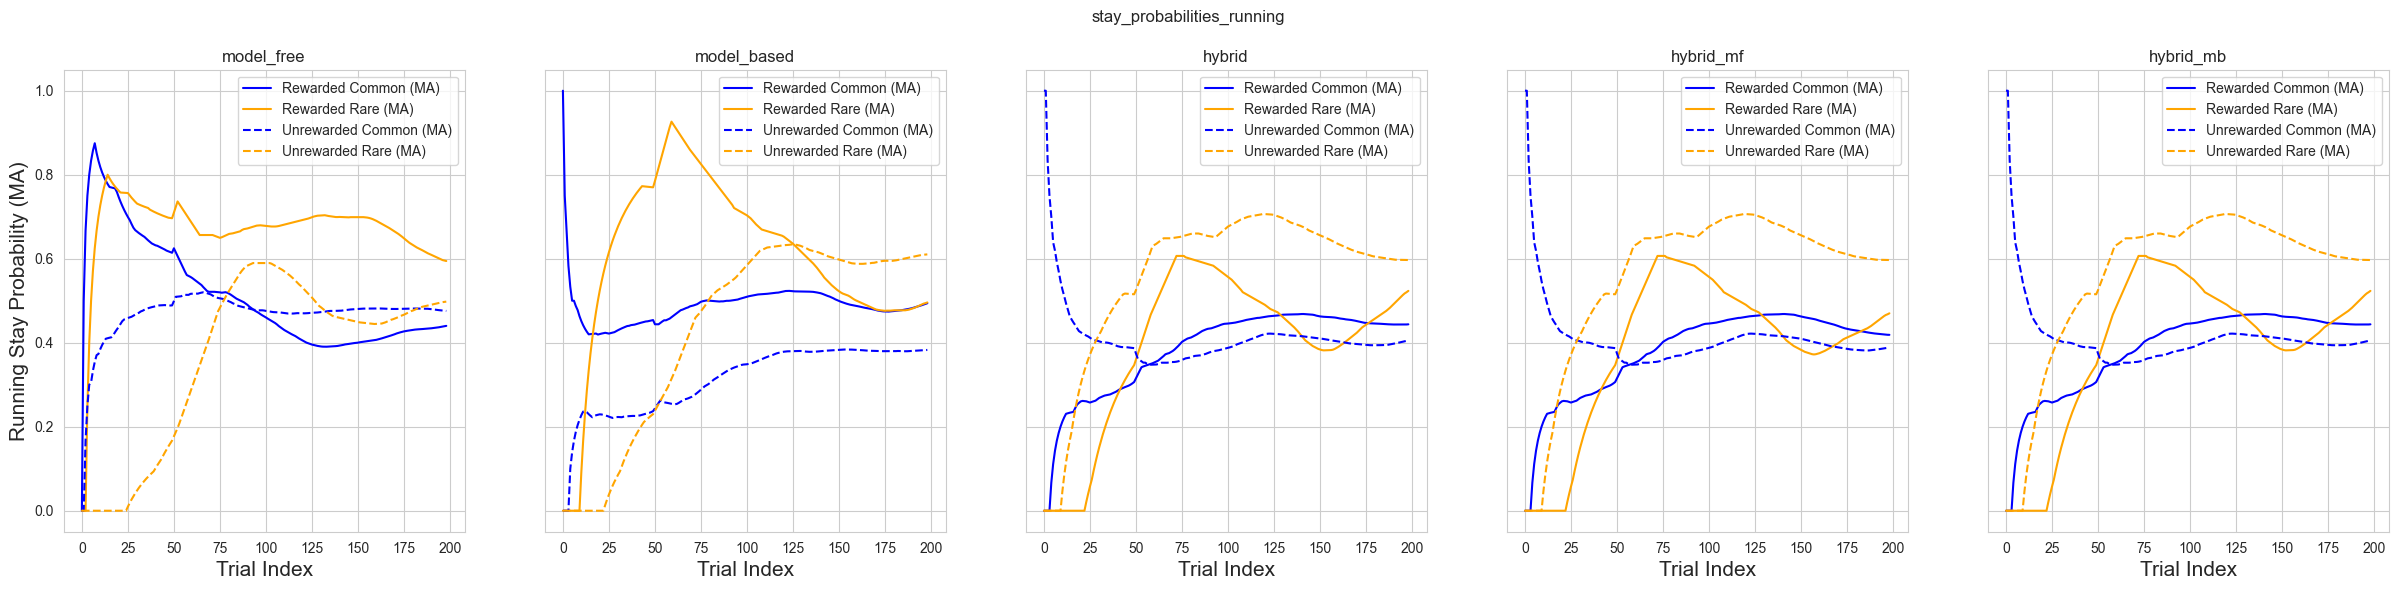

In [135]:
# plot running stay probabilities
window_size = 50
stay_probabilities_smoothed_ma = calc_plot_running_stay_probabilities(dfs=task_dfs, labels=model_names, title='stay_probabilities_running',
                                                                    window_size=window_size, max_plots_per_row=5)

In [136]:
def calculate_average_cumulative_reward_moving_average(data: pd.DataFrame, window_size=10) -> pd.DataFrame:
    # calculate the moving average of the reward
    tmp_df = data.copy()
    tmp_df['avg_cumulative_reward'] = tmp_df['reward'].rolling(window=window_size, min_periods=1).mean()
    return tmp_df

def plot_running_average_cumulative_reward(dfs: list[pd.DataFrame], labels: list[str]=None, title='', max_plots_per_row=4, save=False, filename="plots/average_cumulative_reward.png"):
    sns.set_style("whitegrid")
    
    if isinstance(dfs, pd.DataFrame) or not isinstance(dfs, list):
        dfs = [dfs]  # Wrap the single DataFrame in a list
    
    if labels is not None and not isinstance(labels, list):
        labels = [labels]

    n_plots = len(dfs)
    # Calculate the number of rows and columns for the subplot grid
    rows = (n_plots - 1) // max_plots_per_row + 1  # Ensure at least one row
    cols = min(n_plots, max_plots_per_row)  # Max of 4 columns
    
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(6*cols, 6*rows), sharey=True, sharex=True)
    
    # If there's only one subplot, axes won't be an array, so we wrap it in a list for consistency
    if n_plots == 1:
        axes = [axes]
    else:
        # Flatten the axes array to simplify indexing
        axes = axes.flatten()

    fig.suptitle(title)

    if labels is None:
        labels = [f"Plot {i}" for i in range(len(dfs))]
    if len(labels) < len(dfs):
        labels = labels + [f"Plot {i}" for i in range(len(dfs) - len(labels))]
    
    for i, data in enumerate(dfs):
        ax = axes[i]
        df = data.copy()
        # Create the line plot
        ax.plot(df.index, df['avg_cumulative_reward'], label='Average Cumulative Reward', linestyle='-', color='blue')

        ax.set_title(labels[i], fontsize=20)

        # Set the size of the x and y ticks labels
        ax.tick_params(labelsize=12)

        if i >= (n_plots - max_plots_per_row):
            ax.set_xlabel('Trial', fontsize=15)
        else:
            # Hide the x-axis label
            ax.set_xlabel('', visible=False)
        if i%max_plots_per_row == 0:
            ax.set_ylabel('Average Cumulative Reward', fontsize=15)
        else:
            # Hide the y-axis label
            ax.set_ylabel('', visible=False)
        
        # plot a line at y=0.5
        ax.axhline(y=0.5, color='r', linestyle='--', label='Chance Level')

    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    plt.show()
    if save:
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        # add timestamp to filename
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = filename.replace('.png', f'_{timestamp}.png')
        fig.savefig(filename)
        print(f'Plot saved to {filename}')

def calc_plot_running_average_cumulative_reward(dfs: list[pd.DataFrame], labels: list[str]=None, title='', window_size=50, plot=True, return_df=True, max_plots_per_row=4, save=False, filename="plots/average_cumulative_reward.png"):
    if isinstance(dfs, pd.DataFrame) or not isinstance(dfs, list):
        dfs = [dfs]
    # calculate the moving average of the reward
    running_average_cumulative_reward = [calculate_average_cumulative_reward_moving_average(df, window_size=window_size)
                                        for df in dfs]
    # plot the moving average of the reward
    if plot:
        plot_running_average_cumulative_reward(running_average_cumulative_reward, labels=labels, title=title, max_plots_per_row=max_plots_per_row, save=save, filename=filename)
    if return_df:
        return running_average_cumulative_reward

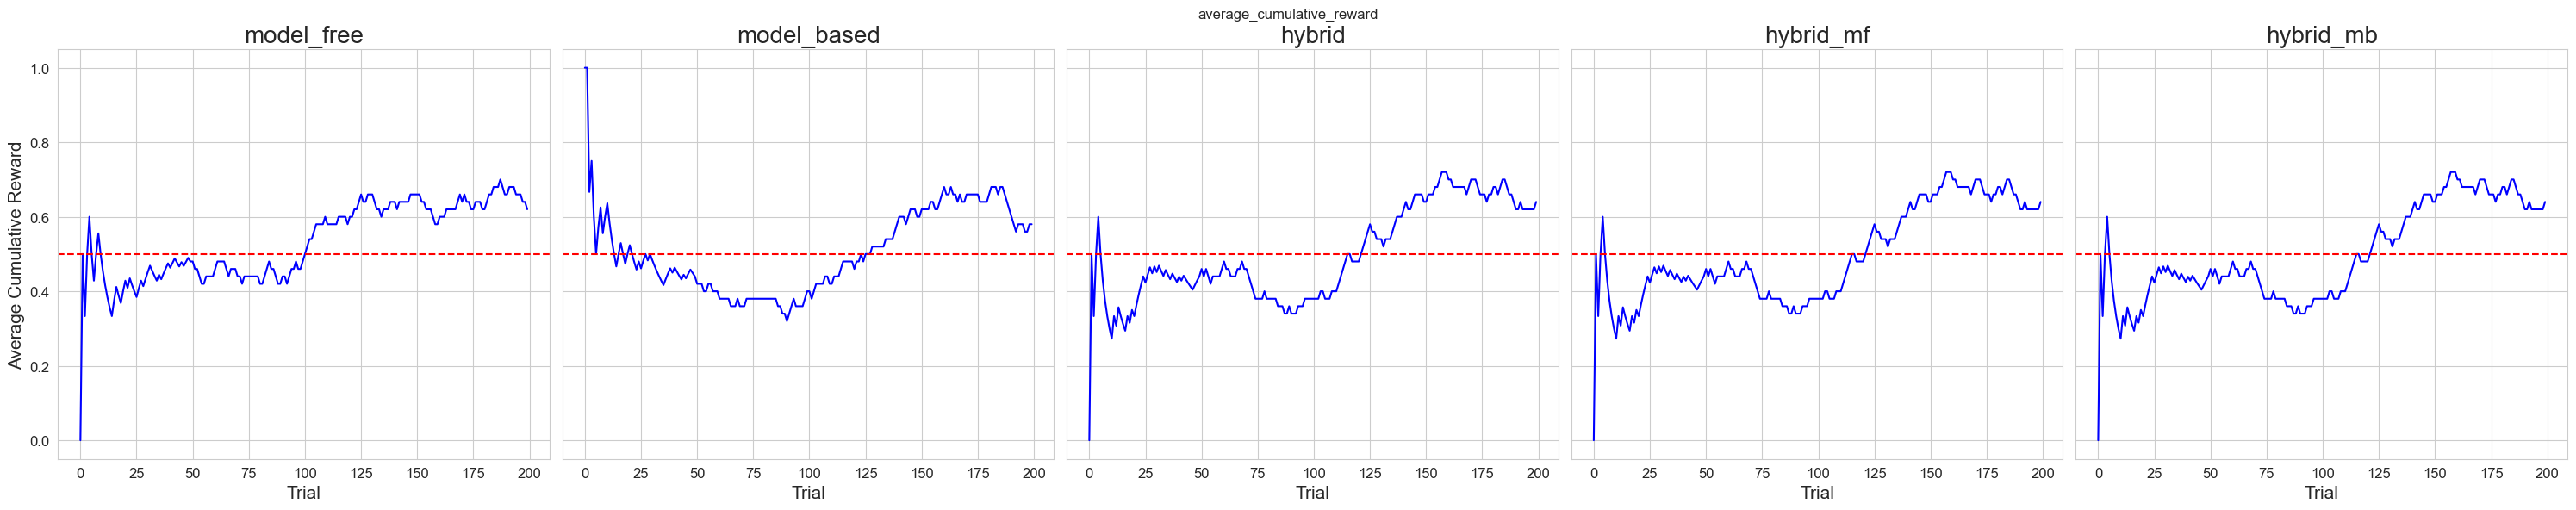

In [137]:
# plot the average cumulative reward
window_size = 50
average_cumulative_rewards = calc_plot_running_average_cumulative_reward(dfs=task_dfs, labels=model_names, title='average_cumulative_reward',
                                                                        window_size=window_size, max_plots_per_row=5)

## Model Simulation *(3 points)*

For this exercise you should:

*   Simulate data from both models for a single set of parameters. The simulation should mimic the experiment you are trying to model. *(2 points)*

*   Plot the simulated behavior of both models. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


### Simulate Data with a Single Set Of Parameters

Here we simulate data from our models again, with a single set of hand-picked parameters. For reward probabilities, we use data from the experiment directly instead of approximating it.

In [138]:
# parameters
SEED = 0
params_model_free = {'alpha': 0.3,
                     'beta': 5}
params_model_based = {'alpha': 0.2,
                      'beta': 4}
params_hybrid = {'alpha_1': 0.4,
                 'alpha_2': 0.2,
                 'beta_1': 6,
                 'beta_2': 3,
                 '_lambda': 0.5,
                 'w': 0.5,
                 'p': 0.02}
params_hybrid_mf = {'alpha_1': 0.3,
                    'alpha_2': 0.5,
                    'beta_1': 5,
                    'beta_2': 3,
                    '_lambda': 0.7,
                    'w': 0.0,
                    'p': -0.1}
params_hybrid_mb = {'alpha_1': 0.1,  # arbitrary value in case of pure model based
                    'alpha_2': 0.3,
                    'beta_1': 3,
                    'beta_2': 5,
                    '_lambda': 0.5,  # arbitrary value in case of pure model based
                    'w': 1.0,
                    'p': 0.1}

In [139]:
import os

def detect_and_convert_1d_string_array(string_array: str):
    """
    Helper function to detect the type of the elements in a string array and convert them to the appropriate type
    Used for converting the rewardProbabilities and rewardDistribution columns from string to array
    :param string_array: array as a string, taken from experiment data
    :return: string converted to actual array
    """
    # Remove the outer brackets and split by ',' to handle both 1D and multidimensional arrays
    elements = string_array.strip('[]').replace(' ', '').split(',')
    # Attempt to determine the type of each element
    converted_elements = []
    for element in elements:
        if element.lower() in ['true', 'false']:
            # Convert string to boolean
            converted_elements.append(element.lower() == 'true')
        else:
            try:
                # Attempt to convert string to float
                converted_elements.append(float(element))
            except ValueError:
                # Handle the case where the conversion is not possible
                raise ValueError(f"Element {element} is neither a recognizable number nor a boolean value.")
    # Determine if the array is boolean or numeric based on the types of converted elements
    if all(isinstance(el, bool) for el in converted_elements):
        result_array = np.array(converted_elements, dtype=bool)
    elif all(isinstance(el, (int, float)) for el in converted_elements):
        # Convert elements to float if mixed types (e.g., boolean and numbers) or all numbers
        result_array = np.array(converted_elements, dtype=float)
    else:
        print(f"Array contains mixed types: {converted_elements}")
        result_array = np.array(converted_elements)
        print(f"Array converted to default type: {result_array.dtype}")
    return result_array

def preprocess_human_data(data_df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess the human data from the experiments
    :param data_df: experiment data as a dataframe
    :return: preprocessed data
    """
    data = data_df.copy()
    
    # rename column reward_Param to rewardDistribution
    data.rename(columns={'rewards_Param': 'rewardDistribution'}, inplace=True)
    # infer common transition from the action taken in stage 1 and isHighProbOne/Two
    data['common_transition'] = np.where(data['stepOneChoice'] == 0,
                                            data['isHighProbOne'],
                                            data['isHighProbTwo'])

    # infer the state transition to from the action taken in stage 2
    data['state_transition_to'] = (data['stepTwoChoice'] // 2) + 1  # 1 if choice is 0 or 1. 2 if choice is 2 or 3

    # convert the rewardProbabilities from string to a array
    data['rewardProbabilities'] = data['rewardProbabilities'].apply(detect_and_convert_1d_string_array)
    
    # convert the rewardDistribution from string a array
    data['rewardDistribution'] = data['rewardDistribution'].apply(detect_and_convert_1d_string_array)
    
    # convert stepTwoChoice from range 0-3 to 0-1
    data['stepTwoChoice'] = data['stepTwoChoice'] % 2

    return data

# load and inspect human data
group = 'group_01'
participant_data_file = "experiment_data_1.csv"
file_name = os.path.join("data", "participants", group, participant_data_file)
participant_data = pd.read_csv(file_name)
# preprocess human data
participant_data = preprocess_human_data(participant_data)

# Run simulation and save to csv
task_df_mf, agent_mf = simulate(agent_type='model_free', params=params_model_free, seed=SEED, from_data=participant_data, use_reward_distribution=True)
task_df_mb, agent_mb = simulate(agent_type='model_based', params=params_model_based, seed=SEED, from_data=participant_data, use_reward_distribution=True)
task_df_hybrid, agent_hybrid = simulate(agent_type='hybrid', params=params_hybrid, seed=SEED, from_data=participant_data, use_reward_distribution=True)
task_df_hybrid_mf, agent_hybrid_mf = simulate(agent_type='hybrid', params=params_hybrid_mf, seed=SEED, from_data=participant_data, use_reward_distribution=True)
task_df_hybrid_mb, agent_hybrid_mb = simulate(agent_type='hybrid', params=params_hybrid_mb, seed=SEED, from_data=participant_data, use_reward_distribution=True)

save_simulated_data(task_df_mf, agent_type='model_free')
save_simulated_data(task_df_mb, agent_type='model_based')
save_simulated_data(task_df_hybrid, agent_type='hybrid')
save_simulated_data(task_df_hybrid_mf, agent_type='hybrid_mf')
save_simulated_data(task_df_hybrid_mb, agent_type='hybrid_mb')

Data saved to data/simulated/model_free/20240228-233147/simulated_data.csv
Data saved to data/simulated/model_based/20240228-233147/simulated_data.csv
Data saved to data/simulated/hybrid/20240228-233147/simulated_data.csv
Data saved to data/simulated/hybrid_mf/20240228-233147/simulated_data.csv
Data saved to data/simulated/hybrid_mb/20240228-233147/simulated_data.csv


In [140]:
task_dfs = [task_df_mf, task_df_mb, task_df_hybrid, task_df_hybrid_mf, task_df_hybrid_mb, participant_data]
model_names = ['model_free', 'model_based', 'hybrid', 'hybrid_mf', 'hybrid_mb', 'participant']

In [141]:
# print some statistics about the task
for task_df, model_name in zip(task_dfs, model_names):
    print_simple_task_summary(task_df, title=model_name)

### model_free
common transitions percentage: 69.0 %
rewarded trails percentage: 51.0 %
### model_based
common transitions percentage: 72.5 %
rewarded trails percentage: 57.99999999999999 %
### hybrid
common transitions percentage: 70.0 %
rewarded trails percentage: 53.0 %
### hybrid_mf
common transitions percentage: 69.0 %
rewarded trails percentage: 56.00000000000001 %
### hybrid_mb
common transitions percentage: 72.0 %
rewarded trails percentage: 50.0 %
### participant
common transitions percentage: 70.5 %
rewarded trails percentage: 56.99999999999999 %


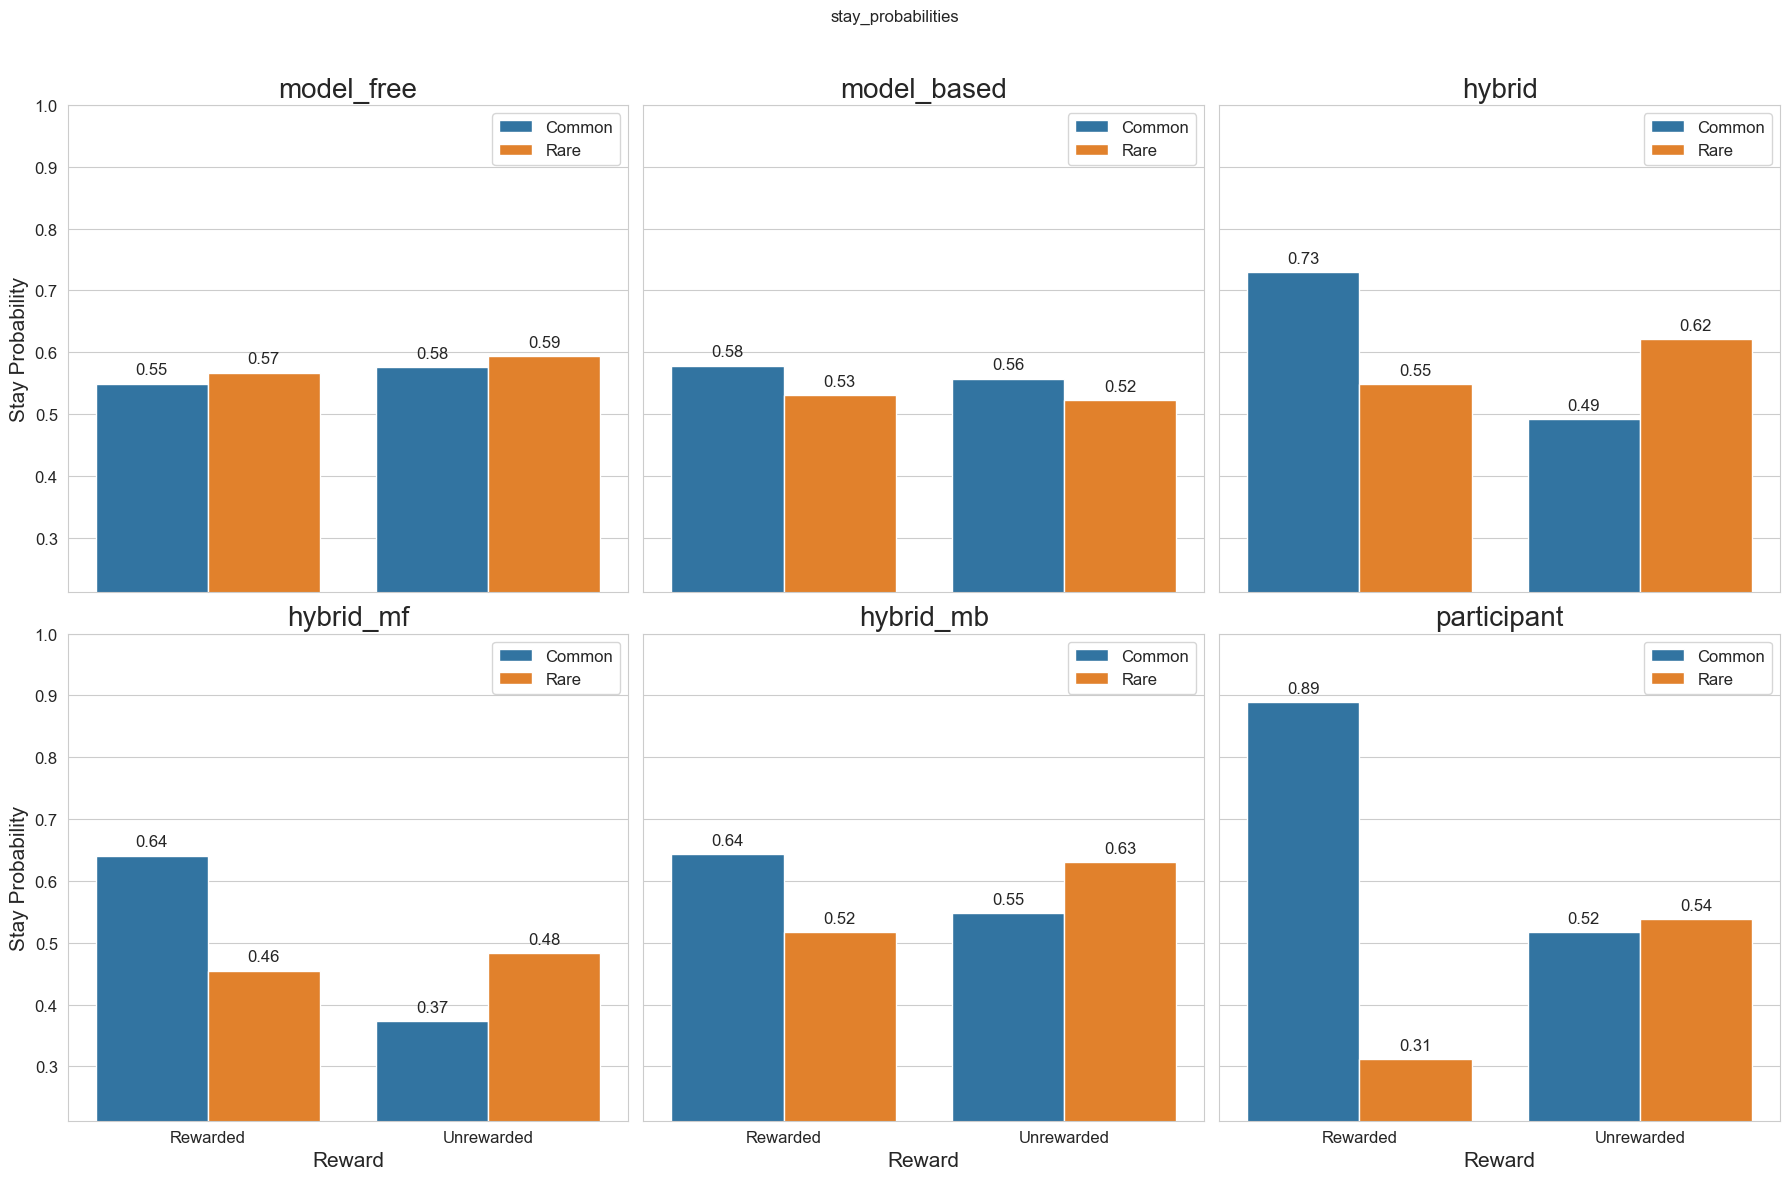

In [142]:
# plot stay probabilities
stay_probabilities = calc_plot_stay_probabilities(dfs=task_dfs, labels=model_names, title='stay_probabilities', max_plots_per_row=3)

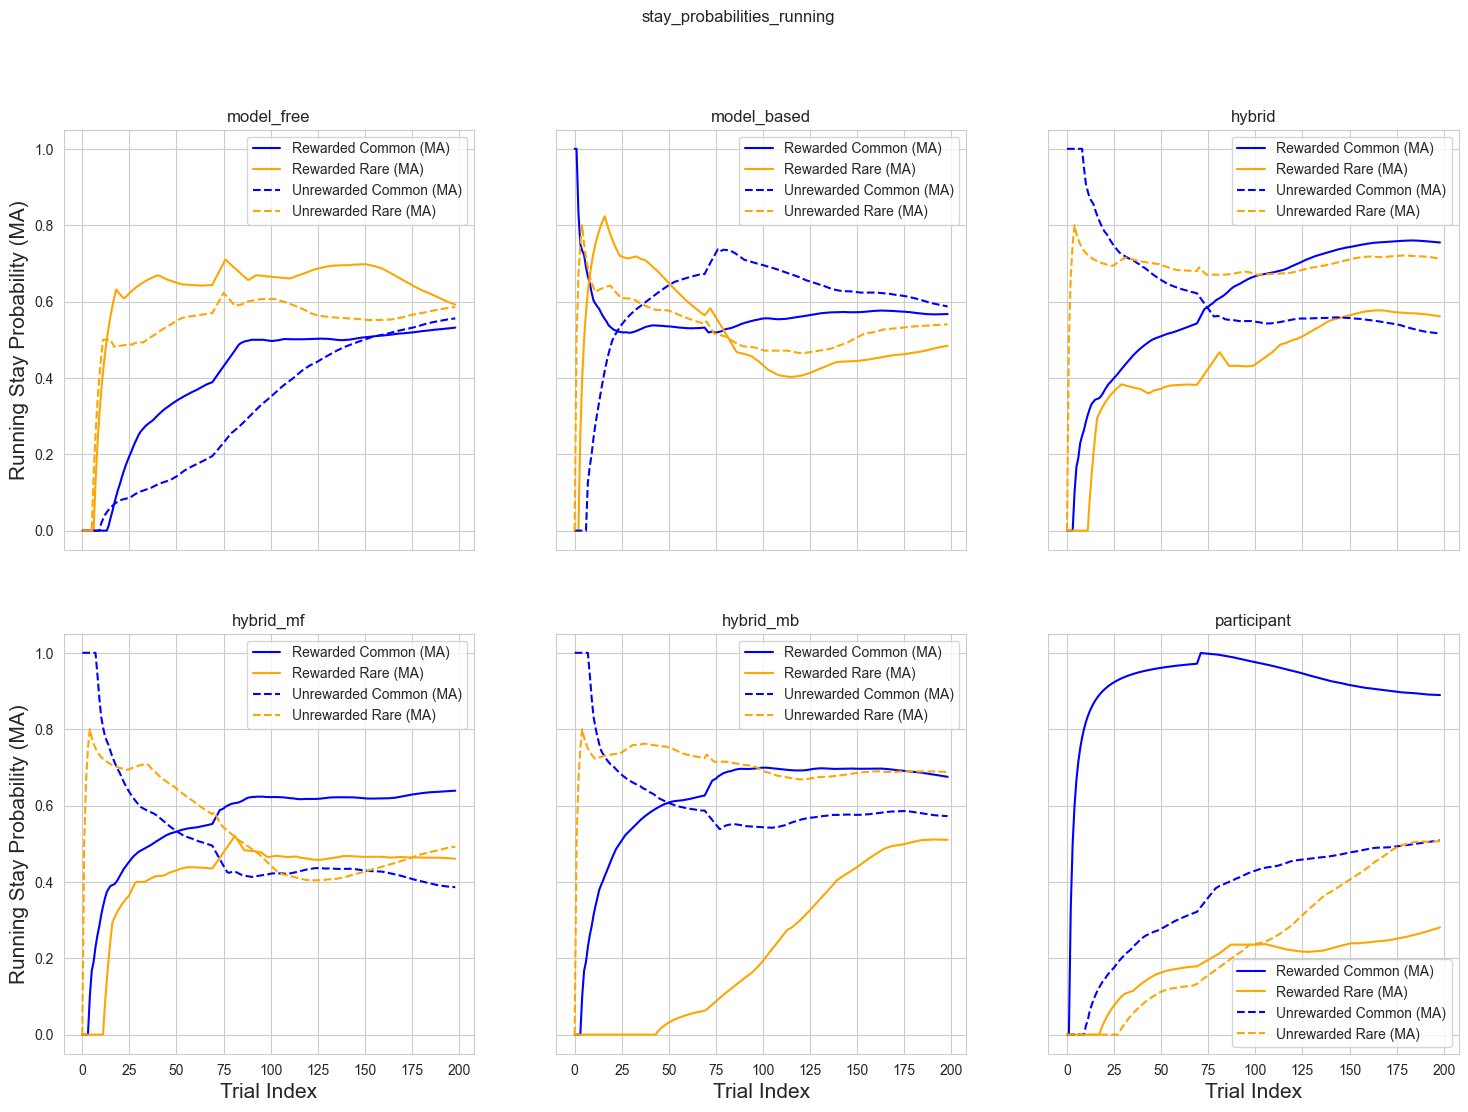

In [143]:
# plot stay probabilities smoothed moving average
window_size = 70
stay_probabilities_smoothed_ma = calc_plot_running_stay_probabilities(dfs=task_dfs, labels=model_names, title='stay_probabilities_running',
                                                                    window_size=window_size, max_plots_per_row=3)


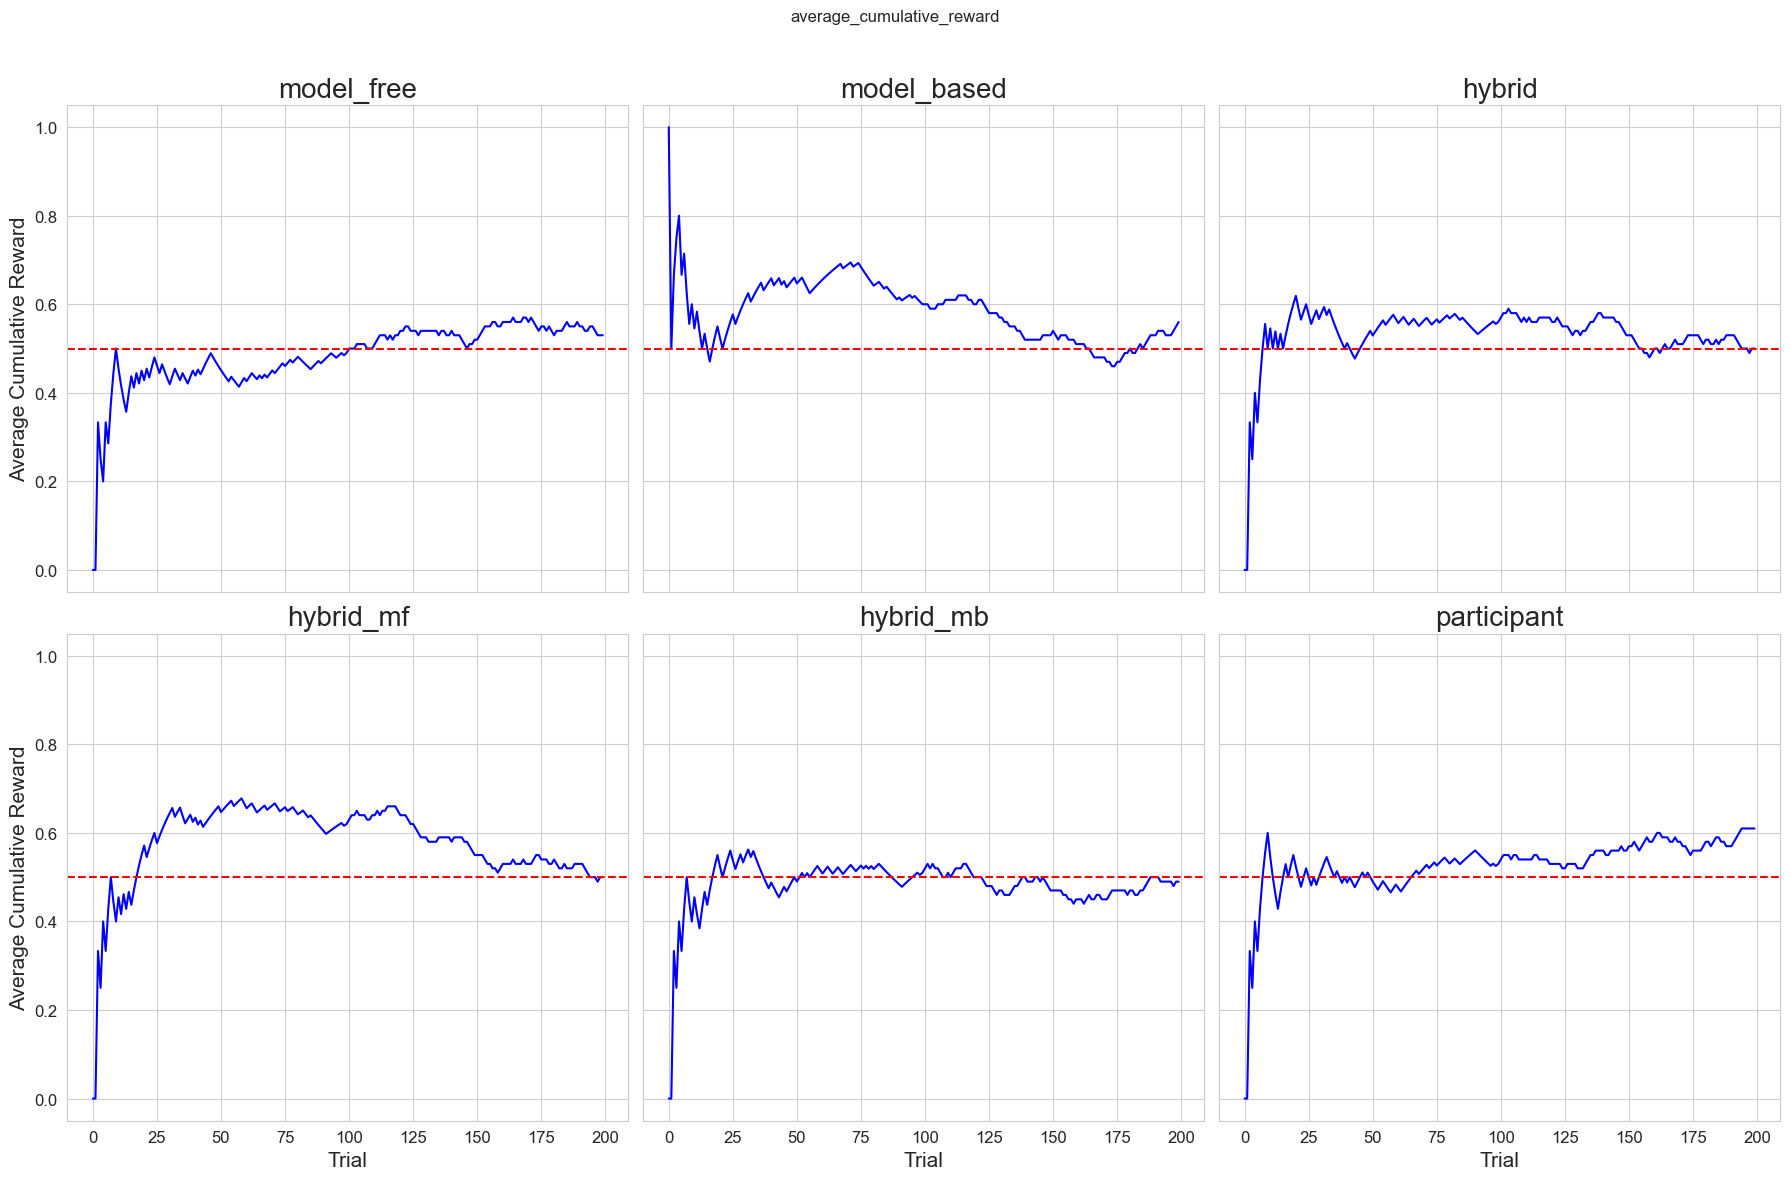

In [144]:
# plot the average cumulative rewards
window_size = 100
average_cumulative_rewards = calc_plot_running_average_cumulative_reward(dfs=task_dfs, labels=model_names, title='average_cumulative_reward',
                                                                        window_size=window_size, max_plots_per_row=3)

## Parameter Fitting *(4 points)*

For this exercise you should:

*   Set up a suitable parameter search space *(1 point)*

*   Implement a procedure to evaluate the fit of a model based on data *(2 points)*

*   Implement a procedure for searching the parameter space. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.



### <spin style="color: green">fitting procedures</spin>
For all the fitting procedures, we are using the (negative) log-likelihood of the data given the model as the objective.

We try fitting using grid search for the two simple models and random search for the hybrid model.
We also MCMC sampling.

First we plot the human data from the experiments.  


In [145]:
from scipy.stats import uniform
from IPython.display import display
from tqdm import tqdm

In [146]:
import os
import pandas as pd

def load_files_from_folder(folder_path, max_files=None, file_end='.csv'):
    """
    Load CSV files from a specified folder.

    :param folder_path: Path to the folder containing CSV files.
    :param max_files: Maximum number of CSV files to load. If None, all files are loaded.
    :return: A list of pandas DataFrames.
    """
    csv_files = [f for f in os.listdir(folder_path) if f.endswith(file_end)]
    
    # Sort files alphabetically to ensure consistent order
    csv_files.sort()
    
    # Limit the number of files to load, if max_files is specified
    if max_files is not None:
        csv_files = csv_files[:max_files]
    
    dataframes = []
    for filename in csv_files:
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        dataframes.append(df)
    
    return dataframes


In [147]:
data_dir_group_1 = "data/participants/group_01"
data_dir_group_2 = "data/participants/group_02"
data_dir_group_3 = "data/participants/group_03"

data_g_1 = load_files_from_folder(data_dir_group_1)
data_g_2 = load_files_from_folder(data_dir_group_2)
data_g_3 = load_files_from_folder(data_dir_group_3)


In [148]:
data_g_1 = [preprocess_human_data(df) for df in data_g_1]
data_g_2 = [preprocess_human_data(df) for df in data_g_2]
data_g_3 = [preprocess_human_data(df) for df in data_g_3]
data_g_all = data_g_1 + data_g_2 + data_g_3

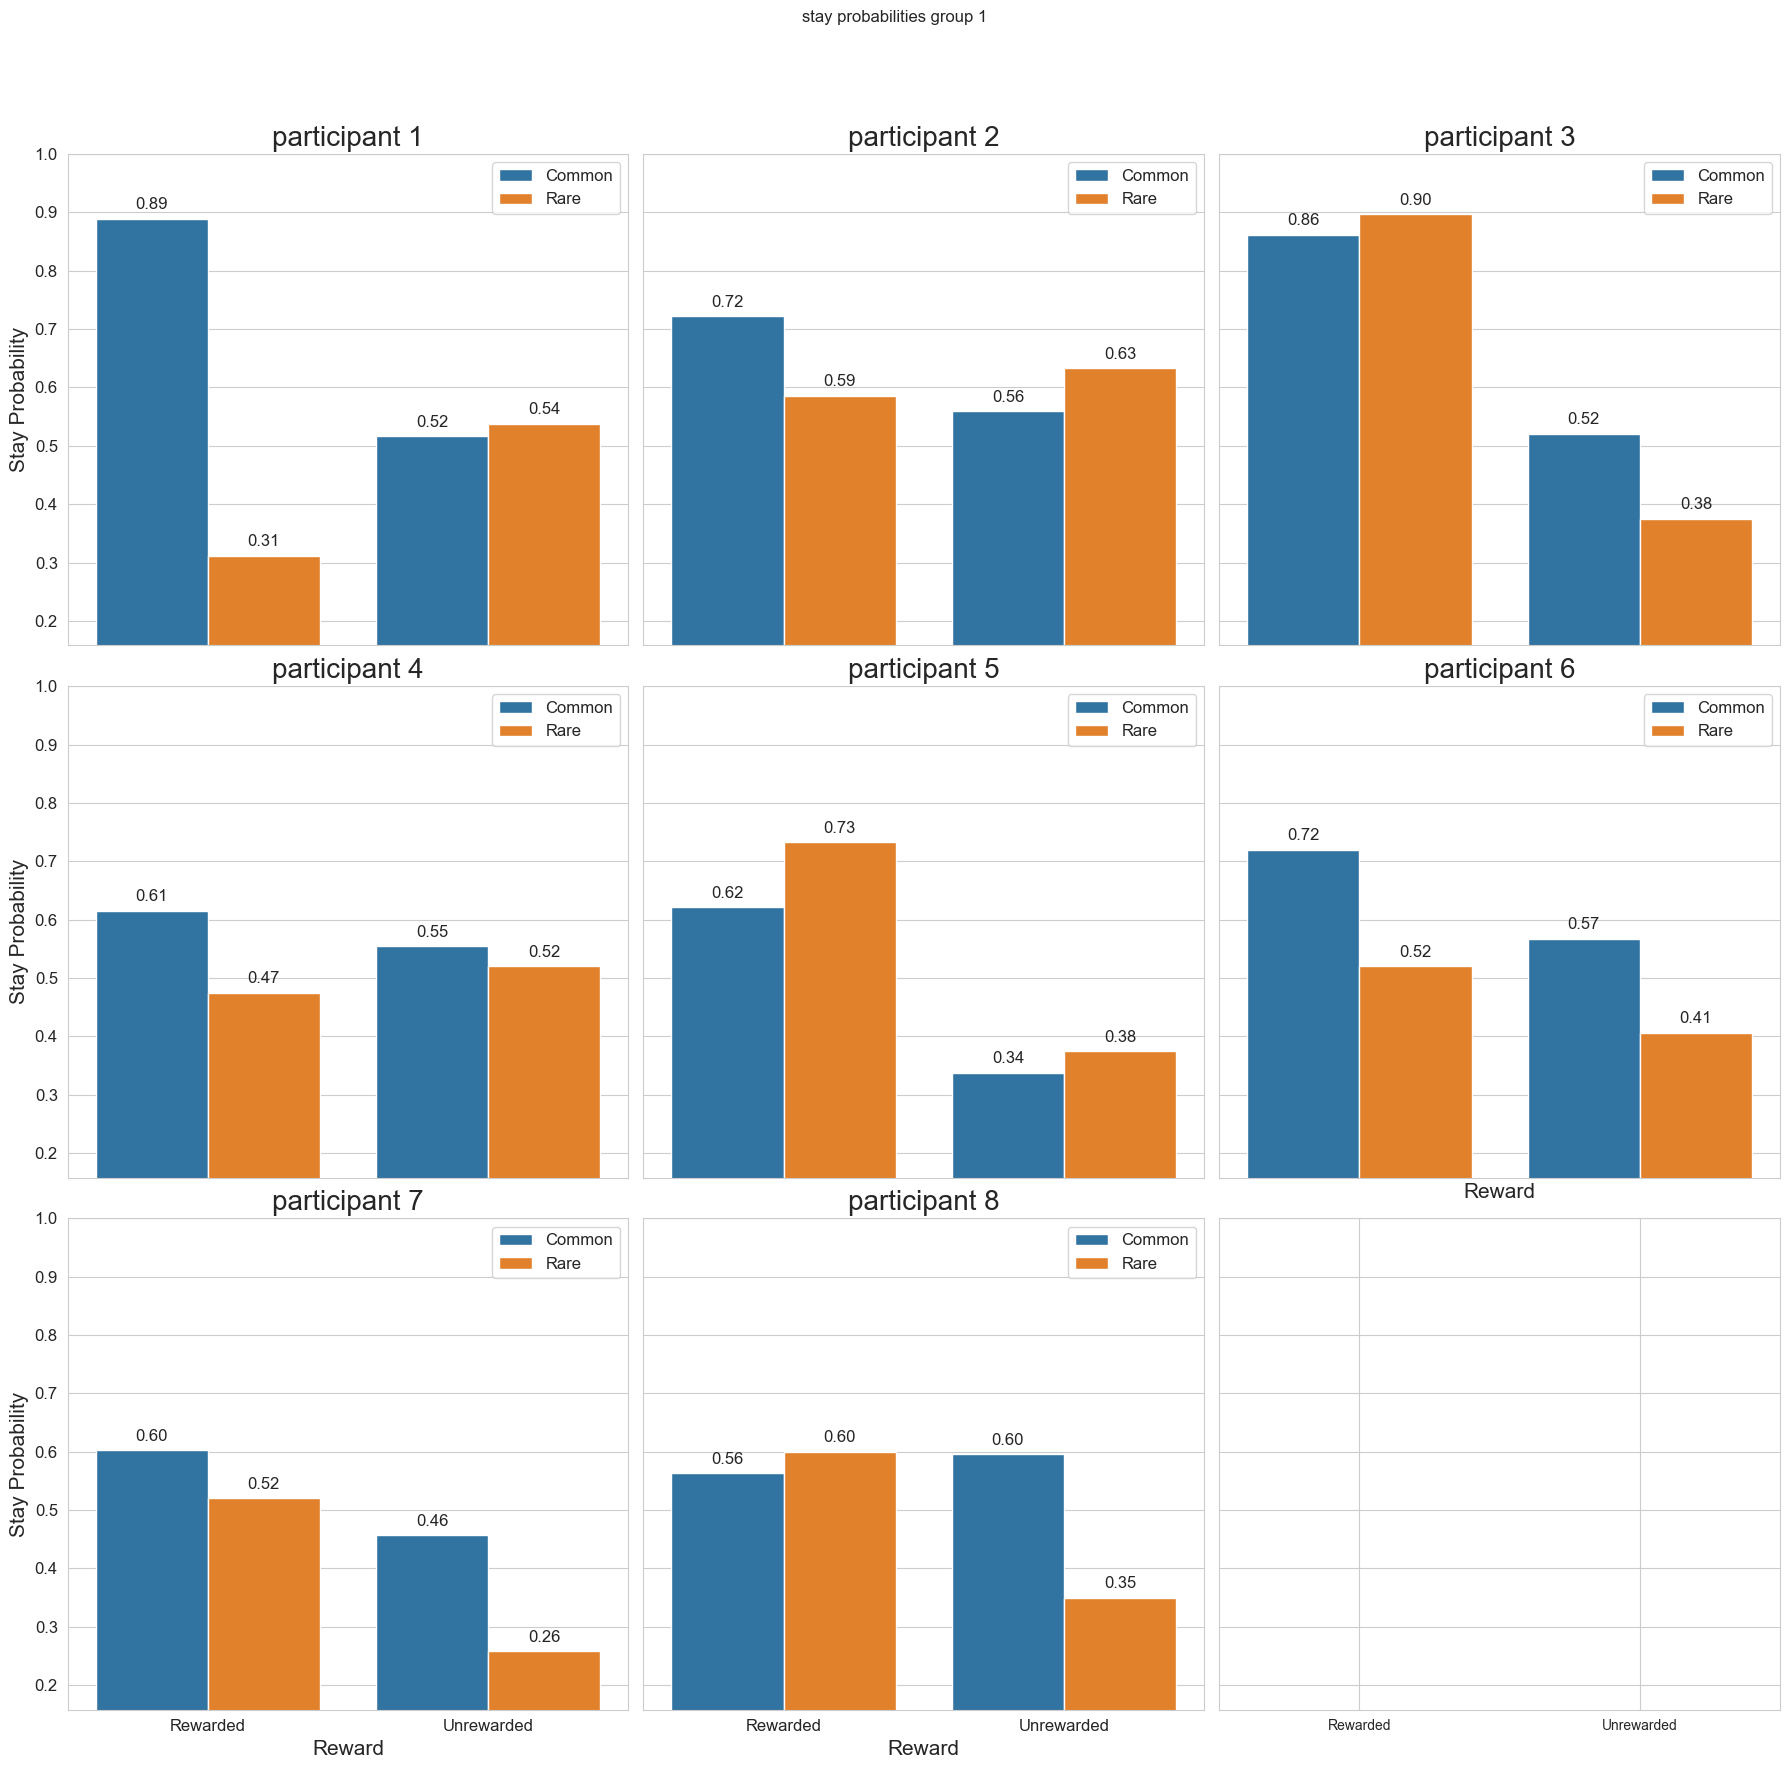

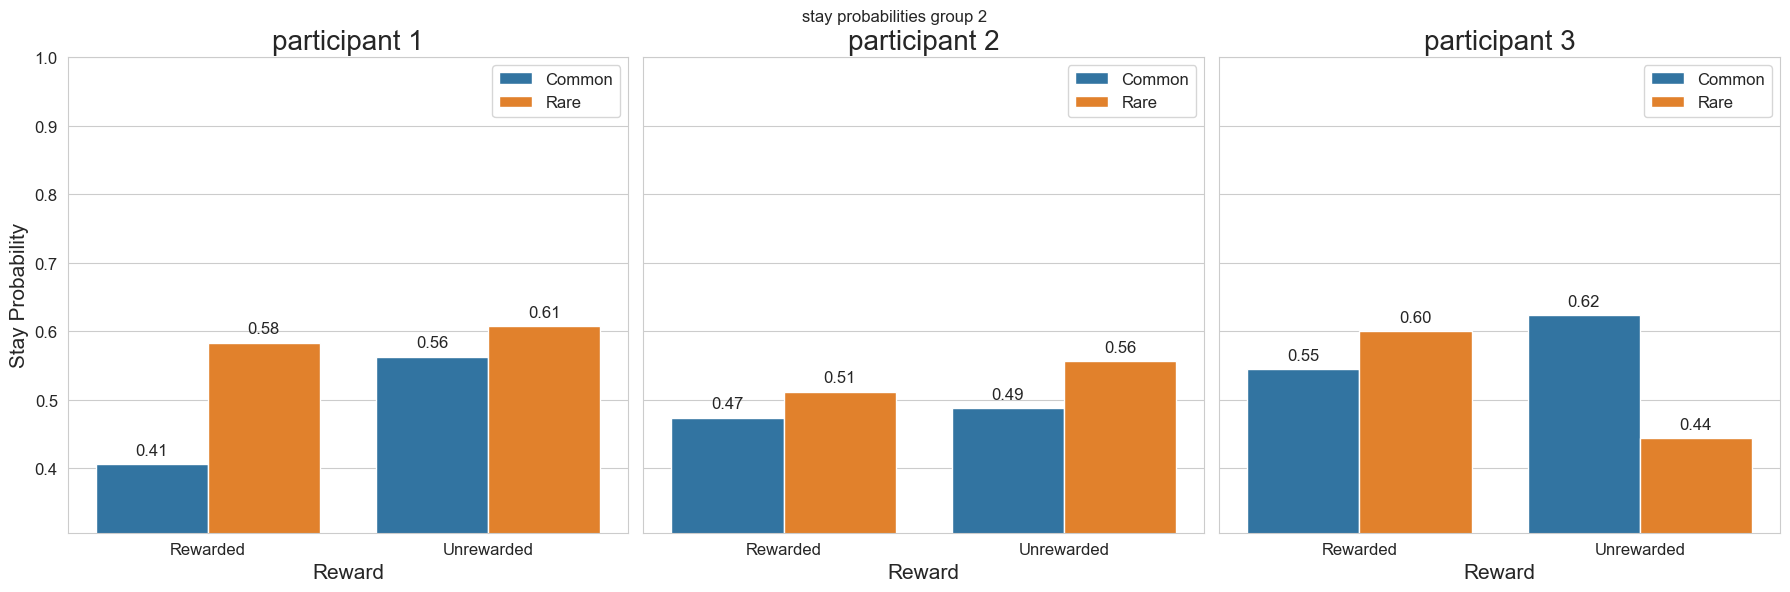

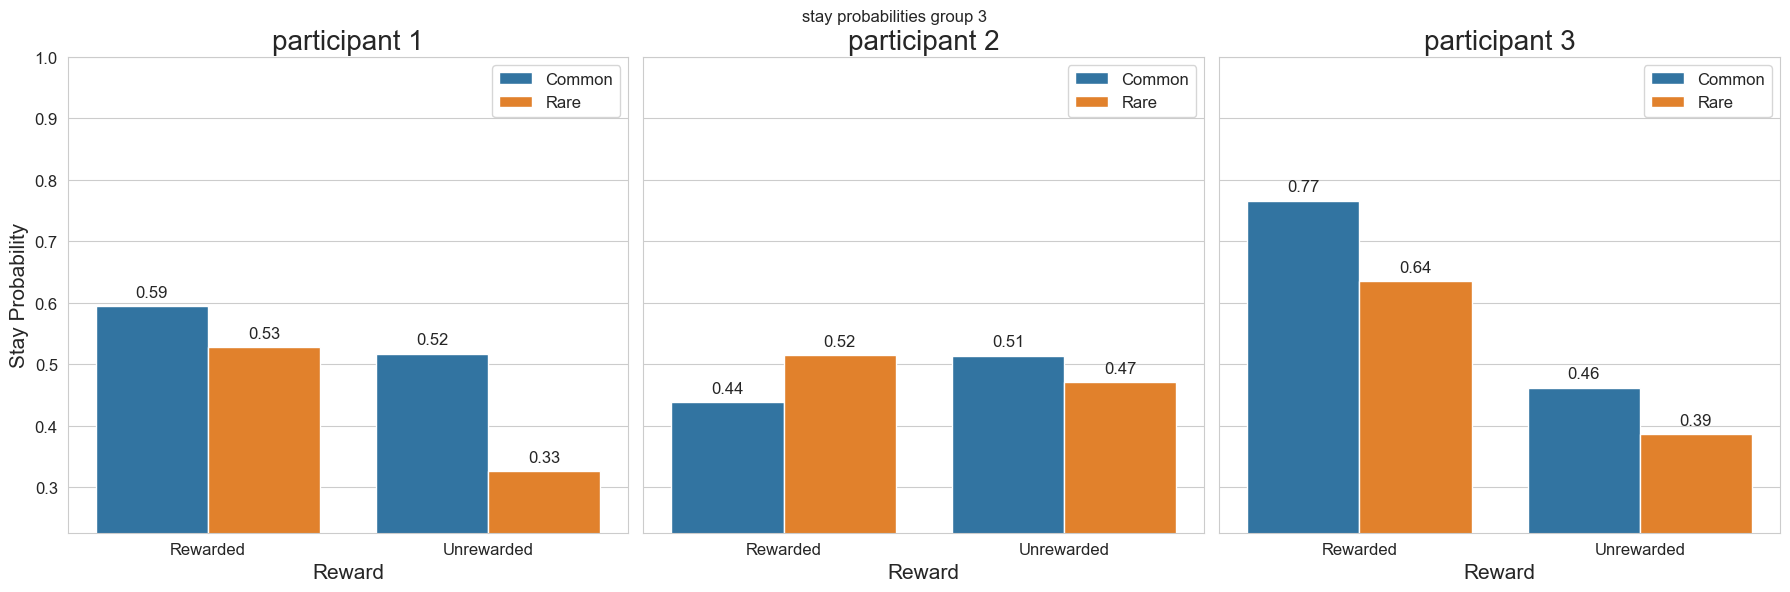

In [149]:
stay_probabilities_g_1 = calc_plot_stay_probabilities(dfs=data_g_1, labels=[f'participant {i}' for i in range(1, len(data_g_1) + 1)],
                                                      title='stay probabilities group 1', max_plots_per_row=3)
stay_probabilities_g_2 = calc_plot_stay_probabilities(dfs=data_g_2, labels=[f'participant {i}' for i in range(1, len(data_g_2) + 1)],
                                                        title='stay probabilities group 2', max_plots_per_row=3)
stay_probabilities_g_3 = calc_plot_stay_probabilities(dfs=data_g_3, labels=[f'participant {i}' for i in range(1, len(data_g_3) + 1)],
                                                        title='stay probabilities group 3', max_plots_per_row=3)

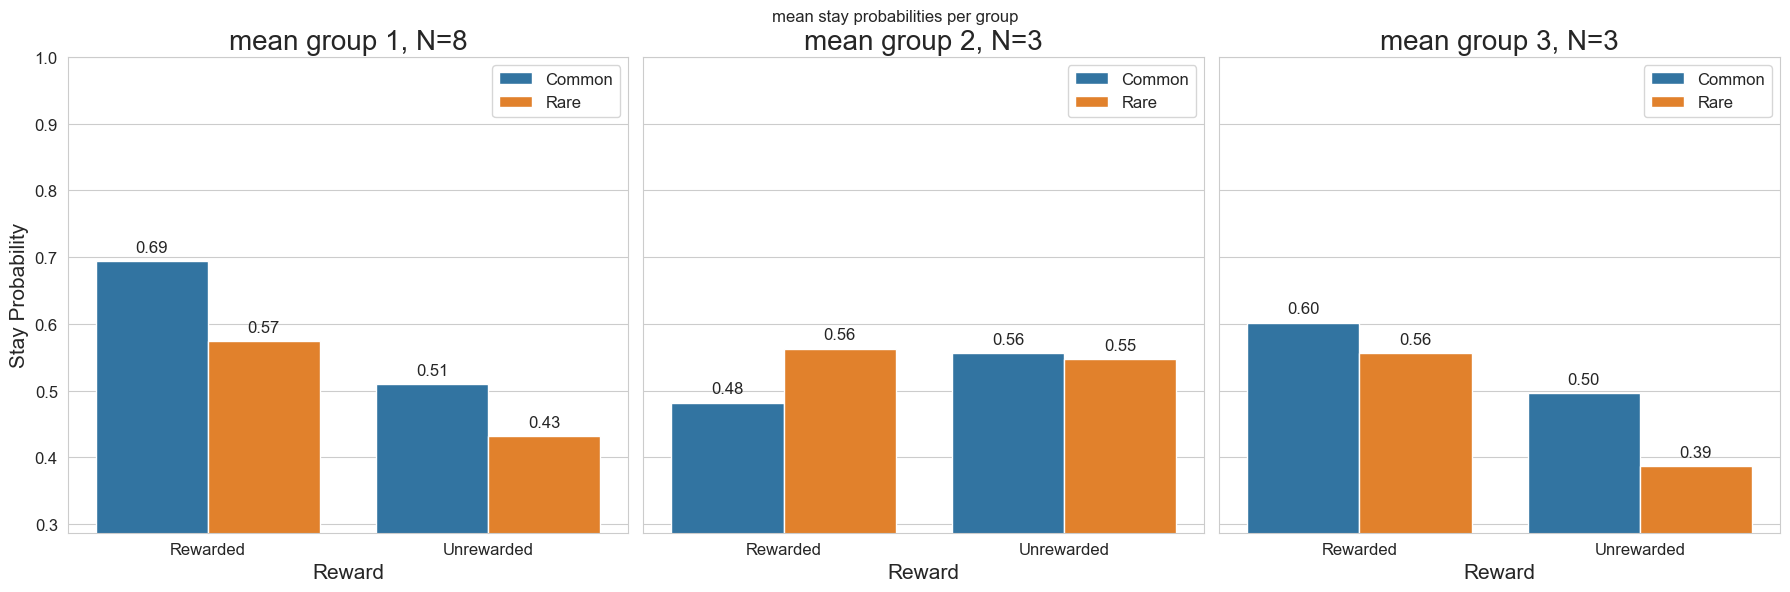

In [150]:
# plot the mean stay probabilities over each group
data_g_1_total = pd.concat(data_g_1)
data_g_2_total = pd.concat(data_g_2)
data_g_3_total = pd.concat(data_g_3)
stay_probabilities_g_1_mean = calc_plot_stay_probabilities(dfs=[data_g_1_total,data_g_2_total,data_g_3_total],
                                                           labels=[f'mean group 1, N={len(data_g_1)}', f'mean group 2, N={len(data_g_2)}', f'mean group 3, N={len(data_g_3)}'],
                                                           title='mean stay probabilities per group', max_plots_per_row=3)


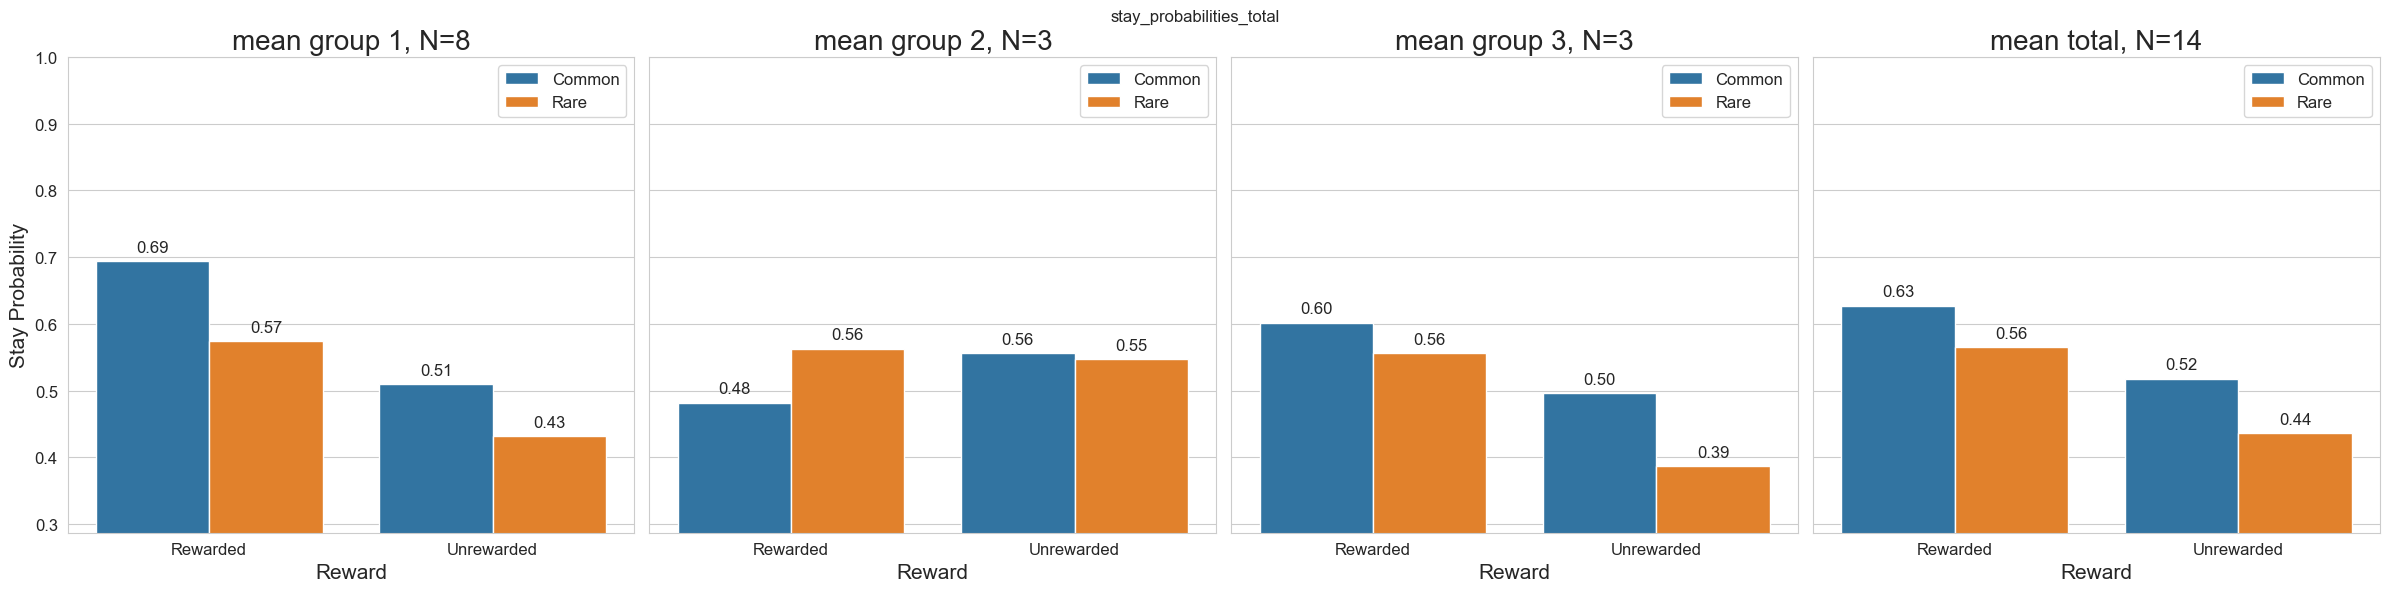

In [151]:
data_total = pd.concat([data_g_1_total, data_g_2_total, data_g_3_total])
stay_probabilities_total = calc_plot_stay_probabilities(dfs=[data_g_1_total, data_g_2_total, data_g_3_total, data_total],
                                        labels=[f'mean group 1, N={len(data_g_1)}', f'mean group 2, N={len(data_g_2)}', f'mean group 3, N={len(data_g_3)}', f'mean total, N={len(data_g_all)}'],
                                        title='stay_probabilities_total', max_plots_per_row=4)

Labels not provided or not matching the number of dataframes, using default labels
generated labels: ['data 1', 'data 2', 'data 3', 'data 4', 'data 5', 'data 6', 'data 7', 'data 8', 'data 9', 'data 10', 'data 11', 'data 12', 'data 13', 'data 14']


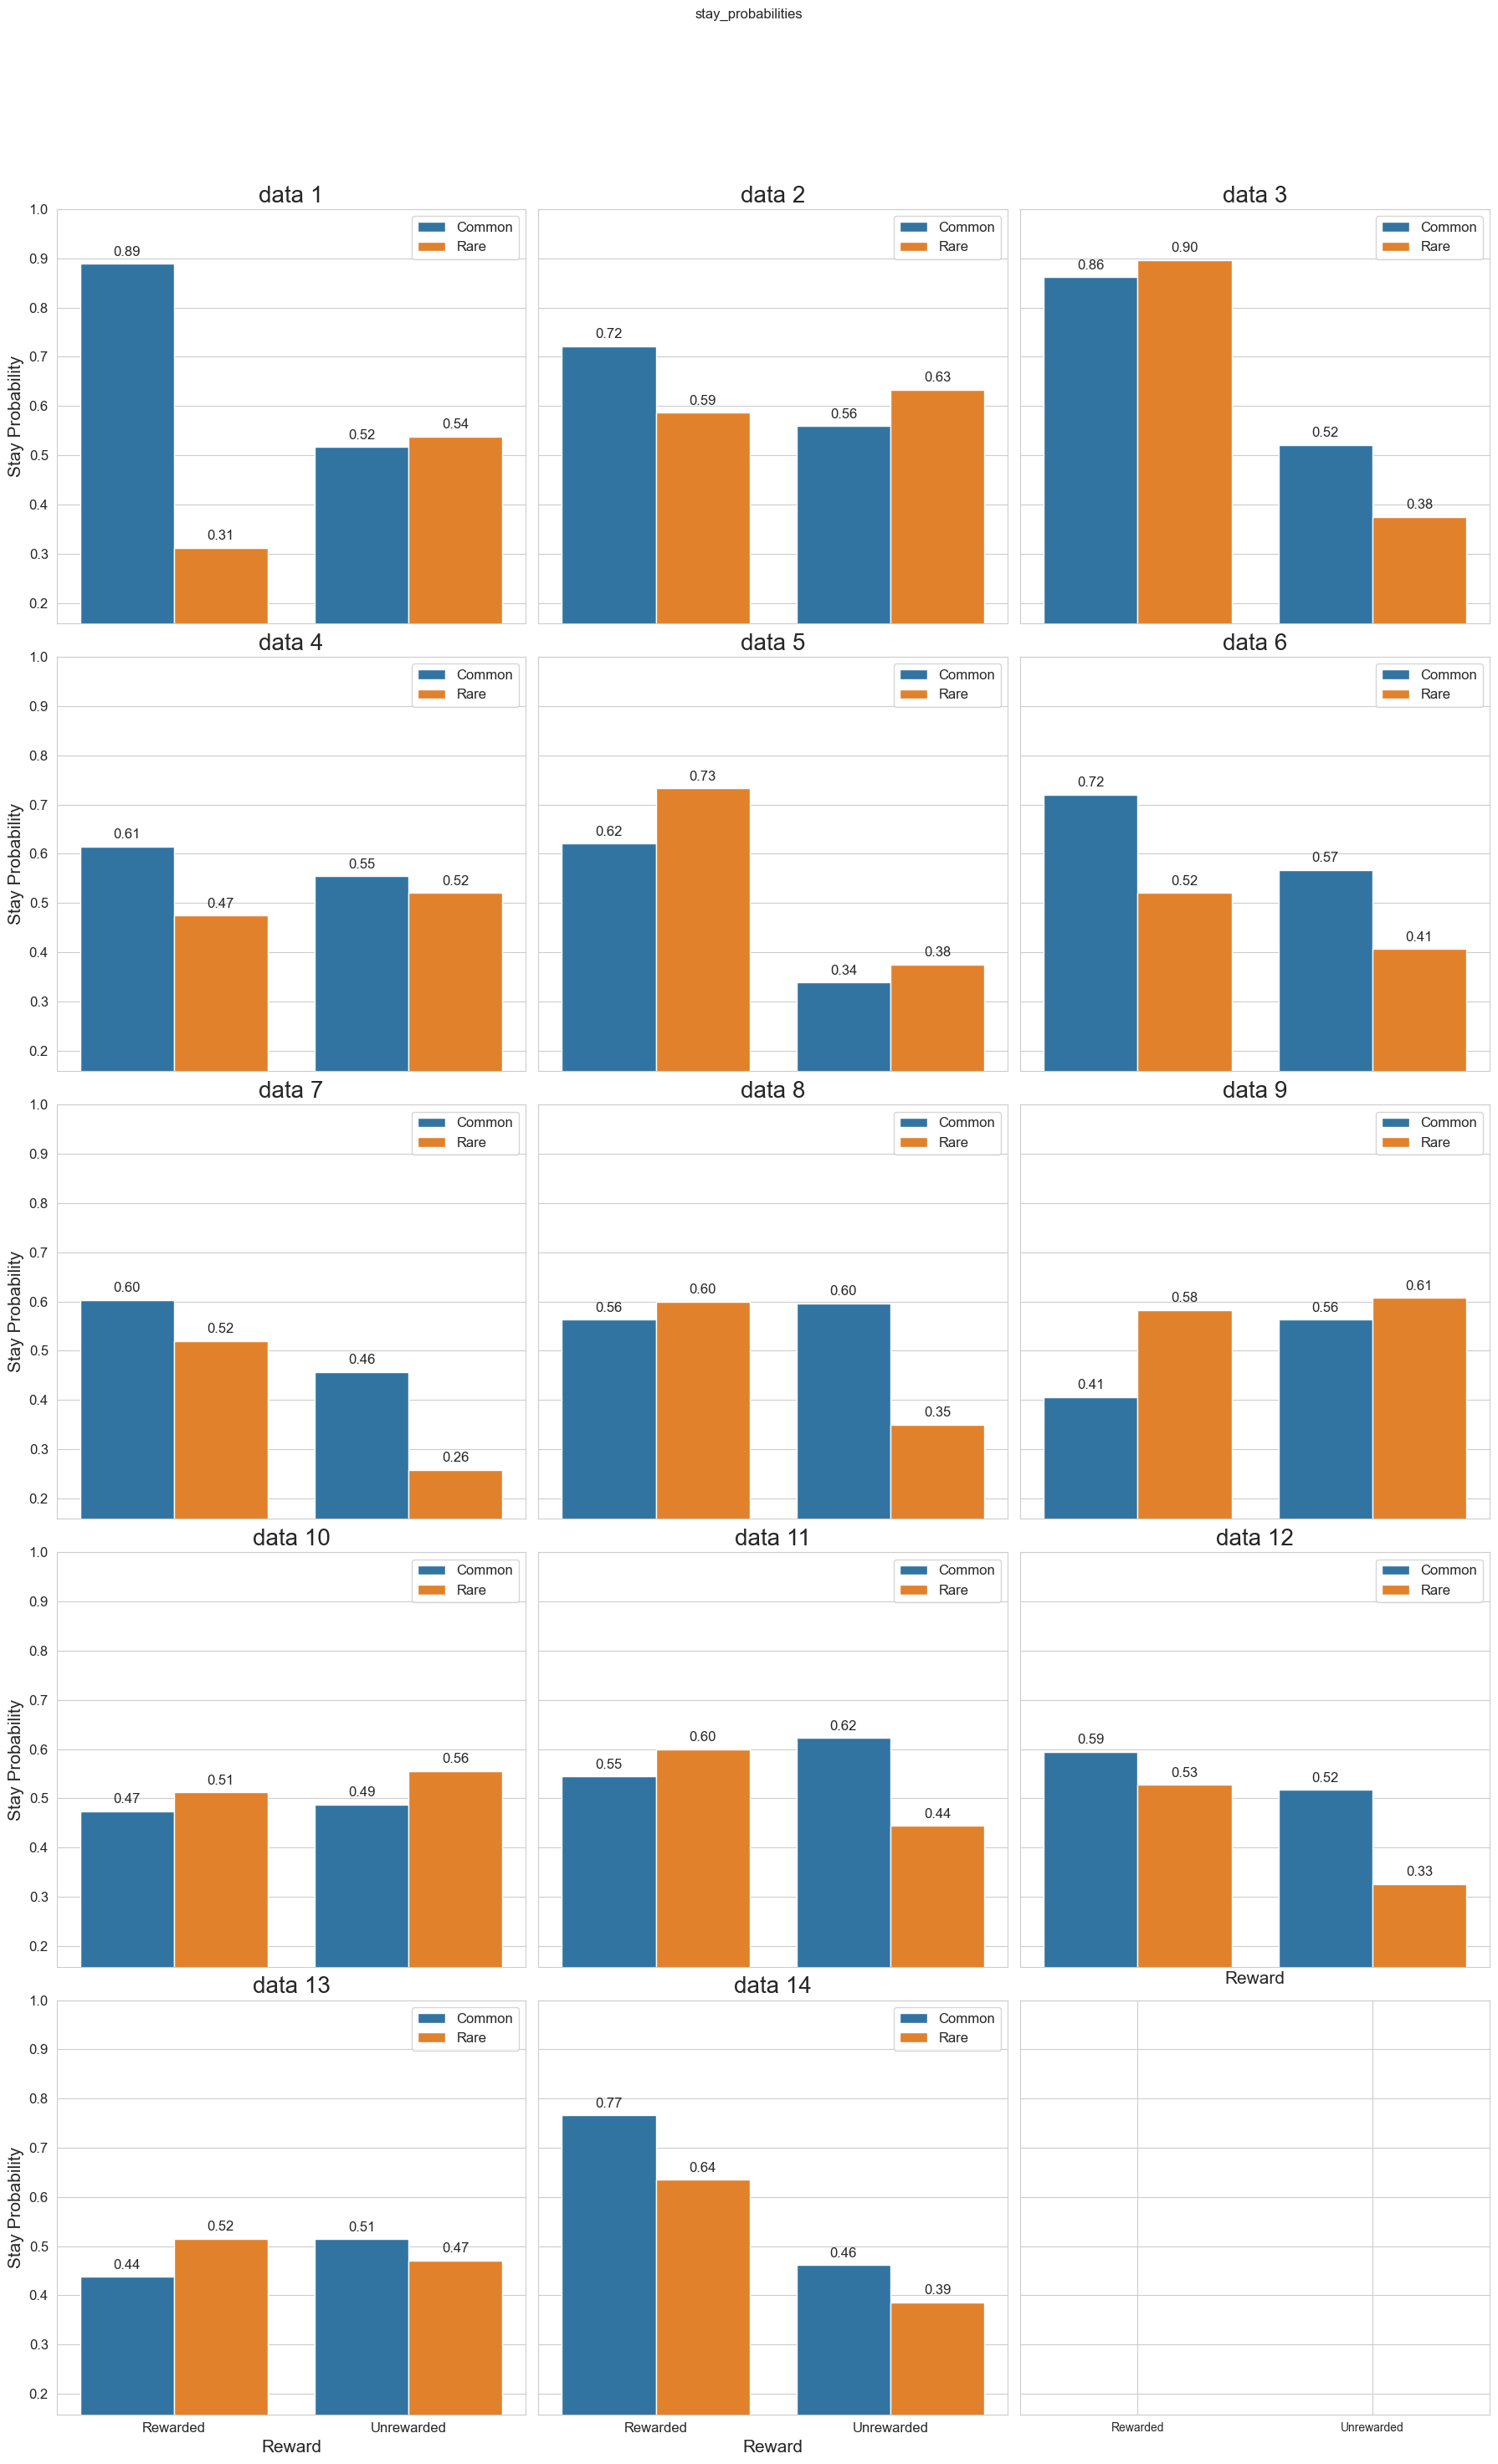

In [152]:

all_participant_data = data_g_all

stay_probabilities = calc_plot_stay_probabilities(dfs=all_participant_data, title='stay_probabilities', max_plots_per_row=3) 

Here we use low number of iterations since it's only for demonstration purposes <br>
In last part, we will fit all models to all participants with the best suited fitting procedure.

In [153]:
# pick a participant to fit the model to
data_index = 6
data = all_participant_data[data_index]

NUM_ITERATIONS = 1000  # Number of iterations for random search
CONSIDER_BOTH_STAGES = True  # Consider both stage 1 and stage 2 behavior for fitting

INTERPOLATION_STEPS = 21 # Number of steps for interpolation of the parameter space
# define the parameter space for the simple model free and based
ALPHA_RANGE = (0.05, 0.85)
BETA_RANGE = (-4, 8)
# Define parameter distributions for hybrid model and its tow special cases (model free and model based)
ALPHA_1_RANGE = (0.05, 0.85)
ALPHA_2_RANGE = (0.05, 0.85)
BETA_1_RANGE = (-4, 8)
BETA_2_RANGE = (-4, 8)
LAMBDA_RANGE = (0.1, 0.9)
W_RANGE = (0, 1)
P_RANGE = (-0.5, 0.5)

parammeter_space = {'alpha': np.linspace(*ALPHA_RANGE, INTERPOLATION_STEPS),
                    'beta':  np.linspace(*BETA_RANGE, INTERPOLATION_STEPS)}

param_space_hybrid = {
    'alpha_1': np.linspace(*ALPHA_1_RANGE, INTERPOLATION_STEPS),
    'alpha_2': np.linspace(*ALPHA_2_RANGE, INTERPOLATION_STEPS),
    'beta_1': np.linspace(*BETA_1_RANGE, INTERPOLATION_STEPS),
    'beta_2': np.linspace(*BETA_2_RANGE, INTERPOLATION_STEPS),
    '_lambda': np.linspace(*LAMBDA_RANGE, INTERPOLATION_STEPS),
    'w': np.linspace(*W_RANGE, INTERPOLATION_STEPS),
    'p': np.linspace(*P_RANGE, INTERPOLATION_STEPS),
}

# param space for hybrid special cases
# pure model free from hybrid -> w = 0
param_space_hybrid_mf = param_space_hybrid.copy() 
param_space_hybrid_mf['w'] = np.array([0.0])

# pure model based from hybrid -> w = 1 and alpha_1 and lambda are arbitrary so we fix them as well to avoid wasting time fitting them 
param_space_hybrid_mb = param_space_hybrid.copy()
param_space_hybrid_mb['w'] = np.array([1.0])
param_space_hybrid_mb['alpha_1'] = np.array([1.0])
param_space_hybrid_mb['_lambda'] = np.array([1.0])

#### Log Likelihood Calculation

In [154]:
def get_action_probs(agent=None, state=None):
    if agent is None:
      return np.random.uniform(size=2)

    return agent.get_action_probabilities(state)

def log_likelihood(agent, data, consider_both_stages=True, verbose=False, show_progress=False):
    LogLikelihood_sum = 0
    for idx, trial_data in tqdm(data.iterrows(), desc='log_likelihood:', total=len(data), disable=not show_progress, leave=False):
        chosen_action_1 = trial_data['stepOneChoice']
        chosen_action_2 = trial_data['stepTwoChoice']
        stage_1_state = 0
        stage_2_state = trial_data['state_transition_to']
        recieved_reward = int(trial_data['reward'])

        action_probs_stage_1 = get_action_probs(agent, stage_1_state)
        chosen_action_1_prob = action_probs_stage_1[chosen_action_1]
        agent.update_beliefs(stage_1_state, chosen_action_1, 0, stage_2_state, False)

        action_probs_stage_2 = get_action_probs(agent, stage_2_state)
        chosen_action_2_prob = action_probs_stage_2[chosen_action_2]
        agent.update_beliefs(stage_2_state, chosen_action_2, recieved_reward, stage_2_state, True)

        # calculate the log likelihood
        # based on only the first stage stage
        LogLikelihood_sum += np.log(chosen_action_1_prob)

        if consider_both_stages:
            # based on both stages
            # assuming the actions are independent following the Markov property
            # P(a1, a2) = P(a1) * P(a2)
            # -> log(P(a1, a2)) = log(P(a1)) + log(P(a2))
            LogLikelihood_sum += np.log(chosen_action_2_prob)

        # print everything for debugging
        if verbose:
            print(f'reward recieved: {recieved_reward}')
            print(f'chosen_action_1: {chosen_action_1}')
            print(f'chosen_action_2: {chosen_action_2}')
            print(f'stage_2_state: {stage_2_state}')
            print(f'action_probs_stage_1: {action_probs_stage_1}')
            print(f'action_probs_stage_2: {action_probs_stage_2}')
            print(f'q_table: {agent.q_table}')
            if hasattr(agent, 'transition_model'):
                print(f'transition_matrix: {agent.transition_model[0]}')
            print('#'*50)

    return LogLikelihood_sum

#### Grid Search, Random Search and MCMC Sampling

In [155]:
from itertools import product
from sklearn.model_selection import ParameterSampler

def create_agent(agent_type, params):
    if agent_type == 'model_free':
        agent = AgentModelFree(TwoStepEnv.action_space, TwoStepEnv.state_space, **params)
    elif agent_type == 'model_based':
        agent = AgentModelBased(TwoStepEnv.action_space, TwoStepEnv.state_space, **params)
    elif agent_type == 'hybrid' or agent_type.startswith('hybrid'):
        agent = HybridAgent(TwoStepEnv.action_space, TwoStepEnv.state_space, **params)
    else:
        agent = RandomAgent(TwoStepEnv.action_space, TwoStepEnv.state_space)
    return agent

def get_best_params_and_ll(results_df):
    # Sort the dataframe and get first row
    sorted_df = results_df.sort_values(by='log_likelihood', ascending=False)
    best_parameters_row = sorted_df.iloc[0]

    # Extract the best parameters and log likelihood
    best_params = best_parameters_row.drop('log_likelihood').to_dict()
    best_log_likelihood = best_parameters_row['log_likelihood']

    return best_params, best_log_likelihood

def fit_with_grid_search(parammeter_space: dict, data, agent_type, consider_both_stages=True,
                        verbose=False, show_progress=False):
    param_names = list(parammeter_space.keys())
    param_combinations = list(product(*parammeter_space.values()))
    LL_results = np.zeros(len(param_combinations))
    
    for idx, param_vals in tqdm(enumerate(param_combinations), desc='grid_search:', total=len(param_combinations), disable=not show_progress, leave=True):
        param_dict = dict(zip(param_names, param_vals))
        agent = create_agent(agent_type, param_dict)
        LL_results[idx] = log_likelihood(agent, data, consider_both_stages, verbose)
    
    # Reshape the results to fit the dimensions of the parameter space
    shape_dims = [len(values) for values in parammeter_space.values()]
    LL_results = LL_results.reshape(*shape_dims)
    # get the best parameters and the best LL
    best_params_idx = np.unravel_index(LL_results.argmax(), LL_results.shape)
    best_params = {param: parammeter_space[param][best_params_idx[i]] for i, param in enumerate(parammeter_space.keys())}
    best_LL = LL_results[best_params_idx]
    return best_params, best_LL, LL_results

def fit_with_random_search(param_space:dict, data, agent_type, num_iterations=100,consider_both_stages=True, seed=0,
                           verbose=False, show_progress=False):
    # convert the parameter space to a format that can be used by ParameterSampler
    # scipy.stats.uniform ->  (loc, loc + scale)
    param_distribution = {param: uniform(np.min(param_space[param]), np.max(param_space[param]) - np.min(param_space[param]))
                    for param in param_space.keys()}
    # Generate parameter samples
    param_list = list(ParameterSampler(param_distribution, n_iter=num_iterations, random_state=seed))

    # Initialize an empty list for the results
    sampled_results = []

    # Evaluate log likelihood for sampled parameter sets
    for params in tqdm(param_list, desc='random_search:', total=len(param_list), disable=not show_progress, leave=True):
        agent = create_agent(agent_type, params)
        log_likelihood_value = log_likelihood(agent, data, consider_both_stages)
        sampled_results.append({**params, 'log_likelihood': log_likelihood_value})

    # Convert to DataFrame
    results_df = pd.DataFrame(sampled_results)
    # get the best parameters and the best LL
    best_params, best_LL = get_best_params_and_ll(results_df)
    return best_params, best_LL, results_df

def fit_with_MCMC(parammeter_space: dict, data, agent_type, consider_both_stages=True, num_samples=1000, num_burn_in=1000,
                    verbose=False, show_progress=False):
    sampling_sd = 0.1
    param_names = list(parammeter_space.keys())
    param_bounds = [(np.min(parammeter_space[param]),np.max(parammeter_space[param])) for param in param_names]

    def log_likelihood_function(params):
        # create the parameter dictionary
        params = dict(zip(param_names, params))
        agent = create_agent(agent_type, params)
        return log_likelihood(agent, data, consider_both_stages)
    
    samples = np.zeros((num_samples, len(param_names)))
    initial_guess = [np.mean(bounds) for bounds in param_bounds] # initial guess varaiable to keep the code readable
    current_params = np.array(initial_guess)
    log_likelihood_values = []
    for i in tqdm(range(num_samples + num_burn_in), desc='MCMC:', total=num_samples + num_burn_in, disable=not show_progress, leave=True):
        # sample new parameters
        new_params = np.random.normal(current_params, scale=sampling_sd, size=current_params.shape)
        # bound the parameters to the parameter space
        new_params = np.clip(new_params, [bound[0] for bound in param_bounds], [bound[1] for bound in param_bounds])
        # calculate the log likelihood for the new parameters
        log_likelihood_current = log_likelihood_function(current_params)
        log_likelihood_new = log_likelihood_function(new_params)
        # calculate the acceptance probability
        accept_prob = np.exp(log_likelihood_new - log_likelihood_current)
        # accept or reject the new parameters
        if log_likelihood_new > log_likelihood_current or np.random.rand() < accept_prob:
            current_params = new_params
            if i >= num_burn_in:
                log_likelihood_values.append(log_likelihood_new)
        elif i >= num_burn_in:
            log_likelihood_values.append(log_likelihood_current)
        # store the parameters after the burn in period
        if i >= num_burn_in:
            samples[i - num_burn_in] = current_params
    # Convert to DataFrame
    results_df = pd.DataFrame(samples, columns=param_names)
    results_df['log_likelihood'] = log_likelihood_values
    # get the best parameters and the best LL
    best_params, best_LL = get_best_params_and_ll(results_df)
    return best_params, best_LL, results_df

### Fit the Models to the Human Data Using Grid Search, Random Search and MCMC Sampling

In [156]:
gs_fitted_params_mf, gs_fitted_LL_mf, gs_fitted_results_mf = fit_with_grid_search(parammeter_space, data, agent_type='model_free',
                                            consider_both_stages=CONSIDER_BOTH_STAGES)

In [157]:
gs_fitted_params_mb, gs_fitted_LL_mb, gs_fiited_results_mb = fit_with_grid_search(parammeter_space, data, agent_type='model_based',
                                            consider_both_stages=CONSIDER_BOTH_STAGES)

In [158]:
# Use random search for fitting the hybrid model as it has too many parameters. Grid search would be impossible
np.random.seed(None)
random_seed = np.random.randint(0, 1000)

rs_fitted_params_hybrid, rs_fitted_LL_hybrid, rs_fitted_results_hybrid = fit_with_random_search(param_space_hybrid, data, agent_type='hybrid',
                                            consider_both_stages=CONSIDER_BOTH_STAGES, num_iterations=NUM_ITERATIONS, seed=random_seed, show_progress=True)

np.random.seed(None)

random_search:: 100%|██████████| 1000/1000 [00:26<00:00, 37.26it/s]


In [159]:
np.random.seed(None)
random_seed = np.random.randint(0, 1000)

rs_fitted_params_hybrid_mf, rs_fitted_LL_hybrid_mf, rs_fitted_results_hybrid_mf = fit_with_random_search(param_space_hybrid_mf, data, agent_type='hybrid',
                                            consider_both_stages=CONSIDER_BOTH_STAGES, num_iterations=NUM_ITERATIONS, seed=random_seed, show_progress=True)

np.random.seed(None)

random_search:: 100%|██████████| 1000/1000 [00:26<00:00, 37.69it/s]


In [160]:
np.random.seed(None)
random_seed = np.random.randint(0, 1000)

rs_fitted_params_hybrid_mb, rs_fitted_LL_hybrid_mb, rs_fitted_results_hybrid_mb = fit_with_random_search(param_space_hybrid_mb, data, agent_type='hybrid',
                                            consider_both_stages=CONSIDER_BOTH_STAGES, num_iterations=NUM_ITERATIONS*2, seed=random_seed, show_progress=True)

np.random.seed(None)

random_search:: 100%|██████████| 2000/2000 [00:54<00:00, 36.95it/s]


In [161]:
mcmc_fitted_params_hybrid, mcmc_fitted_LL_hybrid, mcmc_fitted_results_hybrid = fit_with_MCMC(param_space_hybrid, data, agent_type='hybrid',
                                            consider_both_stages=CONSIDER_BOTH_STAGES, num_samples=NUM_ITERATIONS*4, num_burn_in=NUM_ITERATIONS, show_progress=True)

MCMC:: 100%|██████████| 5000/5000 [04:35<00:00, 18.13it/s]


In [162]:
mcmc_fitted_params_hybrid_mf, mcmc_fitted_LL_hybrid_mf, mcmc_fitted_results_hybrid_mf = fit_with_MCMC(param_space_hybrid_mf, data, agent_type='hybrid',
                                            consider_both_stages=CONSIDER_BOTH_STAGES, num_samples=NUM_ITERATIONS*2, num_burn_in=NUM_ITERATIONS//2, show_progress=True)

MCMC:: 100%|██████████| 2500/2500 [02:17<00:00, 18.21it/s]


In [163]:
mcmc_fitted_params_hybrid_mb, mcmc_fitted_LL_hybrid_mb, mcmc_fitted_results_hybrid_mb = fit_with_MCMC(param_space_hybrid_mb, data, agent_type='hybrid',
                                            consider_both_stages=CONSIDER_BOTH_STAGES, num_samples=NUM_ITERATIONS*2, num_burn_in=NUM_ITERATIONS//2, show_progress=True)

MCMC:: 100%|██████████| 2500/2500 [02:07<00:00, 19.60it/s]


In [164]:
# Print results of the fitting procedures
sep = "\n"
end = "\n" + "-" * 50 + "\n"
print("### simple model free (grid search):", 'best params:', gs_fitted_params_mf, "best_LL:", gs_fitted_LL_mf, sep=sep, end=end)
print("### simple model based (grid search):", 'best params:', gs_fitted_params_mb, "best_LL:", gs_fitted_LL_mb, sep=sep, end=end)
print("### hybrid (random search):", 'best params:', rs_fitted_params_hybrid, "best_LL:", rs_fitted_LL_hybrid, sep=sep, end=end)
print("### hybrid mf (random search):", 'best params:', rs_fitted_params_hybrid_mf, "best_LL:", rs_fitted_LL_hybrid_mf, sep=sep, end=end)
print("### hybrid mb (random search):", 'best params:', rs_fitted_params_hybrid_mb, "best_LL:", rs_fitted_LL_hybrid_mb, sep=sep, end=end)
print("### hybrid (MCMC):", 'best params:', mcmc_fitted_params_hybrid, "best_LL:", mcmc_fitted_LL_hybrid, sep=sep, end=end)
print("### hybrid mf (MCMC):", 'best params:', mcmc_fitted_params_hybrid_mf, "best_LL:", mcmc_fitted_LL_hybrid_mf, sep=sep, end=end)
print("### hybrid mb (MCMC):", 'best params:', mcmc_fitted_params_hybrid_mb, "best_LL:", mcmc_fitted_LL_hybrid_mb, sep=sep, end=end)

# put all results in a dataframe
all_fitted_params_hybrid = [rs_fitted_params_hybrid, rs_fitted_params_hybrid_mf, rs_fitted_params_hybrid_mb,
                            mcmc_fitted_params_hybrid, mcmc_fitted_params_hybrid_mf, mcmc_fitted_params_hybrid_mb]
all_fitted_LL_hybrid = [rs_fitted_LL_hybrid, rs_fitted_LL_hybrid_mf, rs_fitted_LL_hybrid_mb,
                        mcmc_fitted_LL_hybrid, mcmc_fitted_LL_hybrid_mf, mcmc_fitted_LL_hybrid_mb]
all_model_names_hybrid = ['hybrid', 'hybrid_mf', 'hybrid_mb', 'hybrid', 'hybrid_mf', 'hybrid_mb']
all_fitting_procedures_hybrid = ['random_search', 'random_search', 'random_search', 'MCMC', 'MCMC', 'MCMC']
all_fitted_params_simple = [gs_fitted_params_mf, gs_fitted_params_mb]
all_fitted_LL_simple = [gs_fitted_LL_mf, gs_fitted_LL_mb]
all_names_simple = ['model_free', 'model_based']
all_fitting_procedures_simple = ['grid_search', 'grid_search']

# For simple models
params_df_simple = pd.DataFrame(all_fitted_params_simple)
fit_results_simple_models = pd.DataFrame({
    "Model Type": all_names_simple,
    "Fitting Procedure": all_fitting_procedures_simple,
    "Best LL": all_fitted_LL_simple
})
fit_results_simple_models = pd.concat([fit_results_simple_models, params_df_simple], axis=1)

# For hybrid models
params_df_hybrid = pd.DataFrame(all_fitted_params_hybrid)
fit_results_hybrid_models = pd.DataFrame({
    "Model Type": all_model_names_hybrid,
    "Fitting Procedure": all_fitting_procedures_hybrid,
    "Best LL": all_fitted_LL_hybrid
})
fit_results_hybrid_models = pd.concat([fit_results_hybrid_models, params_df_hybrid], axis=1)

display(fit_results_simple_models)
display(fit_results_hybrid_models)


### simple model free (grid search):
best params:
{'alpha': 0.16999999999999998, 'beta': 1.3999999999999995}
best_LL:
-272.9303723686635
--------------------------------------------------
### simple model based (grid search):
best params:
{'alpha': 0.20999999999999996, 'beta': 1.3999999999999995}
best_LL:
-273.33076370194107
--------------------------------------------------
### hybrid (random search):
best params:
{'_lambda': 0.7604545192434002, 'alpha_1': 0.7905985370321573, 'alpha_2': 0.3306118209505244, 'beta_1': 1.2278773046395983, 'beta_2': 1.049951737759037, 'p': 0.04602920855597159, 'w': 0.9710403138678393}
best_LL:
-273.95258354761233
--------------------------------------------------
### hybrid mf (random search):
best params:
{'_lambda': 0.1382094250608545, 'alpha_1': 0.4199837281889083, 'alpha_2': 0.3582219606613101, 'beta_1': 0.03442287931405197, 'beta_2': 0.787563955521069, 'p': 0.1441003614619718, 'w': 0.0}
best_LL:
-274.0426394789957
------------------------------------

,Model Type,Fitting Procedure,Best LL,alpha,beta
0,model_free,grid_search,-272.930372,0.17,1.4
1,model_based,grid_search,-273.330764,0.21,1.4


,Model Type,Fitting Procedure,Best LL,_lambda,alpha_1,alpha_2,beta_1,beta_2,p,w
0,hybrid,random_search,-273.952584,0.760455,0.790599,0.330612,1.227877,1.049952,0.046029,0.97104
1,hybrid_mf,random_search,-274.042639,0.138209,0.419984,0.358222,0.034423,0.787564,0.144100,0.00000
2,hybrid_mb,random_search,-273.932055,1.000000,1.000000,0.200674,1.584223,1.390571,-0.073682,1.00000
3,hybrid,MCMC,-271.444026,0.289591,0.144733,0.253593,1.526889,1.231498,-0.142587,0.00000
4,hybrid_mf,MCMC,-270.670074,0.812652,0.655568,0.409250,0.521672,1.090116,-0.212705,0.00000
5,hybrid_mb,MCMC,-273.638516,1.000000,1.000000,0.256447,1.103757,1.145883,-0.018115,1.00000


#### Plotting the Results of Parameter Fitting

In [165]:
# plot heatmap for 1 param
def plot_fit_results_1d(LL_results:np.ndarray, parameter_space:dict, full=False, title='', save=False, filename='plots/fit_results.png'):
    param_name, param_space = list(parameter_space.items())[0]
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle(title)
    ax.plot(param_space, LL_results)
    ax.set_xlabel(param_name)
    ax.set_ylabel('Log Likelihood')
    ax.set_title('Log Likelihood of human data given model')
    fig.tight_layout()
    plt.show()
    if save:
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        # add timestamp to filename
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = filename.replace('.png', f'_{timestamp}.png')
        fig.savefig(filename)
        print(f'Plot saved to {filename}')

# plot results of fitting on a 2D surface - 2 parameters (one on each axis)
def plot_fit_results_2d(LL_results, parameter_space:dict, full=False, title='', save=False, filename='plots/fit_results.png'):
    if len(parameter_space) != 2:
        raise ValueError(f'This function is only for 2D parameter spaces, provided {len(parameter_space)}D')
    
    seperated_param_space = list(parameter_space.items())
    param_1, param_1_space = seperated_param_space[0]
    param_2, param_2_space = seperated_param_space[1]
    
    if full:
        # plot the log likelihoods for each parameter value across the other parameter
        fig, (ax_1, ax_2) = plt.figure(nrows=1, ncols=2, figsize=(10, 6))
        for idx, val in enumerate(param_1_space):
            ax_1.plot(param_2_space, LL_results[:,idx], label=f'{param_1} = {val}')
        ax_1.set_xlabel(param_2)
        ax_1.set_ylabel('Log Likelihood')
        ax_1.set_title('Log Likelihood of human data given model')
        ax_1.legend()

        for idx, val in enumerate(param_2_space):
            ax_2.plot(param_1_space, LL_results[idx,:], label=f'{param_2} = {val}')
        ax_2.set_xlabel(param_1)
        ax_2.set_ylabel('Log Likelihood')
        ax_2.set_title('Log Likelihood of human data given model')
        ax_2.legend()

        fig.tight_layout()
        plt.show()
        if save:
            os.makedirs(os.path.dirname(filename), exist_ok=True)
            filename = filename.split('.')[0] + '_full.png'
            # add timestamp to filename
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = filename.replace('.png', f'_{timestamp}.png')
            fig.savefig(filename)
            print(f'Plot saved to {filename}')

    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle(title)

    x_ticks = np.round(param_2_space, 3)
    y_ticks = np.round(param_1_space, 3)
    visible_ticks_x = [x_ticks[0], x_ticks[len(x_ticks) // 2], x_ticks[-1]]
    visible_ticks_y = [y_ticks[0], y_ticks[len(y_ticks) // 2], y_ticks[-1]]

    im = ax.imshow(LL_results, origin='lower', cmap='inferno')

    ax.set_xlabel(param_2)
    ax.set_xticks([0, len(x_ticks) // 2, len(x_ticks) - 1])
    ax.set_xticklabels(visible_ticks_x)
    ax.set_ylabel(param_1)
    ax.set_yticks([0, len(y_ticks) // 2, len(y_ticks) - 1])
    ax.set_yticklabels(visible_ticks_y)
    ax.set_title('Log Likelihoods')

    fig.colorbar(im, ax=ax, label='Log Likelihood')

    # Annotate the maximum log likelihood on the plot
    max_ll_idx = np.unravel_index(np.argmax(LL_results, axis=None), LL_results.shape)
    max_ll = np.round(LL_results[max_ll_idx], 2)
    max_param_1 = np.round(param_1_space[max_ll_idx[0]], 2)
    max_param_2 = np.round(param_2_space[max_ll_idx[1]], 2)

    ax.annotate(f'Max LL={max_ll}\n{param_1}={max_param_1}, {param_2}={max_param_2}',
            xy=(max_ll_idx[1], max_ll_idx[0]),
            xytext=(max_ll_idx[1]+1, max_ll_idx[0]+1),
            arrowprops=dict(facecolor='darkgreen', shrink=0.005), color='darkgreen', zorder=10, textcoords='offset points')
    
    fig.tight_layout()
    plt.show()
    if save:
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        # add timestamp to filename
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = filename.replace('.png', f'_{timestamp}.png')
        fig.savefig(filename)
        print(f'Plot saved to {filename}')
        
def plot_heatmap_slices(LL_results, parameter_space, full=False, title='', save=False, filename='plots/fit_results.png'):
    num_params = len(parameter_space)
    param_names = list(parameter_space.keys())
    param_spaces = [parameter_space[name] for name in param_names]
    
    # Find the indices of the maximum log likelihood
    max_ll_indices = np.unravel_index(np.argmax(LL_results), LL_results.shape)
    # plot the 2D slices for all pairs of parameters and fixed values for the other parameters at the maximum LL
    for i in range(num_params):
        for j in range(i + 1, num_params):
            # Extract the 2D slice for the i-th and j-th parameters
            fixed_params = list(max_ll_indices)
            fixed_params[i] = slice(None)  # All values for the i-th param
            fixed_params[j] = slice(None)  # All values for the j-th param
            slice_ij = LL_results[tuple(fixed_params)]

            # define the 2d parameter space and plot using plot_fit_results_2d
            param_space_ij = {param_names[i]: param_spaces[i], 
                              param_names[j]: param_spaces[j]}
            # pass the fixed parameters and their values as title
            plot_title = f'{title} {param_names[i]}={param_spaces[i][max_ll_indices[i]]}, {param_names[j]}={param_spaces[j][max_ll_indices[j]]}'
            if save:
                filename = filename.split('.')[0] + f'_{param_names[i]}_{param_spaces[i][max_ll_indices[i]]}_{param_names[j]}_{param_spaces[j][max_ll_indices[j]]}.png'
            plot_fit_results_2d(slice_ij, param_space_ij, full, plot_title, save, filename)        

def plot_fit_results(LL_results:np.ndarray, parameter_space:dict, full=False, title='', save=False, filename='plots/fit_results.png'):
    num_params = len(parameter_space)
    if num_params == 1:
        plot_fit_results_1d(LL_results, parameter_space, full=full, title=title, save=save, filename=filename)

    elif num_params == 2:
        plot_fit_results_2d(LL_results, parameter_space, full=full, title=title, save=save, filename=filename)
    
    elif num_params > 2:
        plot_heatmap_slices(LL_results, parameter_space, full=full, title=title, save=save, filename=filename)

    else:
        print(f'parameter space should be of type dict, provided: {type(parameter_space)}')

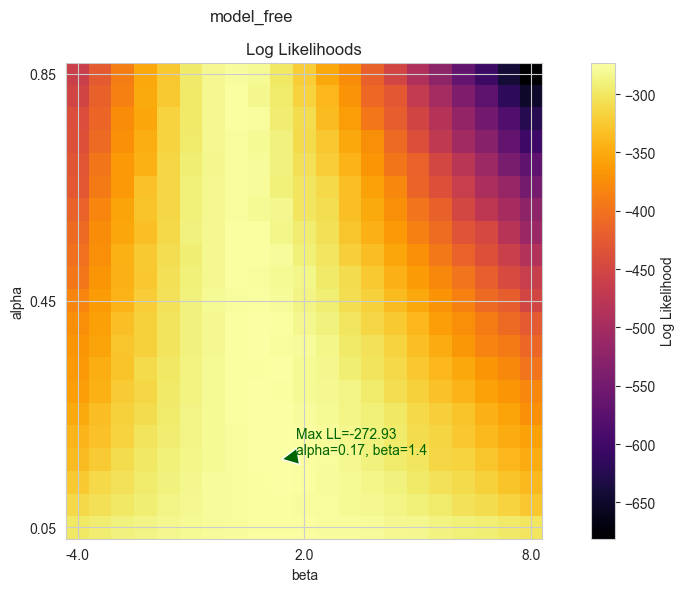

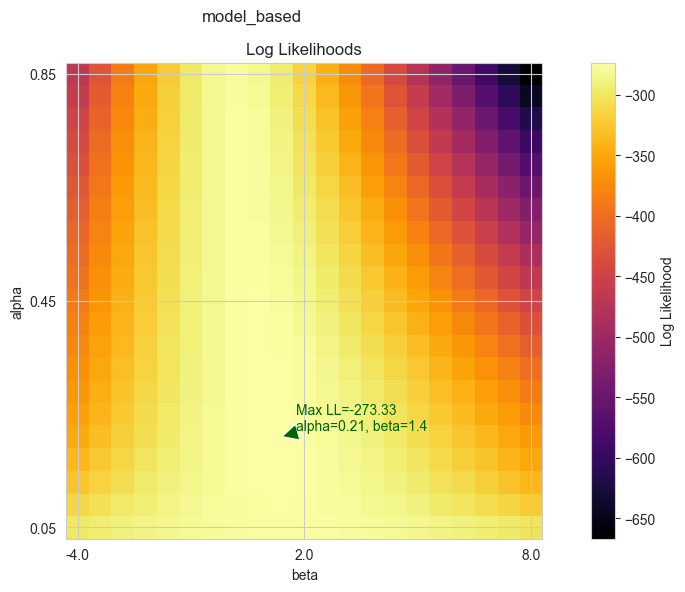

In [166]:
# plot fit results for simple models
plot_fit_results(gs_fitted_results_mf, parammeter_space, title='model_free')
plot_fit_results(gs_fiited_results_mb, parammeter_space, title='model_based')

In [167]:
# get the best parameters for each model 
best_simple_models_params =  fit_results_simple_models.groupby('Model Type').apply(lambda x: x.loc[x['Best LL'].idxmax()]).reset_index(drop=True)
display(best_simple_models_params)
best_hybrid_models_params =  fit_results_hybrid_models.groupby('Model Type').apply(lambda x: x.loc[x['Best LL'].idxmax()]).reset_index(drop=True)
display(best_hybrid_models_params)

,Model Type,Fitting Procedure,Best LL,alpha,beta
0,model_based,grid_search,-273.330764,0.21,1.4
1,model_free,grid_search,-272.930372,0.17,1.4


,Model Type,Fitting Procedure,Best LL,_lambda,alpha_1,alpha_2,beta_1,beta_2,p,w
0,hybrid,MCMC,-271.444026,0.289591,0.144733,0.253593,1.526889,1.231498,-0.142587,0.0
1,hybrid_mb,MCMC,-273.638516,1.000000,1.000000,0.256447,1.103757,1.145883,-0.018115,1.0
2,hybrid_mf,MCMC,-270.670074,0.812652,0.655568,0.409250,0.521672,1.090116,-0.212705,0.0


In [168]:
sample_size = 100
sampled_data_mf = []
sampled_data_mb = []
sampled_data_hybrid = []
sampled_data_hybrid_mf = []
sampled_data_hybrid_mb = []
random_seeds = np.random.randint(100 + sample_size ** 2, size=sample_size)
print('random_seeds:', random_seeds)
for seed in tqdm(random_seeds, desc='Simulating samples'):

    # simulate models with best parameters
    for i, row in best_simple_models_params.iterrows():
        agent_type = row['Model Type']
        params = row[['alpha', 'beta']].to_dict()
        if agent_type == 'model_free':
            data_best_mf, _ = simulate(agent_type=agent_type, params=params, seed=seed, from_data=participant_data, use_reward_distribution=True)
        elif agent_type == 'model_based':
            data_best_mb, _ = simulate(agent_type=agent_type, params=params, seed=seed, from_data=participant_data, use_reward_distribution=True)
    
    for i, row in best_hybrid_models_params.iterrows():
        agent_type = row['Model Type']
        params = row[['alpha_1', 'alpha_2', 'beta_1', 'beta_2', '_lambda', 'w', 'p']].to_dict()
        if agent_type == 'hybrid':
            data_best_hybrid, _ = simulate(agent_type=agent_type, params=params, seed=seed, from_data=participant_data, use_reward_distribution=True)
        elif agent_type == 'hybrid_mf':
            data_best_hybrid_mf, _ = simulate(agent_type=agent_type, params=params, seed=seed, from_data=participant_data, use_reward_distribution=True)
        elif agent_type == 'hybrid_mb':
            data_best_hybrid_mb, _ = simulate(agent_type=agent_type, params=params, seed=seed, from_data=participant_data, use_reward_distribution=True)

    # add to the data
    sampled_data_mf.append(data_best_mf)
    sampled_data_mb.append(data_best_mb)
    sampled_data_hybrid.append(data_best_hybrid)
    sampled_data_hybrid_mf.append(data_best_hybrid_mf)
    sampled_data_hybrid_mb.append(data_best_hybrid_mb)

random_seeds: [3887 9376 8262 1657 9928  731 1211 3210 9565 2217 1318  994 7016 8379
 1973 8085 3833 6534 7494 7151 4814 6193 5646  454 2022 9451 8073 9651
 4646 7439 3297  379 9739 6128 1313 5812 1913  767 7228 9137 7483  918
  279 5379 7719 1328 4868 5930 5946 2250 1188 9800 9556   57 1311 1854
 3470 6393 6337 7990  617 8028 1734 4373 7158 3232 7019 7542 2808 2451
 6322 6089 4941 2960  534 7287 1392 4200 1314 5053 9972 1351 4231 3892
 2681 5051 2215 8652  783 5852  715 7907  428 8585  172 8567 7362  104
 7635 5417]


Simulating samples: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Labels not provided or not matching the number of dataframes, using default labels
generated labels: ['data 1', 'data 2', 'data 3', 'data 4']


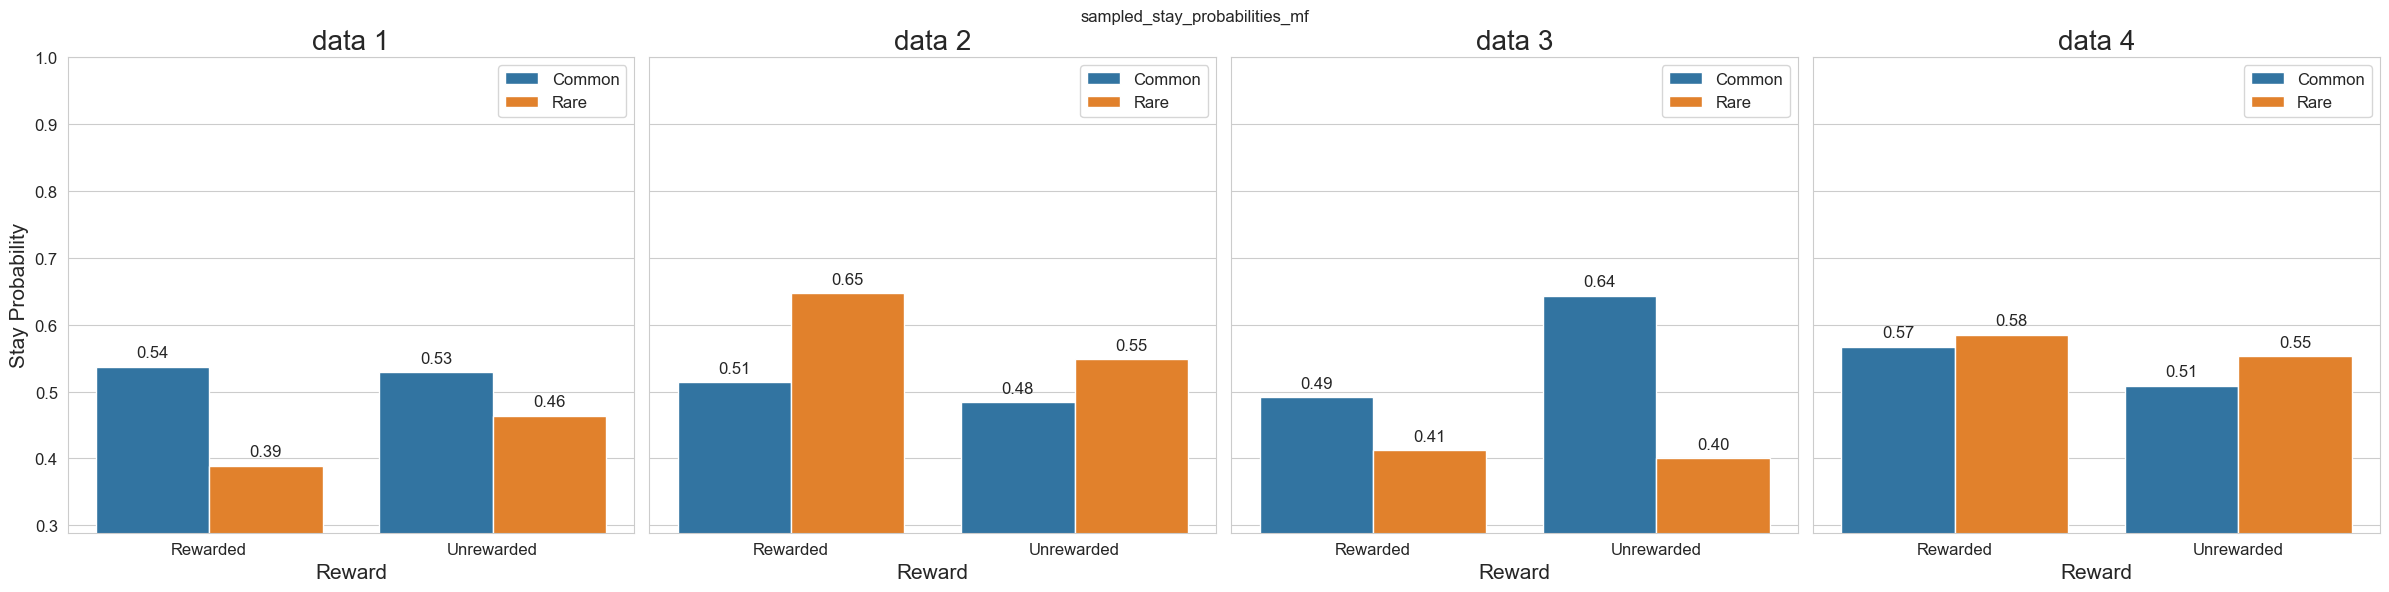

Labels not provided or not matching the number of dataframes, using default labels
generated labels: ['data 1', 'data 2', 'data 3', 'data 4']


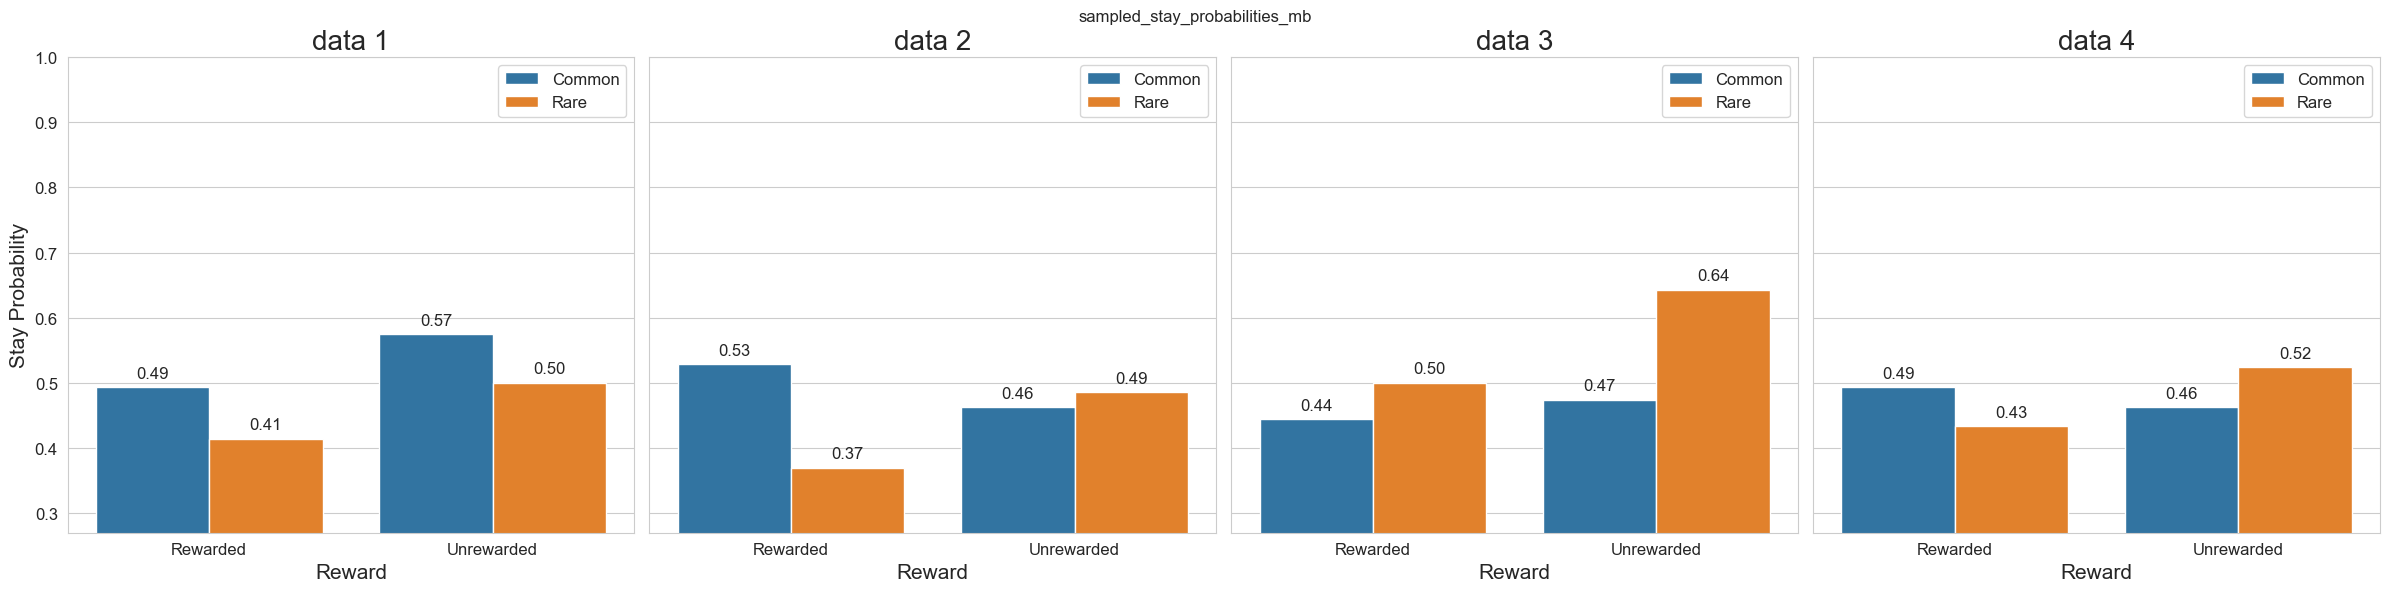

Labels not provided or not matching the number of dataframes, using default labels
generated labels: ['data 1', 'data 2', 'data 3', 'data 4']


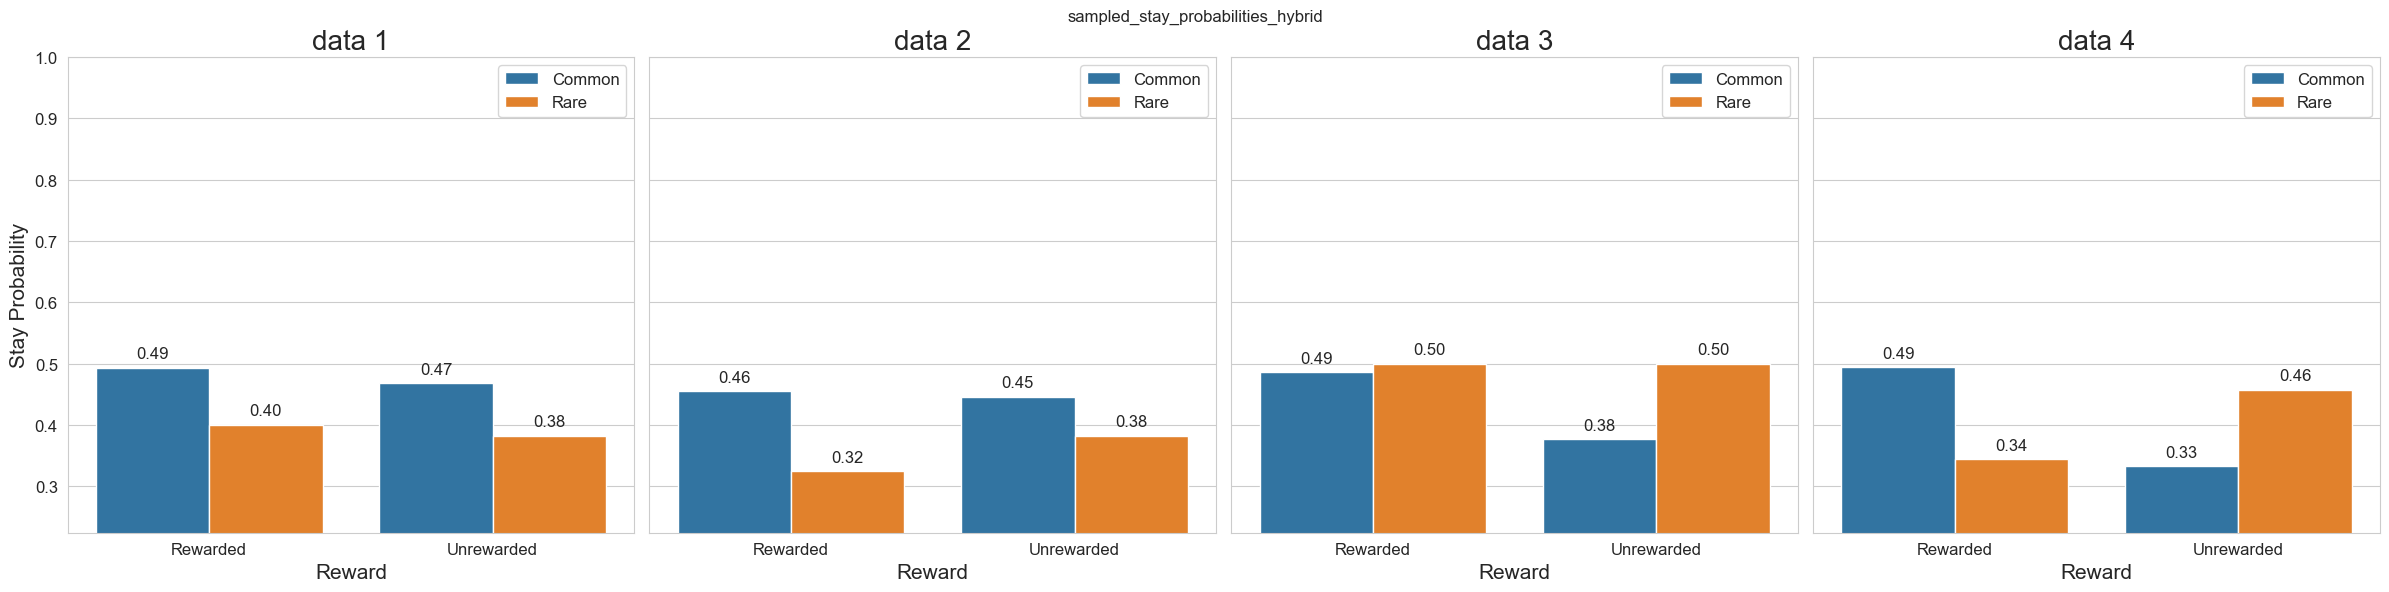

Labels not provided or not matching the number of dataframes, using default labels
generated labels: ['data 1', 'data 2', 'data 3', 'data 4']


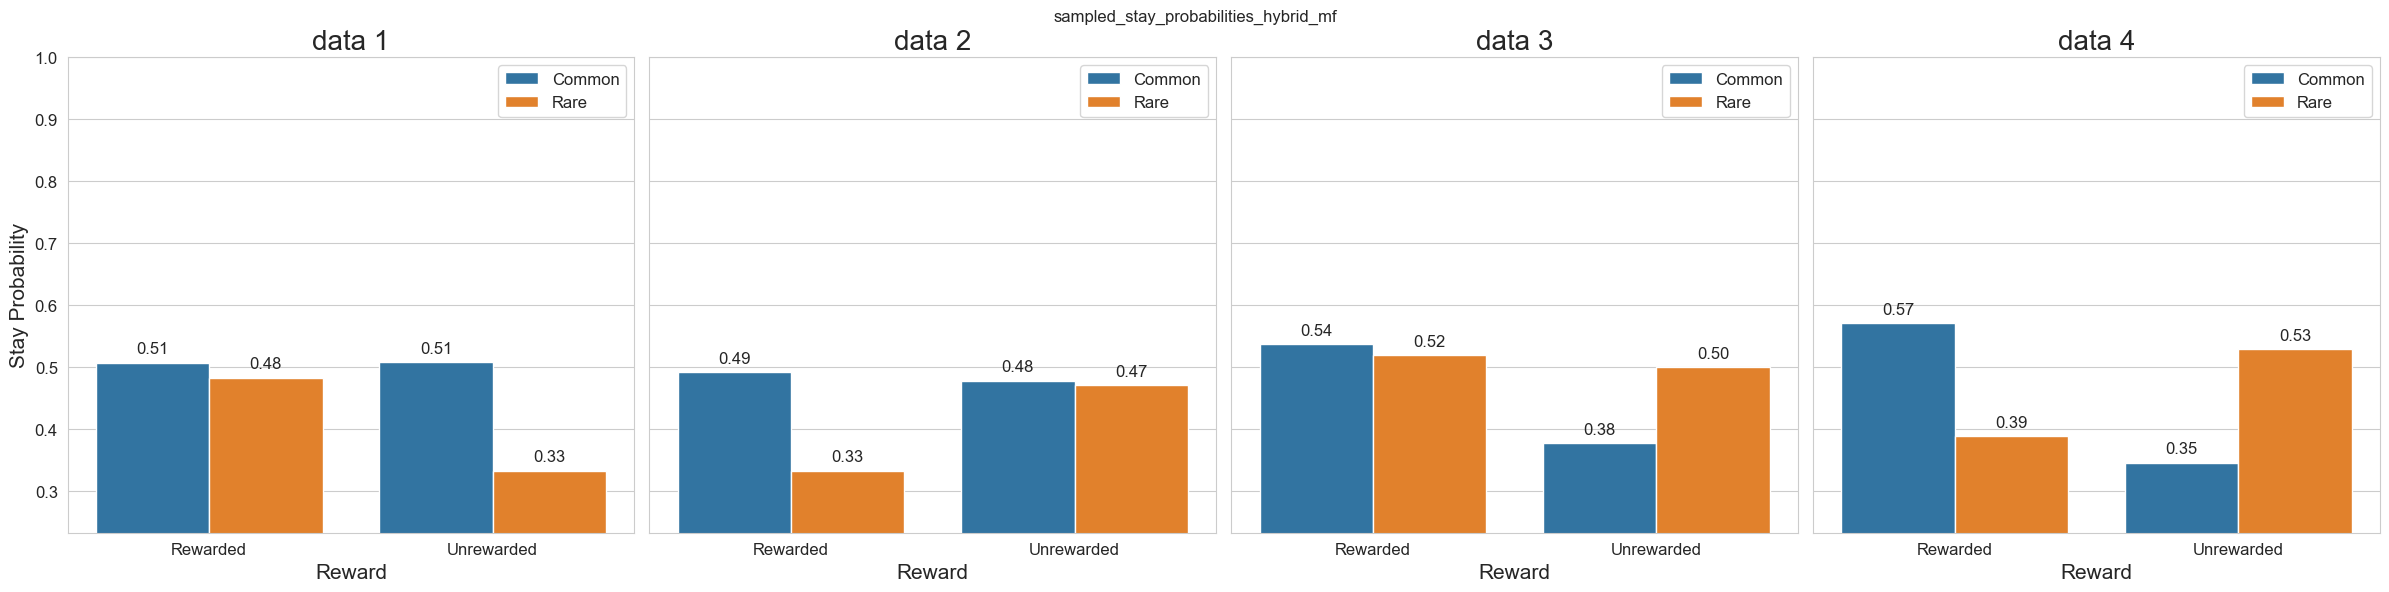

Labels not provided or not matching the number of dataframes, using default labels
generated labels: ['data 1', 'data 2', 'data 3', 'data 4']


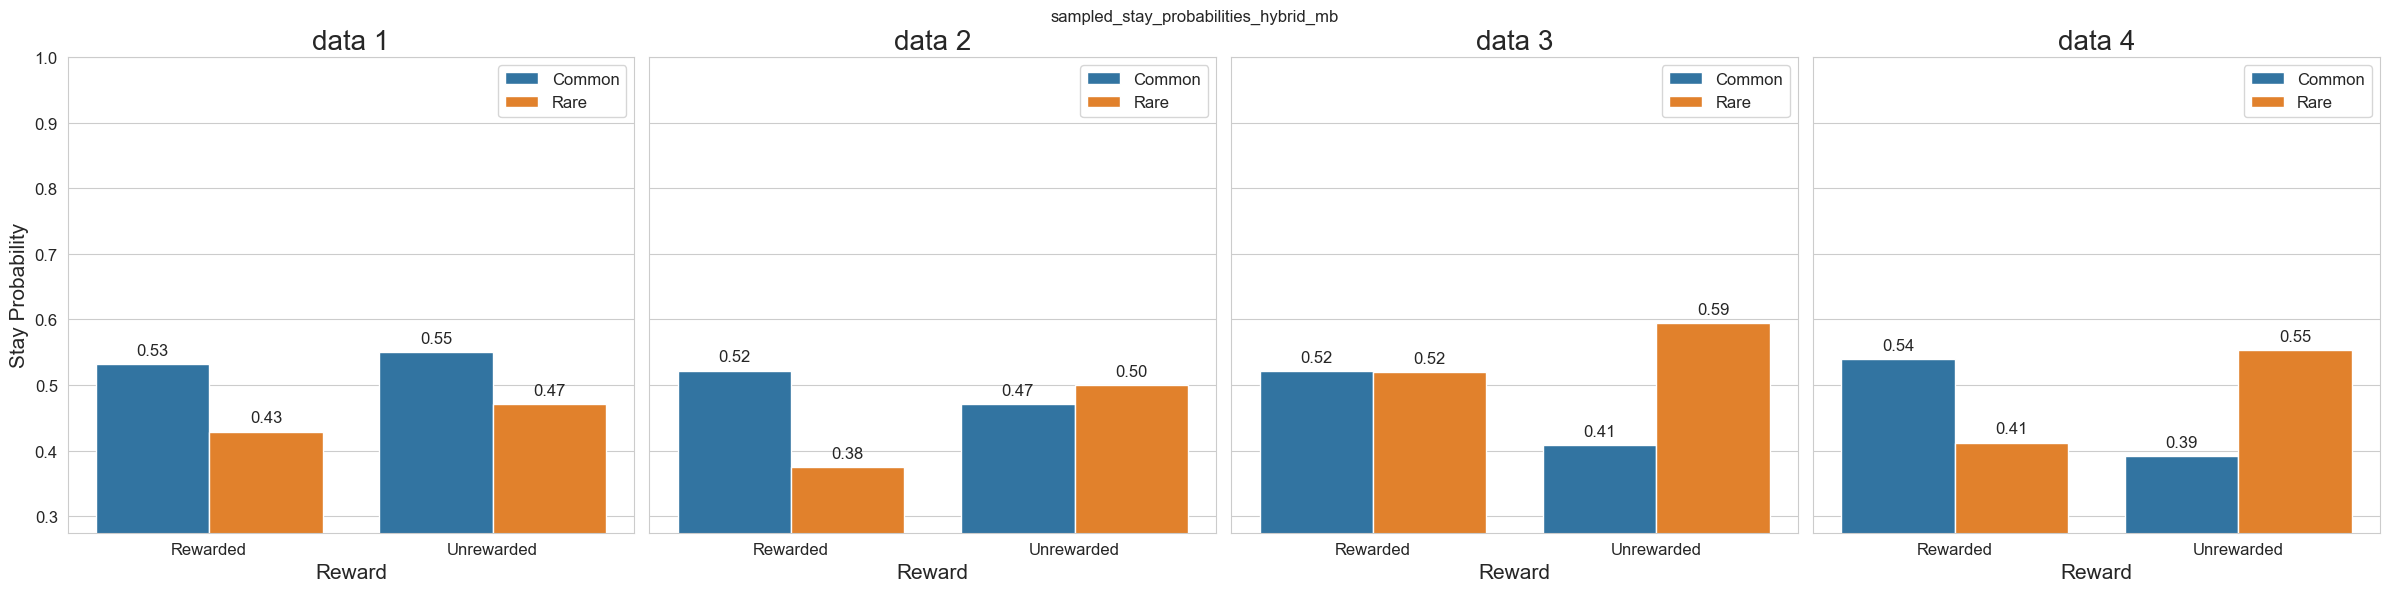

In [169]:
show_n_samples = 4 
sample_stay_prob_mf = calc_plot_stay_probabilities(dfs=sampled_data_mf[::sample_size//show_n_samples], title='sampled_stay_probabilities_mf', max_plots_per_row=4)
sample_stay_prob_mb = calc_plot_stay_probabilities(dfs=sampled_data_mb[::sample_size//show_n_samples], title='sampled_stay_probabilities_mb', max_plots_per_row=4)
sample_stay_prob_hybrid = calc_plot_stay_probabilities(dfs=sampled_data_hybrid[::sample_size//show_n_samples], title='sampled_stay_probabilities_hybrid', max_plots_per_row=4)
sample_stay_prob_hybrid_mf = calc_plot_stay_probabilities(dfs=sampled_data_hybrid_mf[::sample_size//show_n_samples], title='sampled_stay_probabilities_hybrid_mf', max_plots_per_row=4)
sample_stay_prob_hybrid_mb = calc_plot_stay_probabilities(dfs=sampled_data_hybrid_mb[::sample_size//show_n_samples], title='sampled_stay_probabilities_hybrid_mb', max_plots_per_row=4)

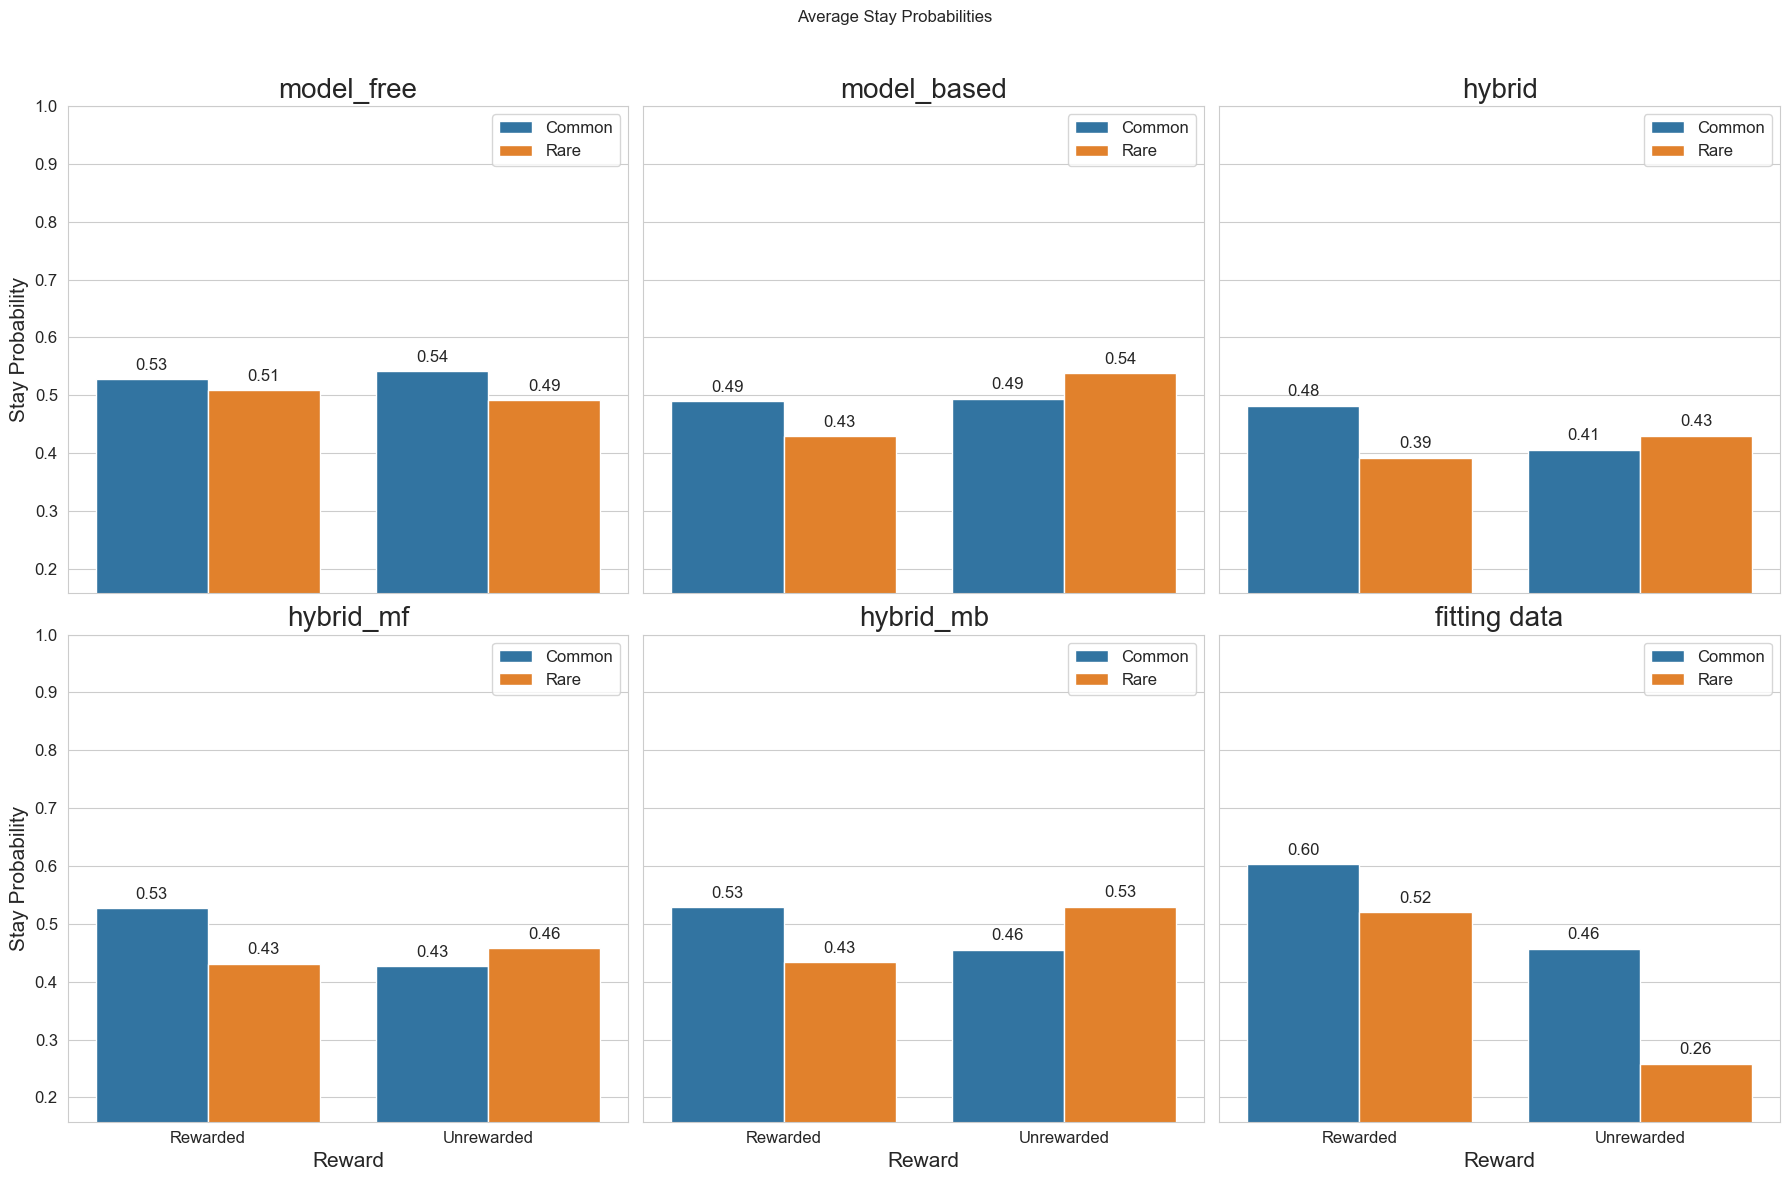

In [170]:
# take the average
all_data_stay_prob_mf_ = pd.concat(sample_stay_prob_mf).reset_index(drop=True)
all_data_stay_prob_mb_ = pd.concat(sample_stay_prob_mb).reset_index(drop=True)
all_data_stay_prob_hybrid_ = pd.concat(sample_stay_prob_hybrid).reset_index(drop=True)
all_data_stay_prob_hybrid_mf_ = pd.concat(sample_stay_prob_hybrid_mf).reset_index(drop=True)
all_data_stay_prob_hybrid_mb_ = pd.concat(sample_stay_prob_hybrid_mb).reset_index(drop=True)
# Compute the average stay probabilities
average_data_mf = all_data_stay_prob_mf_.groupby(['Rewarded', 'Common', 'Condition'])['Stay Probability'].mean().reset_index()
average_data_mb = all_data_stay_prob_mb_.groupby(['Rewarded', 'Common', 'Condition'])['Stay Probability'].mean().reset_index()
average_data_hybrid = all_data_stay_prob_hybrid_.groupby(['Rewarded', 'Common', 'Condition'])['Stay Probability'].mean().reset_index()
average_data_hybrid_mf = all_data_stay_prob_hybrid_mf_.groupby(['Rewarded', 'Common', 'Condition'])['Stay Probability'].mean().reset_index()
average_data_hybrid_mb = all_data_stay_prob_hybrid_mb_.groupby(['Rewarded', 'Common', 'Condition'])['Stay Probability'].mean().reset_index()

# display the average
# display('model_free', average_data_mf)
# display('model_based', average_data_mb)
# display('hybrid', average_data_hybrid)
# display('hybrid_mf', average_data_hybrid_mf)
# display('hybrid_mb', average_data_hybrid_mb)
# plot the average
data_stay_probabilities = calculate_stay_probability(data) 
plot_stay_probabilities(dfs=[average_data_mf, average_data_mb, average_data_hybrid, average_data_hybrid_mf, average_data_hybrid_mb, data_stay_probabilities],
                        labels=['model_free', 'model_based', 'hybrid', 'hybrid_mf', 'hybrid_mb', 'fitting data'],
                        title='Average Stay Probabilities', max_plots_per_row=3)

## Parameter Recovery *(5 points)*

For this exercise you should:

*   Set up a suitable space of parameters relevant for parameter recovery *(1 point)*

*   Use the functions above to generate behavior from a models, for a given set of (randomly sampled) parameters, and then fit the model to its generated data. Make sure to evaluate the parameter fit in a quantiative manner. *(3 points)*

*   Plot the parameter recovery results for both models. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [ ]:
from scipy.stats import uniform

In [ ]:
NUM_RUNS = 20
SEED = 0

NUM_ITERATIONS = 256  # Number of iterations for random search
NUM_INITILIZATIONS = 5  # Number of random initializations for minimize search
CONSIDER_BOTH_STAGES = True
kwargs_for_fitting_functions = {'num_iterations': NUM_ITERATIONS,
                                'num_initializations': NUM_INITILIZATIONS,
                                'consider_both_stages': CONSIDER_BOTH_STAGES}

INTERPOLATION_STEPS = 21 # Number of steps for interpolation of the parameter space
# define the parameter space for the simple model free and based
ALPHA_RANGE = (0.01, 0.8)
BETA_RANGE = (-4, 8)
# Define parameter distributions for hybrid model and its tow special cases (model free and model based)
ALPHA_1_RANGE = (0.01, 0.8)
ALPHA_2_RANGE = (0.01, 0.8)
BETA_1_RANGE = (-4, 8)
BETA_2_RANGE = (-4, 8)
LAMBDA_RANGE = (0, 1)
W_RANGE = (0, 1)
P_RANGE = (-2, 2)

param_space = {'alpha': np.linspace(*ALPHA_RANGE, INTERPOLATION_STEPS),
                'beta': np.linspace(*BETA_RANGE, INTERPOLATION_STEPS)}
param_distributions = {'alpha': uniform(ALPHA_RANGE[0], ALPHA_RANGE[1] - ALPHA_RANGE[0]),
                        'beta': uniform(BETA_RANGE[0], BETA_RANGE[1] - BETA_RANGE[0])}

param_space_hybrid = {
    'alpha_1': np.linspace(*ALPHA_1_RANGE, INTERPOLATION_STEPS),
    'alpha_2': np.linspace(*ALPHA_2_RANGE, INTERPOLATION_STEPS),
    'beta_1': np.linspace(*BETA_1_RANGE, INTERPOLATION_STEPS),
    'beta_2': np.linspace(*BETA_2_RANGE, INTERPOLATION_STEPS),
    '_lambda': np.linspace(*LAMBDA_RANGE, INTERPOLATION_STEPS),
    'w': np.linspace(*W_RANGE, INTERPOLATION_STEPS),
    'p': np.linspace(*P_RANGE, INTERPOLATION_STEPS),
}
# TODO fix the uniform distribution range, it is ( loc , scale + loc )
param_distributions_hybrid = {
    'alpha_1': uniform(ALPHA_1_RANGE[0], ALPHA_1_RANGE[1] - ALPHA_1_RANGE[0]),
    'alpha_2': uniform(ALPHA_2_RANGE[0], ALPHA_2_RANGE[1] - ALPHA_2_RANGE[0]),
    'beta_1': uniform(BETA_1_RANGE[0], BETA_1_RANGE[1] - BETA_1_RANGE[0]),
    'beta_2': uniform(BETA_2_RANGE[0], BETA_2_RANGE[1] - BETA_2_RANGE[0]),
    '_lambda': uniform(LAMBDA_RANGE[0], LAMBDA_RANGE[1] - LAMBDA_RANGE[0]),
    'w': uniform(W_RANGE[0], W_RANGE[1] - W_RANGE[0]),
    'p': uniform(P_RANGE[0], P_RANGE[1] - P_RANGE[0])
}

In [185]:
def param_recovery(agent_type:str, parameter_space:dict,  fit_type='MCMC', num_runs:int=20, seed:int=None, show_progress=True, **kwargs):
    true_params = {param : np.random.uniform(np.min(parameter_space[param]), np.max(parameter_space[param]), num_runs)
                for param in parameter_space.keys()}
    
    # print('true params:',true_params)
    fitted_params = {param : [] for param in parameter_space.keys()}
    best_LLs = []
    for run in tqdm(range(num_runs), desc='fitting_runs:', total=num_runs, disable=not show_progress, leave=True):
        params = {param : true_params[param][run] for param in parameter_space.keys()}
        # simulate the data
        data, _ = simulate(agent_type, params=params, seed=seed)
        # fit the model to the data
        if fit_type == 'random_search':
            best_params, best_LL, fit_results = fit_with_random_search(parameter_space, data, agent_type=agent_type,
                                                seed=seed,
                                                consider_both_stages=kwargs.get('consider_both_stages', True),
                                                num_iterations=kwargs.get('num_iterations', 10),
                                                verbose=kwargs.get('verbose', False))
        elif fit_type == 'MCMC':
            best_params, best_LL, fit_results = fit_with_MCMC(parameter_space, data, agent_type=agent_type,
                                                consider_both_stages=kwargs.get('consider_both_stages', True),
                                                verbose=kwargs.get('verbose', False))
        else:
            raise ValueError(f'fit_type: {fit_type} not supported, use one of : "random_search", "grid_search"')
        
        # store the fitted parameters and the true parameters
        for param in parameter_space.keys():
            fitted_params[param].append(best_params[param])
        best_LLs.append(best_LL)
        # print(f'run: {run}, alpha: {alpha}, beta: {beta}, best_alpha_mb: {best_alpha_mb}, best_beta_mb: {best_beta_mb}')

    return fitted_params, true_params, best_LLs

In [203]:
# parameter recovery for the model free agent
fitted_params_mf, true_params_mf, best_ll_mf_list = param_recovery(agent_type='model_free',
                                                        parameter_space=param_space,
                                                        fit_type='random_search',
                                                        num_runs=NUM_RUNS,
                                                        seed=SEED,
                                                        **kwargs_for_fitting_functions)

fitting_runs:: 100%|██████████| 20/20 [01:00<00:00,  3.02s/it]


In [196]:
# parameter recovery for the model based agent
fitted_params_mb, true_params_mb, best_ll_mb_list = param_recovery(agent_type='model_based',
                                                        parameter_space=param_space,
                                                        fit_type='random_search',
                                                        num_runs=NUM_RUNS,
                                                        seed=SEED,
                                                        **kwargs_for_fitting_functions)

fitting_runs:: 100%|██████████| 20/20 [01:09<00:00,  3.46s/it]


In [197]:
# parameter recovery for the hybrid agent 
fitted_params_hybrid, true_params_hybrid, best_ll_hybrid_list = param_recovery(agent_type='hybrid',
                                                        parameter_space=param_space_hybrid,
                                                        fit_type='random_search',
                                                        num_runs=NUM_RUNS,
                                                        seed=SEED,
                                                        **kwargs_for_fitting_functions)

fitting_runs:: 100%|██████████| 20/20 [02:03<00:00,  6.19s/it]


In [204]:
# parameter recovery for the model free as special case of hybrid agent
param_space_hybrid_mf = param_space_hybrid.copy()
param_space_hybrid_mf['w'] = np.array([0.0])
fitted_params_hybrid_mf, true_params_hybrid_mf, best_ll_hybrid_mf_list = param_recovery(agent_type='hybrid',
                                                        parameter_space=param_space_hybrid_mf,
                                                        fit_type='random_search',
                                                        num_runs=NUM_RUNS,
                                                        seed=SEED,
                                                        **kwargs_for_fitting_functions) 

fitting_runs:: 100%|██████████| 20/20 [02:22<00:00,  7.12s/it]


In [199]:
# parameter recovery for the model based as special case of hybrid agent
param_space_hybrid_mb = param_space_hybrid.copy()
param_space_hybrid_mb['w'] = np.array([1.0])
param_space_hybrid_mb['alpha_1'] = np.array([1.0]) # arbitrary value in case of pure model based
param_space_hybrid_mb['_lambda'] = np.array([1.0]) # arbitrary value in case of pure model based
fitted_params_hybrid_mb, true_params_hybrid_mb, best_ll_hybrid_mb_list = param_recovery(agent_type='hybrid',
                                                        parameter_space=param_space_hybrid_mb,
                                                        fit_type='random_search',
                                                        num_runs=NUM_RUNS,
                                                        seed=SEED,
                                                        **kwargs_for_fitting_functions)

fitting_runs:: 100%|██████████| 20/20 [02:01<00:00,  6.09s/it]


In [205]:
from scipy.stats import pearsonr

def plot_param_recovery(true_params:dict, fitted_params:dict, title='', max_plots_per_row:int=3, save=False, filename:str='plots/param_recovery.png'):

    n_params = len(true_params)

    rows = (n_params - 1) // max_plots_per_row + 1  # ensure at least one row
    cols = min(n_params, max_plots_per_row)  
    
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(6*cols, 6*rows))
    fig.suptitle(title)
    if n_params == 1:
        axes = [axes]  # make sure axes is iterable
    else:
        axes = axes.flatten()

    for i, param in enumerate(true_params.keys()):
        ax = axes[i]
        true_values = np.array(true_params[param])
        fitted_values = np.array(fitted_params[param])
        sns.scatterplot(x=true_values, y=fitted_values, ax=ax)
        ax.set_title(f'{param}')
        ax.set_xlabel('true')
        ax.set_ylabel('fitted')
        
        # plot the identity line based on combined min and max of true and fitted values
        combined_values = np.concatenate([true_values, fitted_values])
        min_val, max_val = combined_values.min(), combined_values.max()
        ax.plot([min_val, max_val], [min_val, max_val], ls="--", c=".3")
        
        # print pearson correlation
        # corr_coef = np.corrcoef(true_values, fitted_values)[0, 1]
        # print(f'Pearson correlation for {param}: {corr_coef:.2f}')
        corr_coef_scipy, p_value = pearsonr(true_values, fitted_values)
        print(f'Pearson correlation for {param}: {corr_coef_scipy:.3f}, p_value: {p_value}')
  
    fig.tight_layout()
    plt.show()
    if save:
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        # add timestamp to filename
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = filename.replace('.png', f'_{timestamp}.png')
        fig.savefig(filename)
        print(f'Plot saved to {filename}')

def plot_param_correlation(fitted_params:dict, title='', save=False, filename='plots/recovered_param_correlation.png'):
    # print the correlation uisng scipy pearson
    param_names = list(fitted_params.keys())
    num_params = len(param_names)
        
    if num_params < 2:
        print('Number of parameters less than 2, cannot calculate correlation')
        return
    
    if num_params == 2:
        corr = pearsonr(fitted_params[param_names[0]], fitted_params[param_names[1]])
        print(f'corr_1: {corr}')
        fig, ax = plt.subplots(figsize=(6, 6))
        fig.suptitle(title + ' Correlation: ' + f'{corr[0]:.3f}')
        sns.scatterplot(data=fitted_params, x=param_names[0], y=param_names[1], ax=ax)
        # sns.heatmap(corr, annot=True, cmap='RdBu_r', center=0, vmin=-1, vmax=1, ax=ax_2)
        ax.set_title(f'{title}_1')
        plt.show()

    if num_params > 2:
        # plot the correlation matrix
        fitted_params_df = pd.DataFrame(fitted_params)
        corr = fitted_params_df.corr()
        fig, ax = plt.subplots(1, figsize=(6, 6))
        fig.suptitle(title + ' Correlation between recovered parameters')
        sns.heatmap(corr, annot=True, cmap='RdBu_r', center=0, vmin=-1, vmax=1, ax=ax)
        ax.set_title(f'{title}_2')
        plt.show()

    if save:
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        # add timestamp to filename
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = filename.replace('.png', f'_{timestamp}.png')
        fig.savefig(filename)
        print(f'Plot saved to {filename}')

Pearson correlation for alpha: 0.718, p_value: 0.0003620244959229896
Pearson correlation for beta: 0.978, p_value: 1.166511491162577e-13


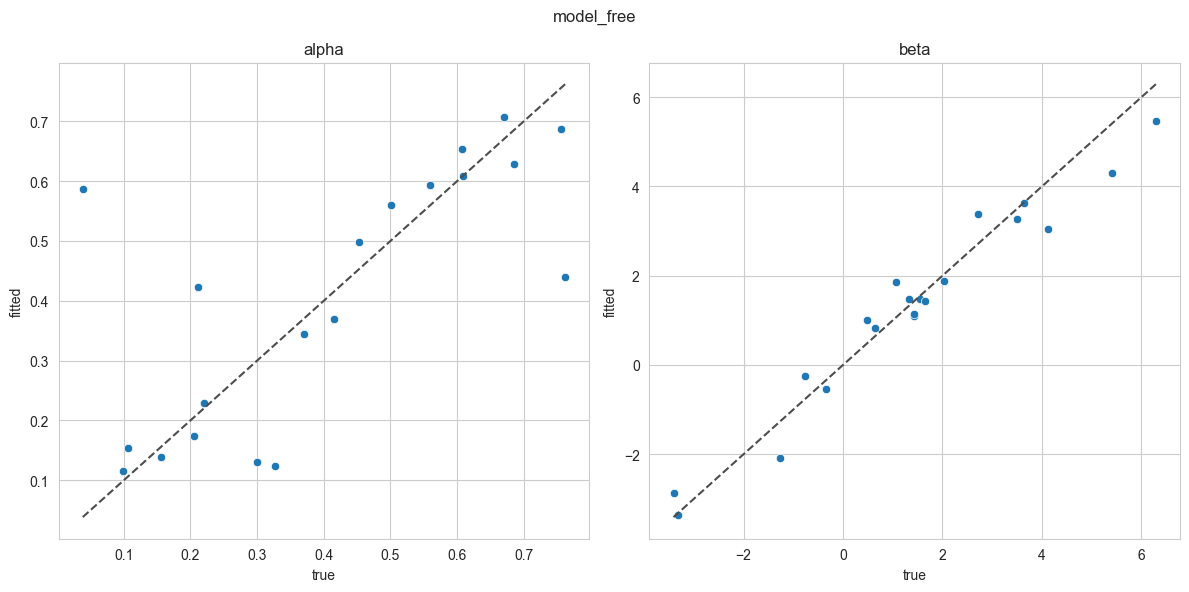

Pearson correlation for alpha: 0.870, p_value: 6.296875950889555e-07
Pearson correlation for beta: 0.981, p_value: 2.4633567302812333e-14


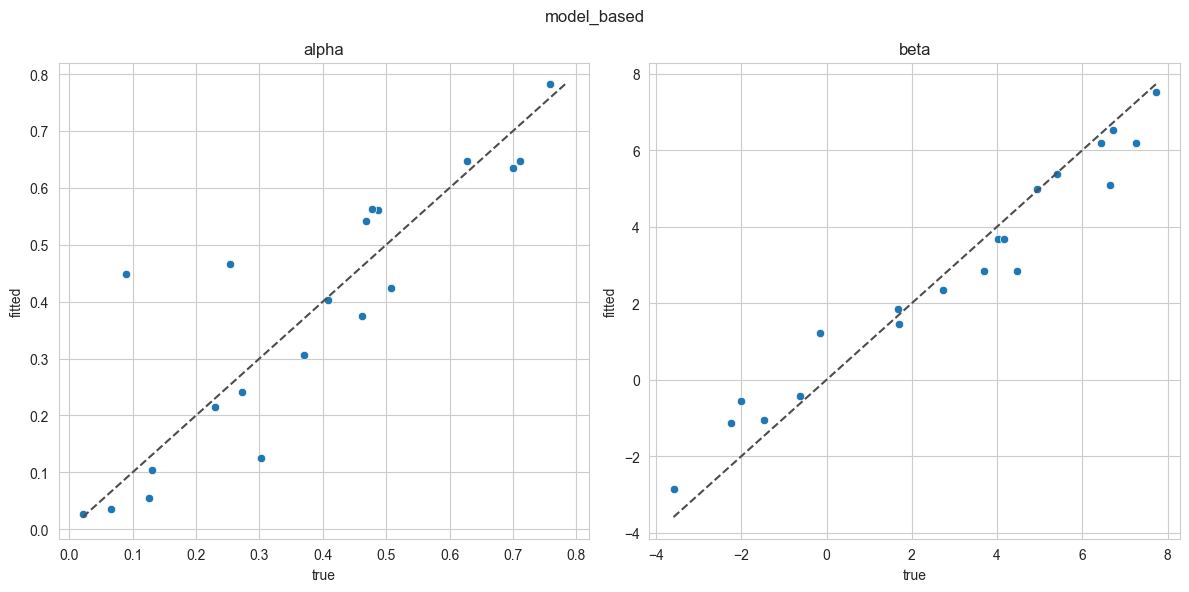

Pearson correlation for alpha_1: 0.269, p_value: 0.2510473609408212
Pearson correlation for alpha_2: 0.437, p_value: 0.053976853781364784
Pearson correlation for beta_1: 0.686, p_value: 0.0008464220171341394
Pearson correlation for beta_2: 0.872, p_value: 5.567223467819686e-07
Pearson correlation for _lambda: -0.189, p_value: 0.42510512954261137
Pearson correlation for w: -0.200, p_value: 0.39806263290056443
Pearson correlation for p: 0.631, p_value: 0.002845251742788754


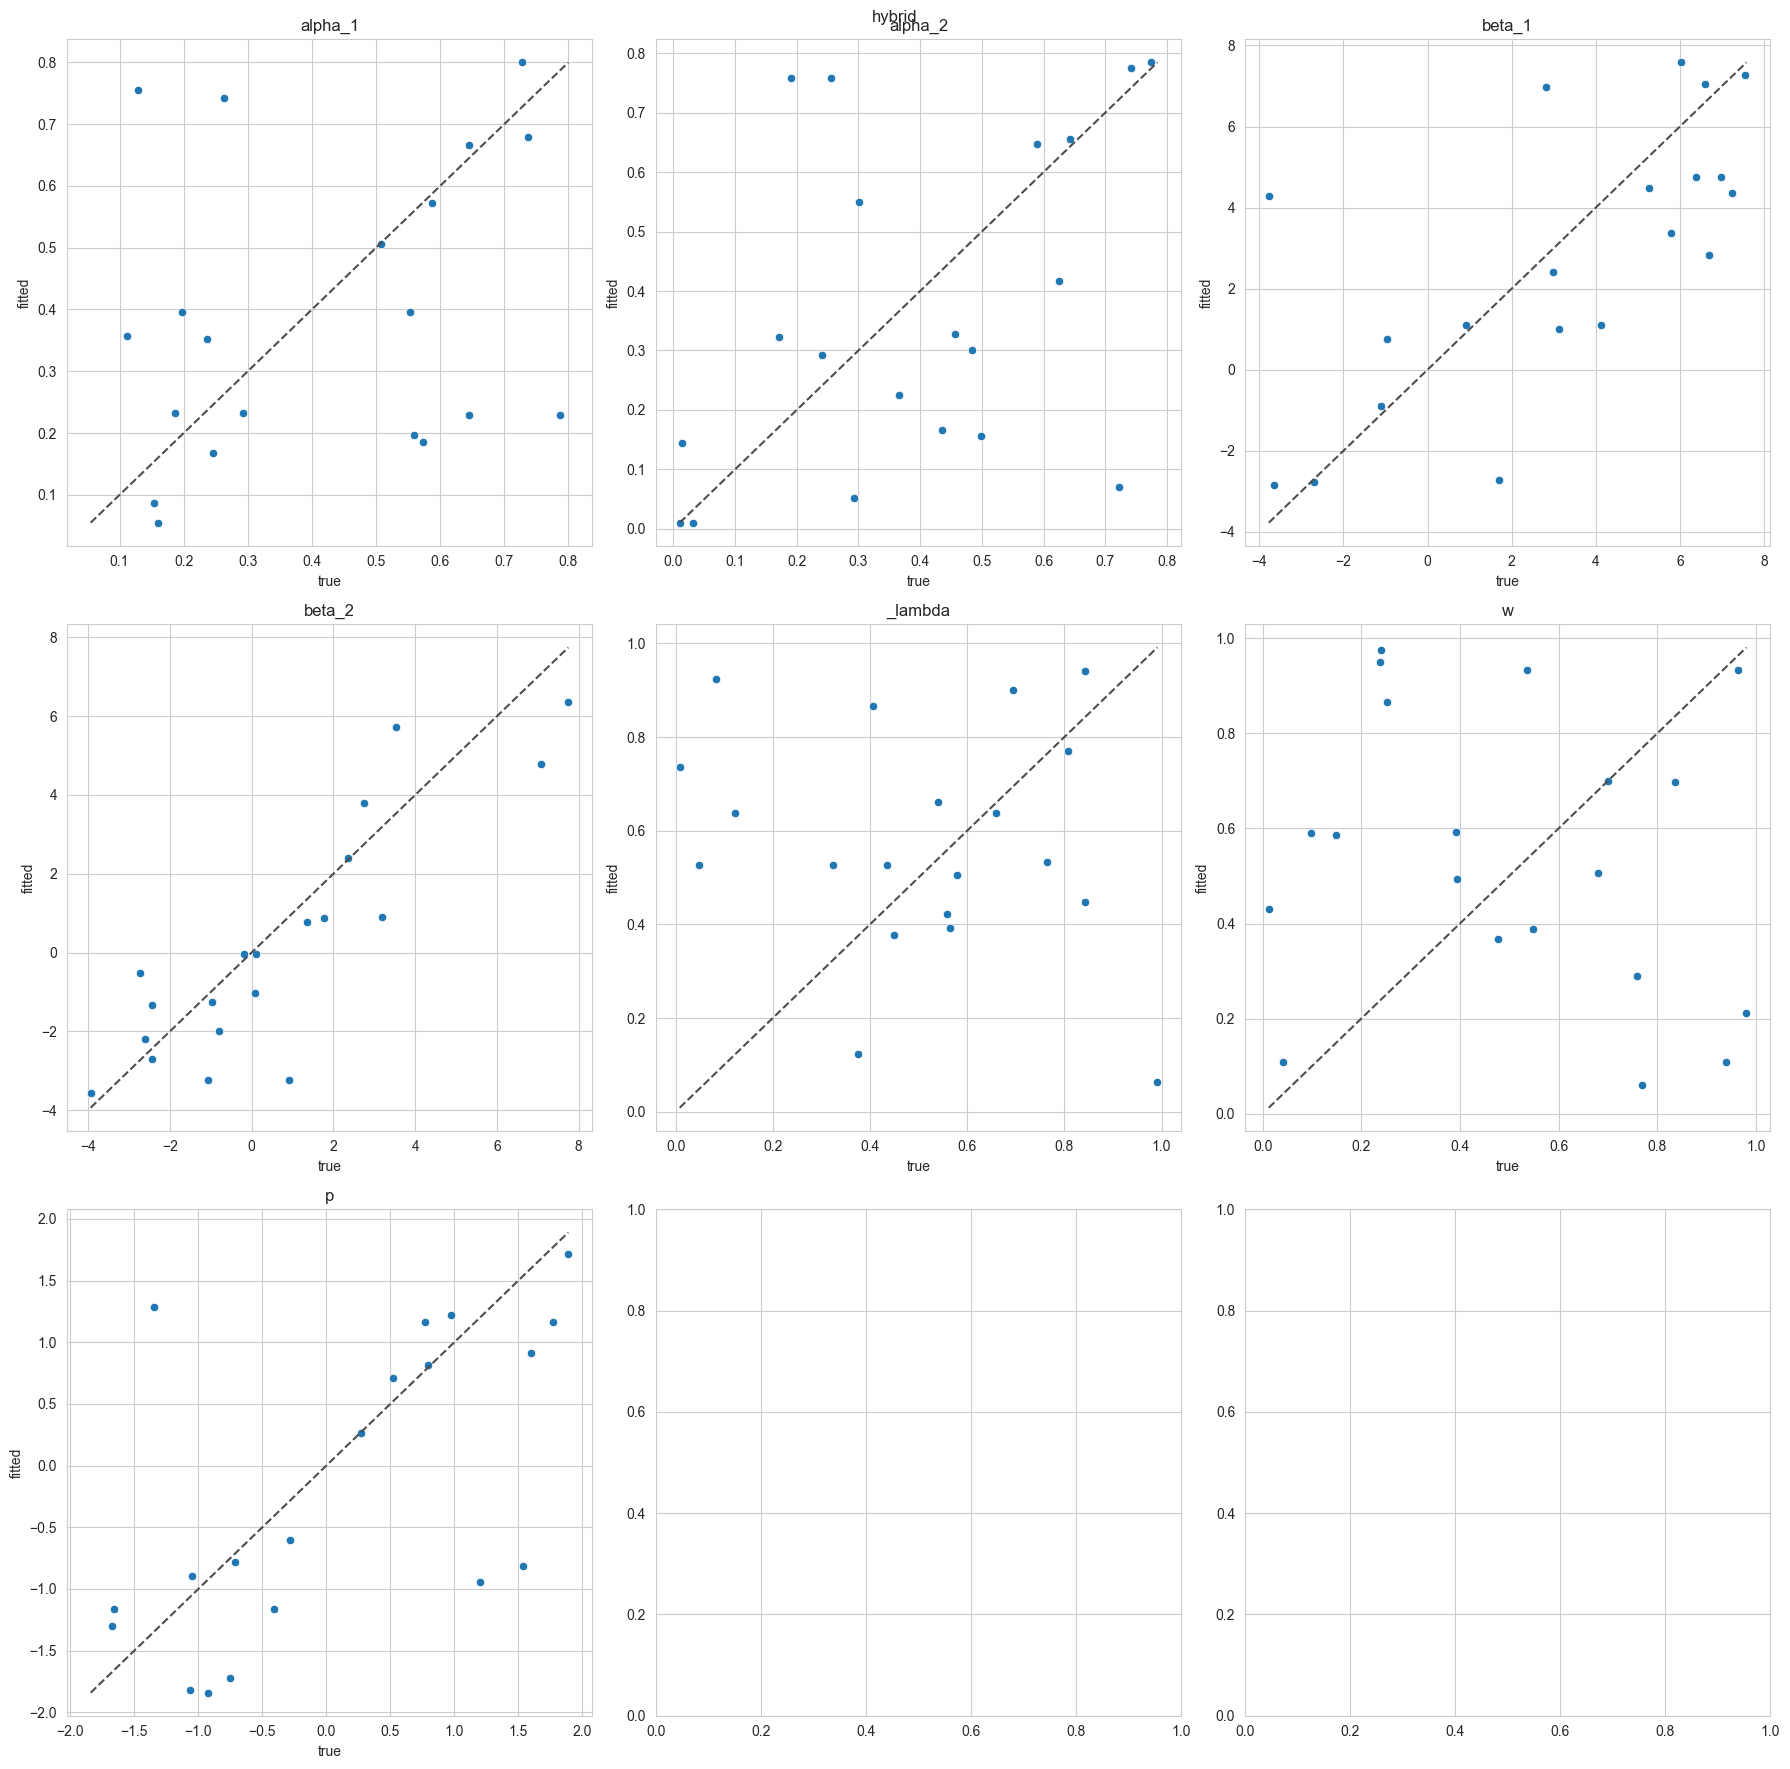

Pearson correlation for alpha_1: -0.087, p_value: 0.7168422890225484
Pearson correlation for alpha_2: 0.516, p_value: 0.019736338096420482
Pearson correlation for beta_1: 0.686, p_value: 0.0008493568758195428
Pearson correlation for beta_2: 0.927, p_value: 4.4012835965548765e-09
Pearson correlation for _lambda: 0.143, p_value: 0.5462464174480409
Pearson correlation for w: nan, p_value: nan
Pearson correlation for p: 0.485, p_value: 0.030057897131888764


/Users/imtezcan/Repositories/CogSci/EBIMAS/venv-ebimas/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


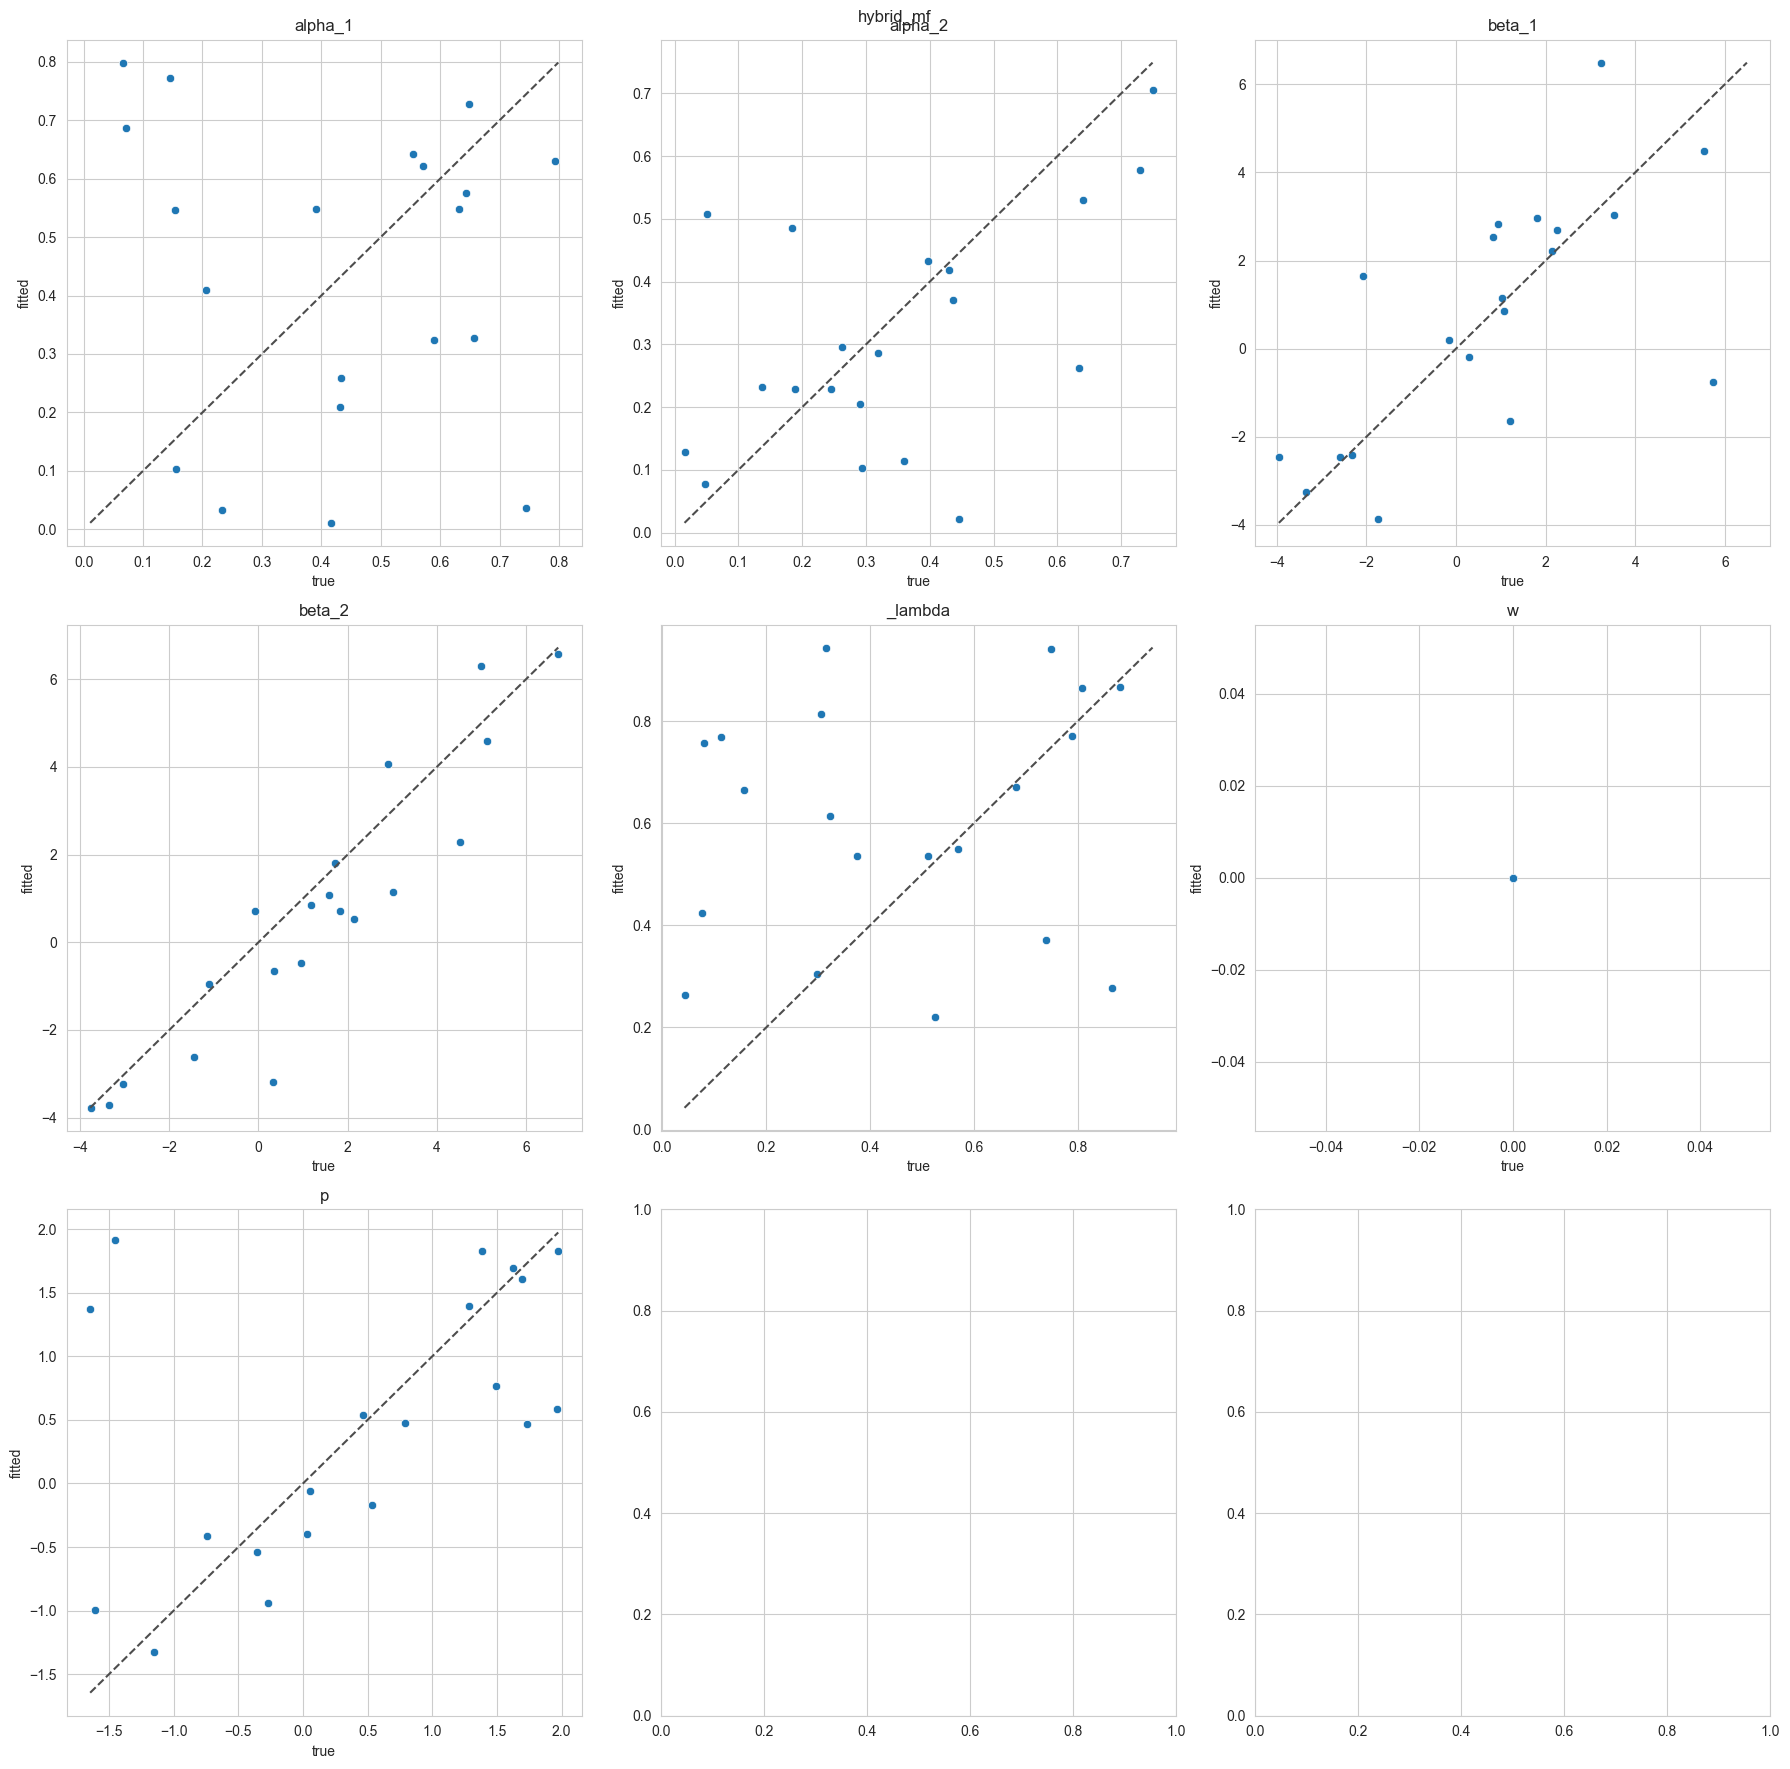

/Users/imtezcan/Repositories/CogSci/EBIMAS/venv-ebimas/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/imtezcan/Repositories/CogSci/EBIMAS/venv-ebimas/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/imtezcan/Repositories/CogSci/EBIMAS/venv-ebimas/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Pearson correlation for alpha_1: nan, p_value: nan
Pearson correlation for alpha_2: 0.683, p_value: 0.0009103714146822705
Pearson correlation for beta_1: 0.754, p_value: 0.00012353466905991548
Pearson correlation for beta_2: 0.961, p_value: 1.8591052854523976e-11
Pearson correlation for _lambda: nan, p_value: nan
Pearson correlation for w: nan, p_value: nan
Pearson correlation for p: 0.556, p_value: 0.010881695425066996


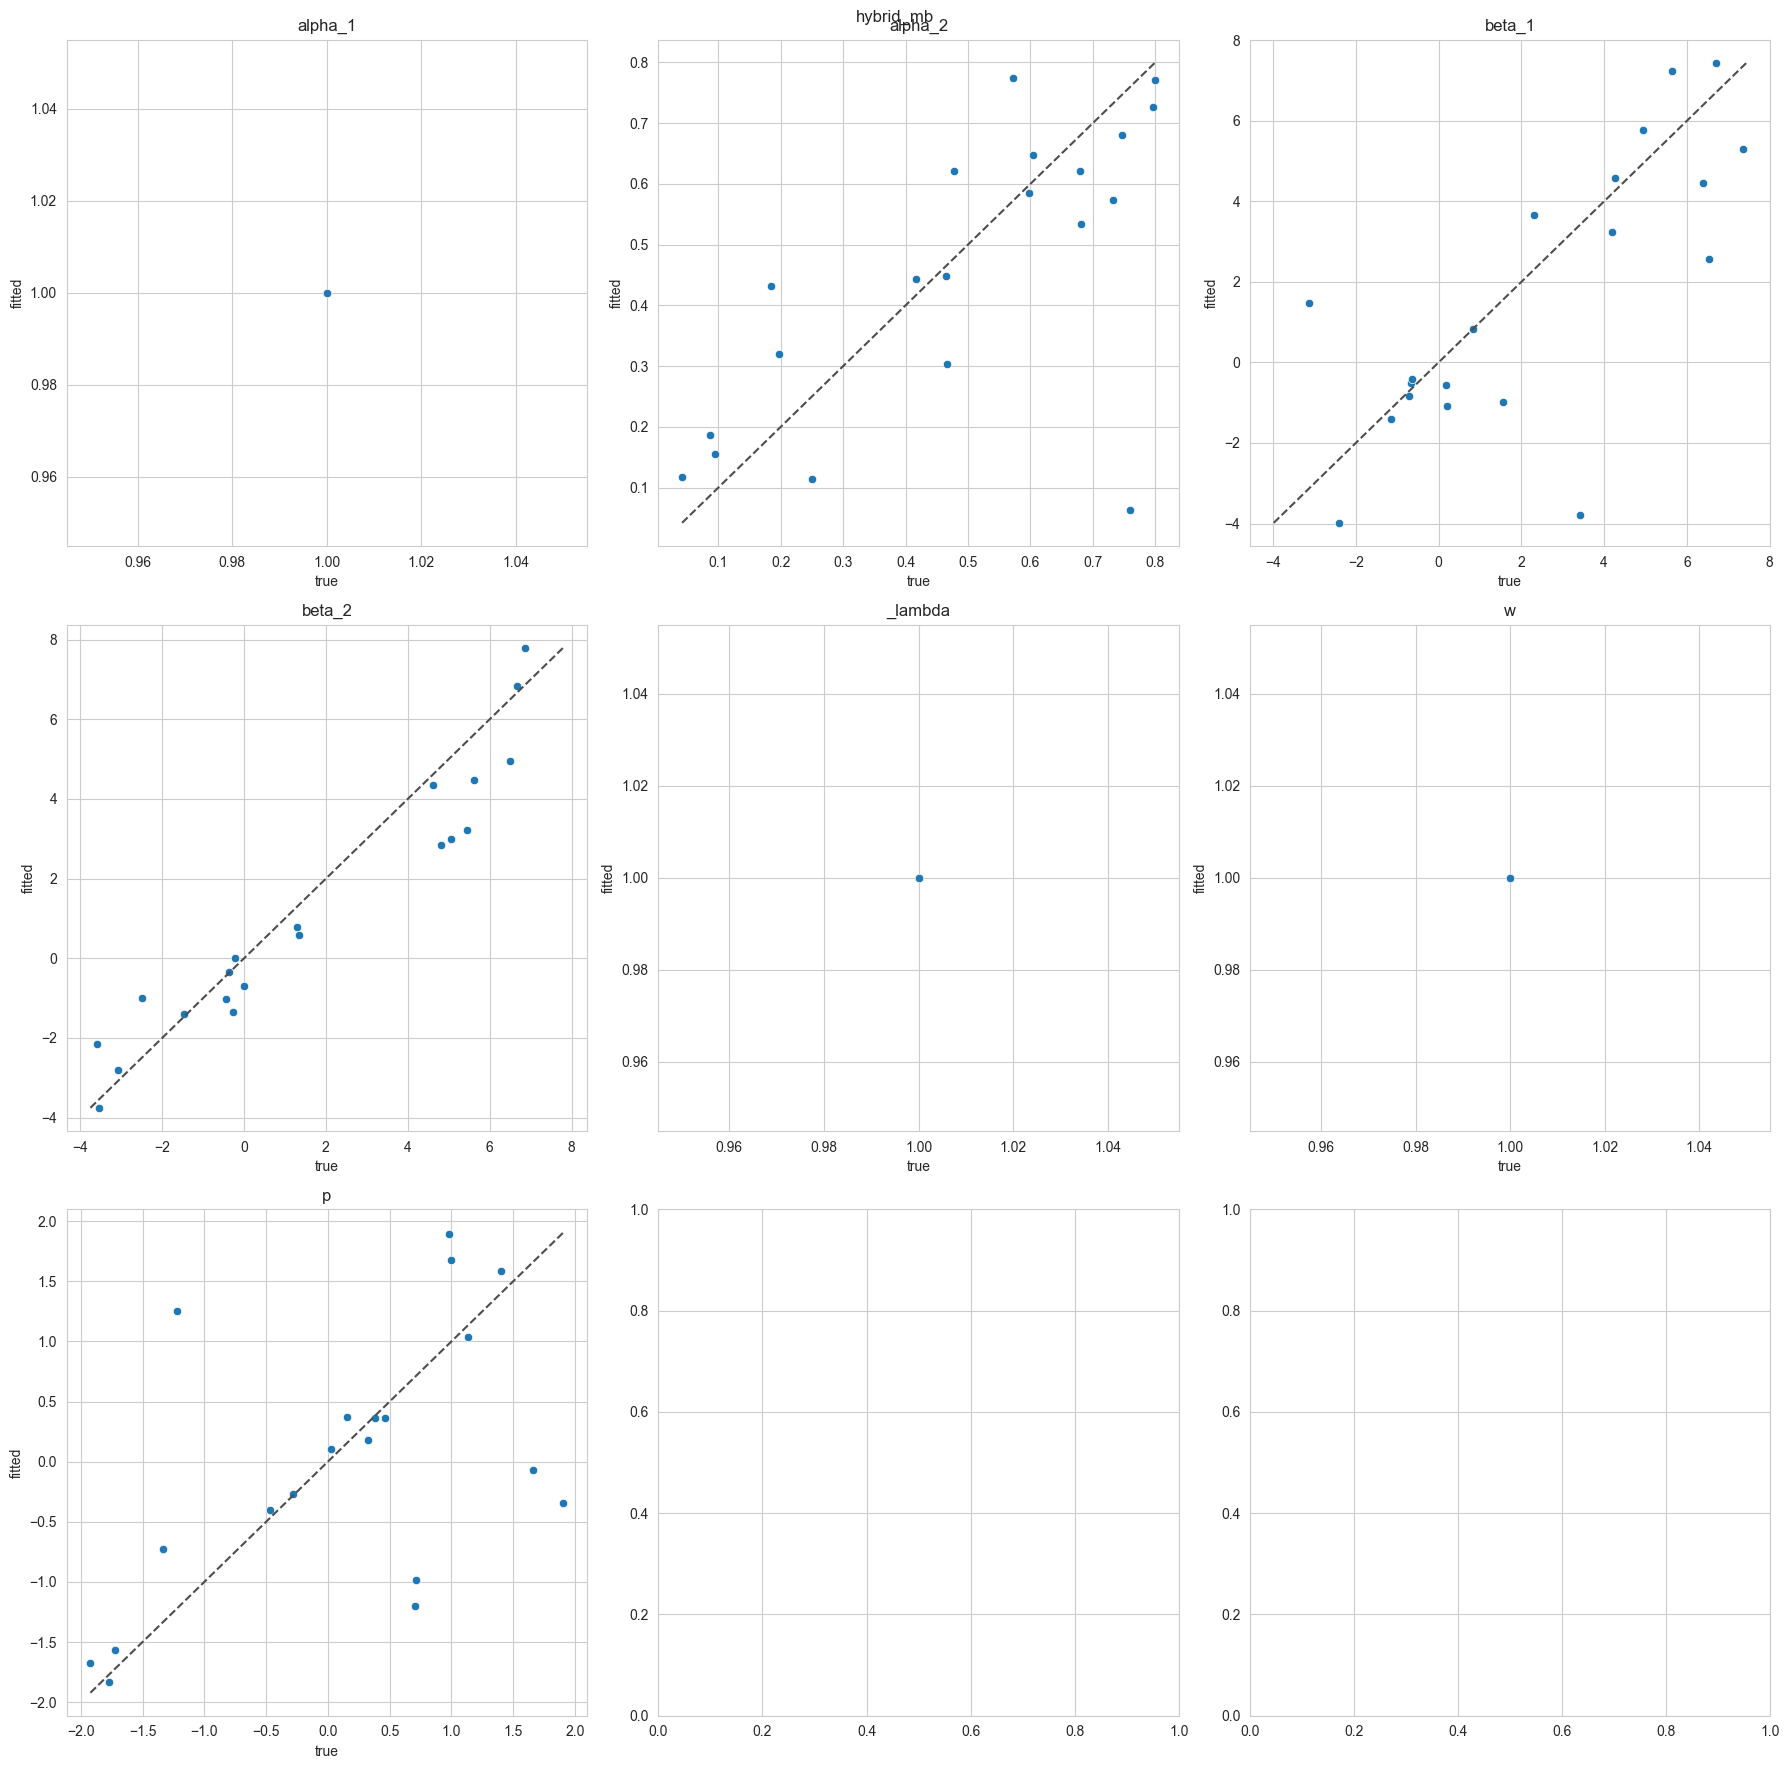

In [206]:
# plot the results
plot_param_recovery(true_params_mf, fitted_params_mf, 'model_free')
plot_param_recovery(true_params_mb, fitted_params_mb, 'model_based')
plot_param_recovery(true_params_hybrid, fitted_params_hybrid, 'hybrid')
plot_param_recovery(true_params_hybrid_mf, fitted_params_hybrid_mf, 'hybrid_mf')
plot_param_recovery(true_params_hybrid_mb, fitted_params_hybrid_mb, 'hybrid_mb')

corr_1: PearsonRResult(statistic=-0.07895961736908402, pvalue=0.740721373277467)


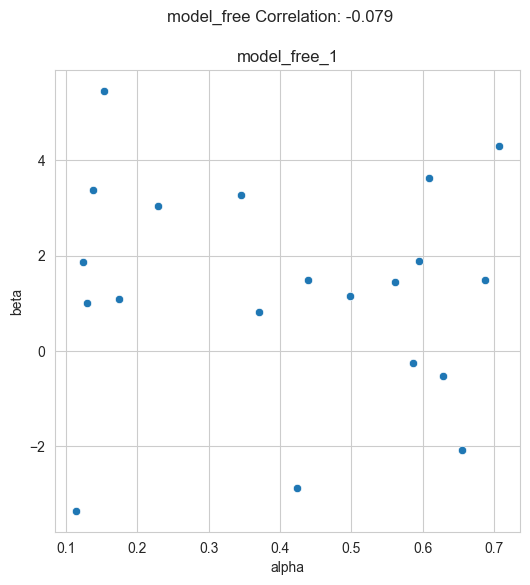

corr_1: PearsonRResult(statistic=-0.3052350363413713, pvalue=0.19065231800190133)


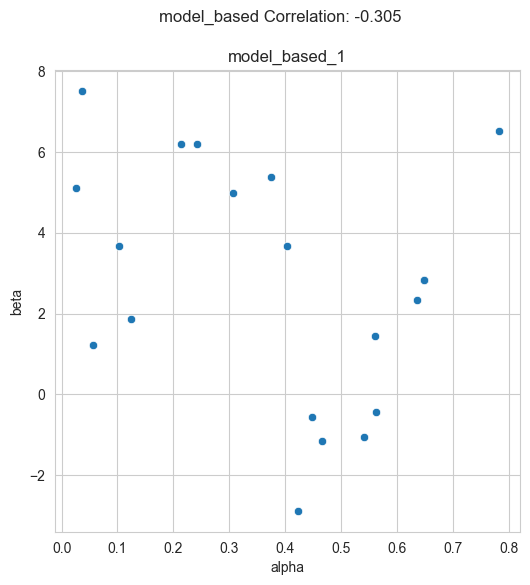

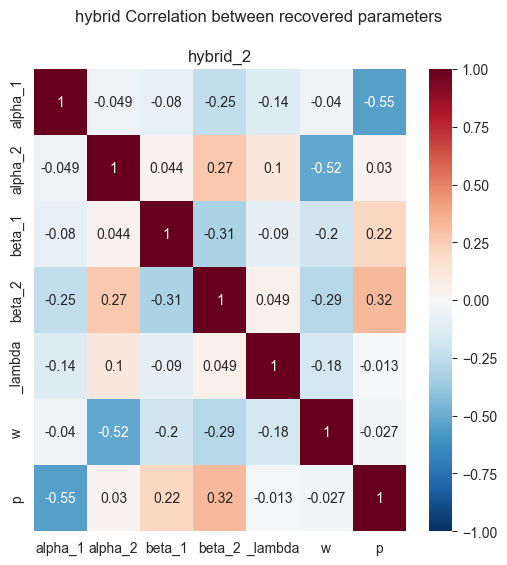

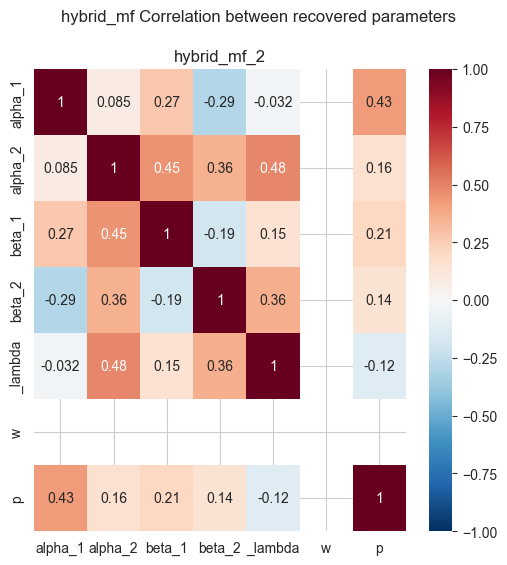

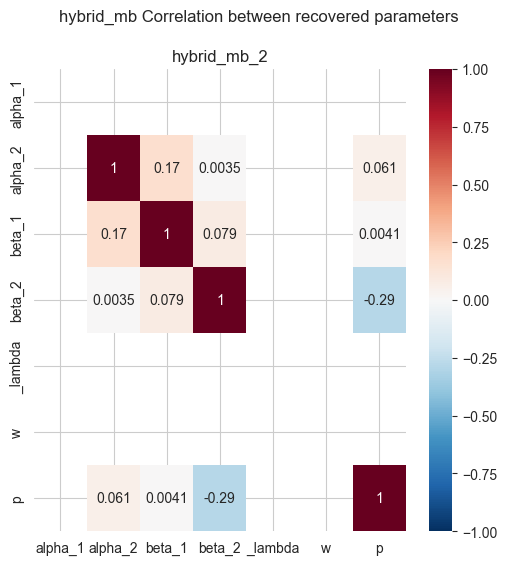

In [207]:
# plot recovered parameters correlation
# low is good
plot_param_correlation(fitted_params_mf, 'model_free')
plot_param_correlation(fitted_params_mb, 'model_based')
plot_param_correlation(fitted_params_hybrid, 'hybrid')
plot_param_correlation(fitted_params_hybrid_mf, 'hybrid_mf')
plot_param_correlation(fitted_params_hybrid_mb, 'hybrid_mb')

## *Optional*: Model Recovery *(2 bonus points)*

In this bonus exercise, you may examine model reovery. The bonus points count towards your total group project points. That is, you may accumlate up to 22 points in the practical part of the group project.

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [218]:
def calculate_bic(num_params, num_data_points, ll):
    """
    Calculates Bayesian Information Criterion to be used in model comparison
    :param num_params: Number of free parameters that the model has
    :param num_data_points: Number of data points the model has been fitted to
    :param ll: Maximum log likelihood estimation for the model given data
    :return:
    """
    return num_params * np.log(num_data_points) - 2 * ll

In [219]:
plot_cmap = 'viridis'

In [208]:
NUM_RUNS = 10
SEED = 0
# NUM_ITERATIONS = 256  # Number of iterations for random search
NUM_INITILIZATIONS = 1 # Number of random initializations for minimize search
CONSIDER_BOTH_STAGES = True
kwargs_for_fitting_functions = {'num_initializations': NUM_INITILIZATIONS,
                                'consider_both_stages': CONSIDER_BOTH_STAGES}

INTERPOLATION_STEPS = 21 # Number of steps for interpolation of the parameter space
# define the parameter space for the simple model free and based
ALPHA_RANGE = (0.05, 0.85)
BETA_RANGE = (-4, 8)
# Define parameter distributions for hybrid model and its tow special cases (model free and model based)
ALPHA_1_RANGE = (0.05, 0.85)
ALPHA_2_RANGE = (0.05, 0.85)
BETA_1_RANGE = (-4, 8)
BETA_2_RANGE = (-4, 8)
LAMBDA_RANGE = (0.1, 0.9) # we avoid 0 and 1 since we are not aiming at hypothesising about the tww td lambda extremes
W_RANGE = (0.1, 0.9) # this should force the hybrid model to not settle on one of it's sub models 
                            # for the sub models we later fix the the w to either 0 or 1
P_RANGE = (-0.5, 0.5) # we don't want to encourage neither exesive perversion nor it's opposite

# uniform (loc, scale) => uniform (loc, loc + scale)
param_distributions_simple = {'alpha': uniform(ALPHA_RANGE[0], ALPHA_RANGE[1] - ALPHA_RANGE[0]),
                        'beta': uniform(BETA_RANGE[0], BETA_RANGE[1] - BETA_RANGE[0])}

param_distributions_hybrid = {
    'alpha_1': uniform(ALPHA_1_RANGE[0], ALPHA_1_RANGE[1] - ALPHA_1_RANGE[0]),
    'alpha_2': uniform(ALPHA_2_RANGE[0], ALPHA_2_RANGE[1] - ALPHA_2_RANGE[0]),
    'beta_1': uniform(BETA_1_RANGE[0], BETA_1_RANGE[1] - BETA_1_RANGE[0]),
    'beta_2': uniform(BETA_2_RANGE[0], BETA_2_RANGE[1] - BETA_2_RANGE[0]),
    '_lambda': uniform(LAMBDA_RANGE[0], LAMBDA_RANGE[1] - LAMBDA_RANGE[0]),
    'w': uniform(W_RANGE[0], W_RANGE[1] - W_RANGE[0]),
    'p': uniform(P_RANGE[0], P_RANGE[1] - P_RANGE[0]),
}
param_distributions_hybrid_mf = param_distributions_hybrid.copy()
param_distributions_hybrid_mf['w'] = uniform(0, 0)
param_distributions_hybrid_mb = param_distributions_hybrid.copy()
param_distributions_hybrid_mb['w'] = uniform(1, 0)
param_distributions_hybrid_mb['alpha_1'] = uniform(1, 0) # arbitrary value in case of pure model based
param_distributions_hybrid_mb['_lambda'] = uniform(1, 0) # arbitrary value in case of pure model based

In [209]:
models_priors = {
                'model_free': param_distributions_simple,
                 'model_based': param_distributions_simple,
                 'hybrid': param_distributions_hybrid,
                 'hybrid_mf': param_distributions_hybrid_mf,
                 'hybrid_mb': param_distributions_hybrid_mb
                }

#### Model recovery code

In [214]:
from sklearn.metrics import confusion_matrix

def model_recovery(models_priors:dict, num_simulations=10, seed=None, show_progress=True):
    # set random seed for reproducibility
    np.random.seed(seed)
    # initialize lists to store the true and predicted model labels
    true_model_labels = []
    predicted_model_labels = []
    models = list(models_priors.keys())
    # get the parameter range for each model
    all_params_range = {model: get_param_range(param_dists) for model, param_dists in models_priors.items()}
    all_free_params = {model: get_free_params_names(param_range) for model, param_range in all_params_range.items()}
    # get the number of free parameters for each model
    num_free_params = {model: len(free_params) for model, free_params in all_free_params.items()}
    models_progress = tqdm(models, desc='models:', total=len(models), disable=not show_progress, leave=True, position=0)
    models_progress.refresh()
    for true_model in models_progress:
        simulation_progress = tqdm(range(num_simulations), desc=f'simulating model recovery for: {true_model}', total=num_simulations, disable=not show_progress, leave=True, position=1)
        simulation_progress.refresh()
        for _ in simulation_progress:
            # Sample parameters from the true model's priors
            try:
                sampling_space = list(models_priors[true_model].items())
                params = {param: dist.rvs() for param, dist in sampling_space}
                # params = {param: dist.rvs() for param, dist in models_priors[true_model].items()}
            except AttributeError:
                params = {param: np.random.uniform(np.min(dist), np.max(dist)) for param, dist in models_priors[true_model].items()}
            # simulated_data, _ = simulate(agent_type=true_model, params=params, seed=seed)
            simulated_data, _ = simulate(agent_type=true_model, params=params)
            best_BIC = np.inf
            best_fit_model = None
            for model in models:
                # fit the model and compute the BIC
                params_range = all_params_range[model]
                fitted_params, best_LL, sampled_results_df = fit_with_random_search(params_range, simulated_data, agent_type=model)
                num_params = num_free_params[model]
                num_data_points = len(simulated_data)
                BIC = calculate_bic(num_params, num_data_points, best_LL)
                if BIC < best_BIC:
                    best_BIC = BIC
                    best_fit_model = model
            
            true_model_labels.append(true_model)
            predicted_model_labels.append(best_fit_model)

            # refresh the simulation progress bar
            simulation_progress.refresh()

        # refresh the models progress bar
        models_progress.refresh()

    # compute confusion matrix
    conf_matrix = confusion_matrix(true_model_labels, predicted_model_labels, labels=models)
    conf_matrix_sum = conf_matrix.sum(axis=1).reshape(-1, 1)  # ensure it's a column vector
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix_sum

    # inversion matrix:
    # P(true_model | best_fit_model) = P(best_fit_model | true_model) * P(true_model) / P(best_fit_model)
    # under the assumption uniform prior over models: P(true_model) = 1 / num_models
    # the inversion matrix simplifies to:
    # P(true_model | best_fit_model) ∝ P(best_fit_model | true_model)
    # -> normalize each column of the confusion matrix results in the inversion matrix
    inversion_matrix = conf_matrix_normalized / conf_matrix_normalized.sum(axis=0)

    conf_matrix_normalized_df = pd.DataFrame(conf_matrix_normalized, index=models, columns=models)
    inversion_matrix_df = pd.DataFrame(inversion_matrix, index=models, columns=models)
    
    # unset the random seed
    np.random.seed(None)
    return conf_matrix_normalized_df, inversion_matrix_df

def get_free_params_names(param_range:dict):
    # exclude the fixed parameters -> min range == max range
    return {param for param, range in param_range.items() if range[0] != range[1]}

def get_param_range(param_dists: dict):
    param_ranges = {}
    for param, dist in param_dists.items():
        try:
            if dist.args[1] == 0:  # If 'scale' is 0 -> parameter is fixed
                param_ranges[param] = (dist.args[0], dist.args[0])
            else:
                # param_ranges[param] = (dist.ppf(0), dist.ppf(1))
                param_ranges[param] = (dist.args[0], dist.args[0] + dist.args[1])
        except (AttributeError, NotImplementedError):
            # Handle cases where dist is not a scipy.stats distribution or does not support PPF
            try:
                param_ranges[param] = (np.min(dist), np.max(dist))
            except (TypeError, ValueError) as e:
                # Fallback for unrecognized distribution types
                raise e("Unrecognized distribution type for parameter: {}".format(param))
    return param_ranges

#### Run model recovery

In [215]:
conf_matrix_df, inversion_matrix_df = model_recovery(models_priors, num_simulations=NUM_RUNS, seed=SEED)

models:: 100%|██████████| 5/5 [07:43<00:00, 92.74s/it]


#### Plotting Model Recovery

In [220]:
def plot_confusion_matrix(conf_matrix:pd.DataFrame, inversion_matrix:pd.DataFrame, title:str, save=False, filename:str='plots/model_recovery.png', cmap='plasma'):
    # cmap = 'Blues'
    # cmap = 'viridis'
    # cmap = 'magma'
    # cmap = 'plasma'
    # cmap = 'cividis'

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    fig.suptitle(title)
    sns.heatmap(conf_matrix, annot=True, cmap=cmap, cbar=False, ax=ax1)
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Predicted Model')
    ax1.set_ylabel('True Model')
    sns.heatmap(inversion_matrix, annot=True, cmap=cmap, cbar=False, ax=ax2)
    ax2.set_title('Inversion Matrix')
    ax2.set_xlabel('Predicted Model')
    ax2.set_ylabel('True Model')
    fig.suptitle(title)

    fig.tight_layout()
    plt.show()
    if save:
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        # add timestamp to filename
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = filename.replace('.png', f'_{timestamp}.png')
        fig.savefig(filename)
        print(f'Plot saved to {filename}')

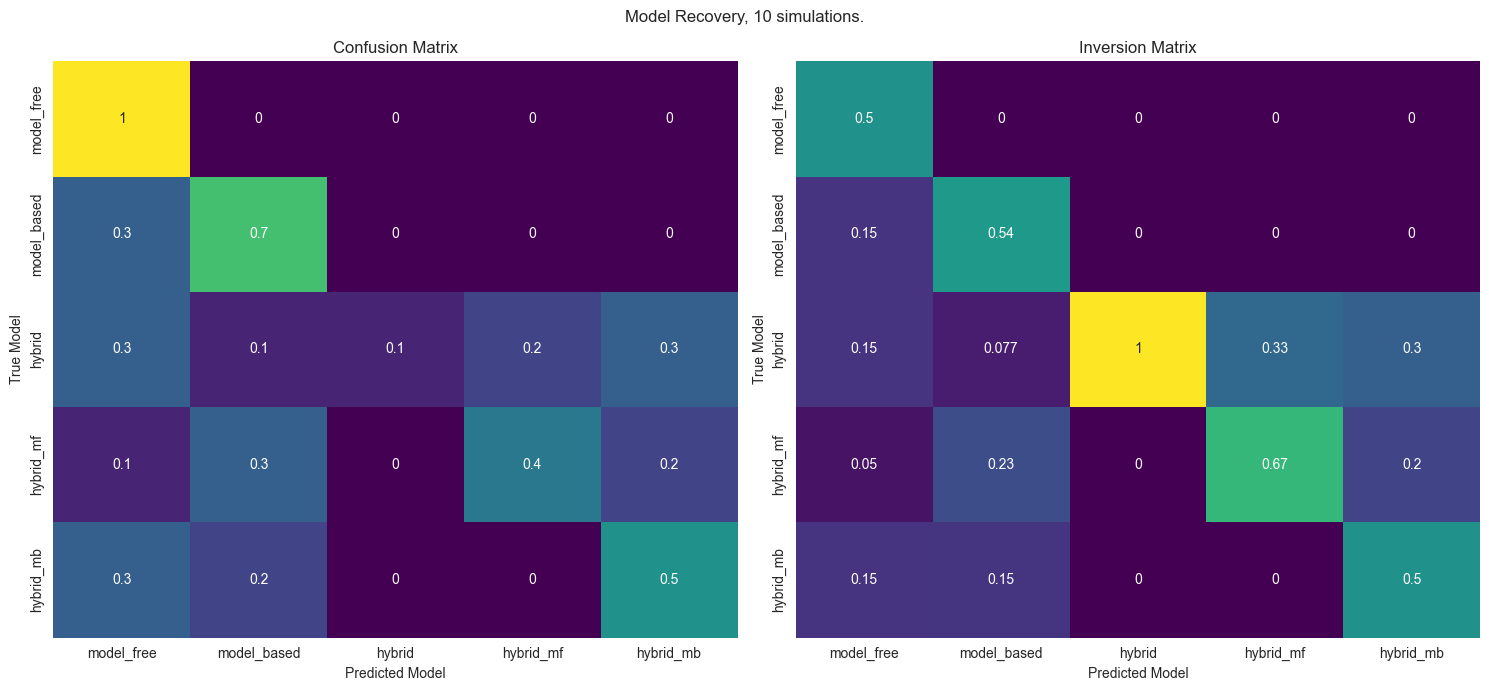

In [221]:
plot_confusion_matrix(conf_matrix_df, inversion_matrix_df,
                      title=f'Model Recovery, {NUM_RUNS} simulations.',
                      cmap=plot_cmap)

In [222]:
models_priors_hybirds = {
                 'hybrid': param_distributions_hybrid,
                 'hybrid_mf': param_distributions_hybrid_mf,
                 'hybrid_mb': param_distributions_hybrid_mb
                }

In [223]:
conf_matrix_df_hybirds, inversion_matrix_df_hybirds = model_recovery(models_priors_hybirds, num_simulations=NUM_RUNS, seed=SEED)

models:: 100%|██████████| 3/3 [03:48<00:00, 76.22s/it]


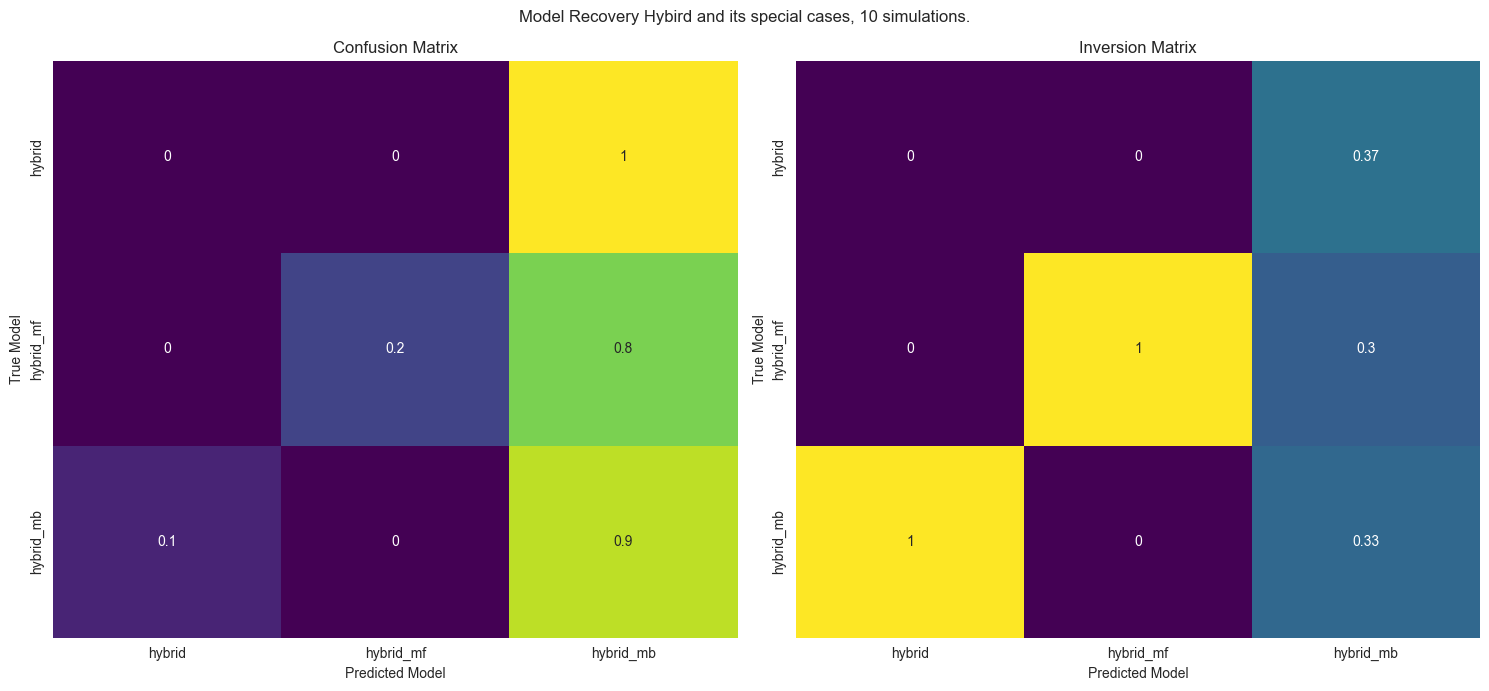

In [224]:
plot_confusion_matrix(conf_matrix_df_hybirds, inversion_matrix_df_hybirds,
                      title=f'Model Recovery Hybird and its special cases, {NUM_RUNS} simulations.',
                      cmap=plot_cmap)

In [225]:
models_priors_simple_vs_hybrid = {
                 'model_free': param_distributions_simple,
                 'model_based': param_distributions_simple,
                 'hybrid': param_distributions_hybrid
                }

In [226]:
conf_matrix_df_simple_vs_hybirds, inversion_matrix_df_simple_vs_hybirds = model_recovery(models_priors_simple_vs_hybrid, num_simulations=NUM_RUNS, seed=SEED)

models:: 100%|██████████| 3/3 [02:17<00:00, 45.80s/it]


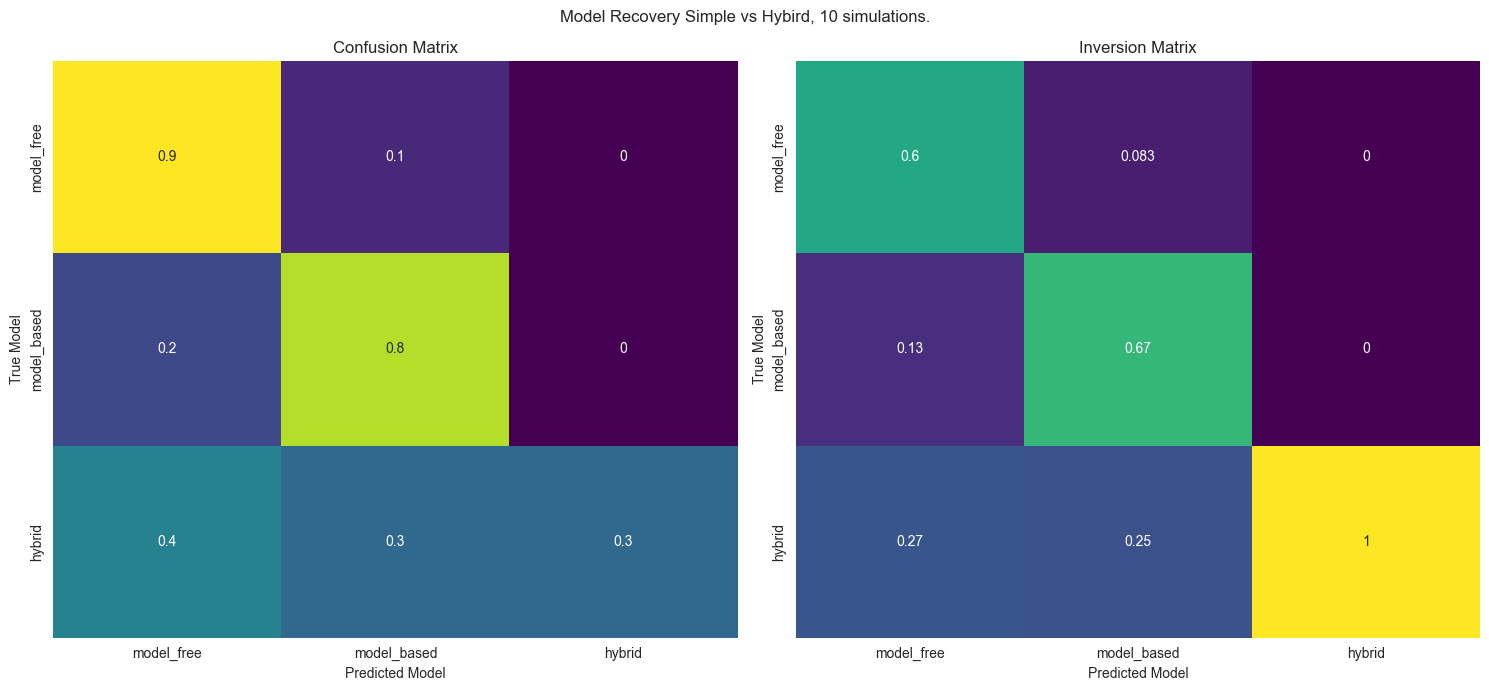

In [227]:
plot_confusion_matrix(conf_matrix_df_simple_vs_hybirds, inversion_matrix_df_simple_vs_hybirds,
                      title=f'Model Recovery Simple vs Hybird, {NUM_RUNS} simulations.',
                      cmap=plot_cmap)

## Model Comparison *(5 points)*

For this exercise you should:

*   Load and (potentially) preprocess the experimental data. (1 point)

*   Fit the two models to the data.  *(1 point)*

*   Evaluate which model performs better, taking into account fit and model complexity. *(2 points)*

*   Plot the behavior of the winning model against the data. *(1 point)**

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





We have loaded and preprocessed the experimental data above, so we don't do it again here.
And we already have the fitted models and their log likelihoods, so we don't fit the models again here.
We evaluate the models using the Bayesian Information Criterion (BIC) which takes into account the fit and model complexity.
We then plot the behavior of the winning model against the data.

In [228]:
def calculate_bic(num_params, num_data_points, ll):
    """
    Calculates Bayesian Information Criterion to be used in model comparison
    :param num_params: Number of free parameters that the model has
    :param num_data_points: Number of data points the model has been fitted to
    :param ll: Maximum log likelihood estimation for the model given data
    :return:
    """
    return num_params * np.log(num_data_points) - 2 * ll

In [229]:
# we are using the loaded data and fitted models from the previous cells
num_datapoints = len(data)

gs_bic_mf = calculate_bic(num_params=2, num_data_points=num_datapoints, ll=gs_fitted_LL_mf)
gs_bic_mb = calculate_bic(num_params=2, num_data_points=num_datapoints, ll=gs_fitted_LL_mb)

rs_bic_hybrid = calculate_bic(num_params=7, num_data_points=num_datapoints, ll=rs_fitted_LL_hybrid)
# w is fixed so we have 6 parameters for hybrid-model-free
rs_bic_hybrid_mf = calculate_bic(num_params=6, num_data_points=num_datapoints, ll=rs_fitted_LL_hybrid_mf)
# w is fixed, lambda and alpha_1 are irrelevant so we have 4 parameters for hybrid-model-based
rs_bic_hybrid_mb = calculate_bic(num_params=4, num_data_points=num_datapoints, ll=rs_fitted_LL_hybrid_mb)

mcmc_bic_hybrid = calculate_bic(num_params=7, num_data_points=num_datapoints, ll=mcmc_fitted_LL_hybrid)
mcmc_bic_hybrid_mf = calculate_bic(num_params=6, num_data_points=num_datapoints, ll=mcmc_fitted_LL_hybrid_mf)
mcmc_bic_hybrid_mb = calculate_bic(num_params=4, num_data_points=num_datapoints, ll=mcmc_fitted_LL_hybrid_mb)

results_bic = pd.DataFrame({'model': ['gs_model_free', 'gs_model_based',
                                      'rs_hybrid', 'rs_hybrid_mf', 'rs_hybrid_mb',
                                      'mcmc_hybrid', 'mcmc_hybrid_mf', 'mcmc_hybrid_mb'],
                            'bic': [gs_bic_mf, gs_bic_mb,
                                    rs_bic_hybrid, rs_bic_hybrid_mf, rs_bic_hybrid_mb,
                                    mcmc_bic_hybrid, mcmc_bic_hybrid_mf, mcmc_bic_hybrid_mb]})

display(results_bic)
model_with_lowest_bic = results_bic.loc[results_bic['bic'].idxmin(), 'model']
print(f'The model with the lowest BIC is: {model_with_lowest_bic}')

,model,bic
0,gs_model_free,556.457379
1,gs_model_based,557.258162
2,rs_hybrid,584.993389
3,rs_hybrid_mf,579.875183
4,rs_hybrid_mb,569.057379
5,mcmc_hybrid,579.976273
6,mcmc_hybrid_mf,573.130053
7,mcmc_hybrid_mb,568.470301


The model with the lowest BIC is: gs_model_free


In [230]:
model_with_lowest_bic

'gs_model_free'

In [231]:
display(best_simple_models_params)
display(best_hybrid_models_params)

,Model Type,Fitting Procedure,Best LL,alpha,beta
0,model_based,grid_search,-273.330764,0.21,1.4
1,model_free,grid_search,-272.930372,0.17,1.4


,Model Type,Fitting Procedure,Best LL,_lambda,alpha_1,alpha_2,beta_1,beta_2,p,w
0,hybrid,MCMC,-271.444026,0.289591,0.144733,0.253593,1.526889,1.231498,-0.142587,0.0
1,hybrid_mb,MCMC,-273.638516,1.000000,1.000000,0.256447,1.103757,1.145883,-0.018115,1.0
2,hybrid_mf,MCMC,-270.670074,0.812652,0.655568,0.409250,0.521672,1.090116,-0.212705,0.0


In [232]:
# simulate the best model
SEED = 0
best_model_param = best_simple_models_params.loc[0, ['alpha', 'beta']].to_dict()
data_best_fit_model, _ = simulate(agent_type='model_based', params=best_simple_models_params.loc[0, ['alpha', 'beta']].to_dict(), seed=SEED, from_data=participant_data, use_reward_distribution=True)

,common_transition,state_transition_to,stepOneChoice,reward,stepTwoChoice,rewardProbabilities,rewardDistribution,trial_index
0,True,2,1,True,1,"[0.75, 0.25, 0.75, 0.25]","[0.0, 1.0, 1.0, 1.0]",0
1,False,1,1,False,1,"[0.25, 0.25, 0.25, 0.25]","[0.0, 0.0, 0.0, 1.0]",1
2,True,2,1,True,0,"[0.75, 0.25, 0.75, 0.75]","[1.0, 0.0, 1.0, 1.0]",2
3,False,2,0,True,0,"[0.75, 0.75, 0.75, 0.25]","[1.0, 1.0, 1.0, 1.0]",3
4,True,1,0,True,1,"[0.75, 0.75, 0.25, 0.25]","[1.0, 1.0, 0.0, 0.0]",4
...,...,...,...,...,...,...,...,...
195,True,2,1,False,1,"[0.75, 0.25, 0.75, 0.25]","[1.0, 1.0, 0.0, 0.0]",195
196,True,1,0,True,1,"[0.25, 0.75, 0.25, 0.75]","[0.0, 1.0, 0.0, 1.0]",196
197,False,2,0,True,1,"[0.25, 0.75, 0.25, 0.75]","[1.0, 1.0, 0.0, 1.0]",197
198,True,2,1,True,0,"[0.25, 0.25, 0.75, 0.75]","[0.0, 0.0, 1.0, 1.0]",198


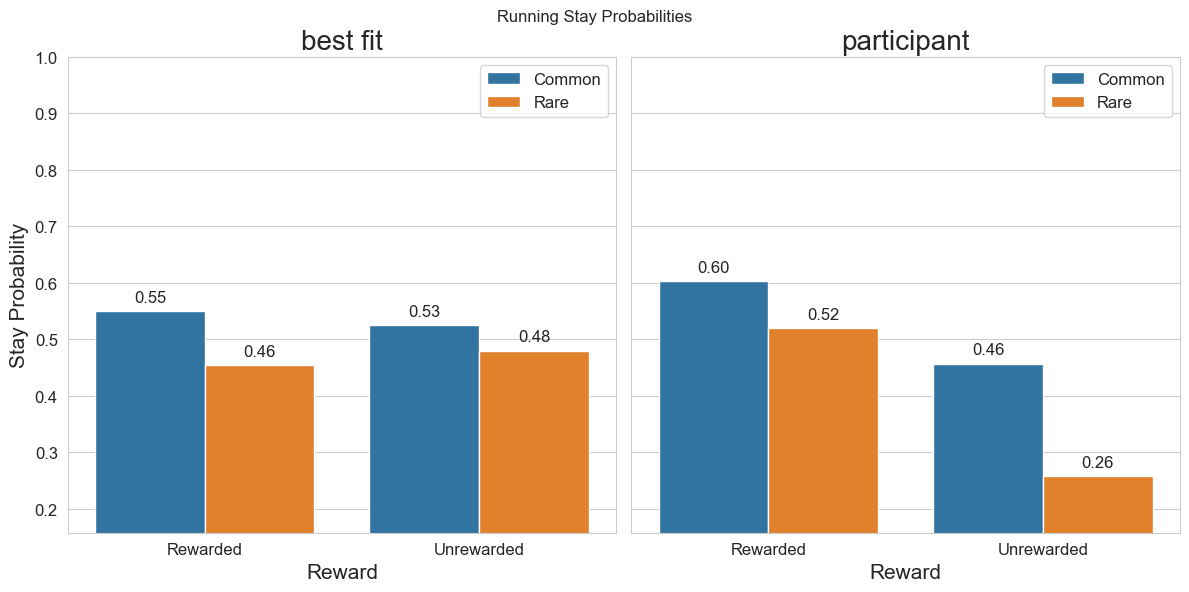

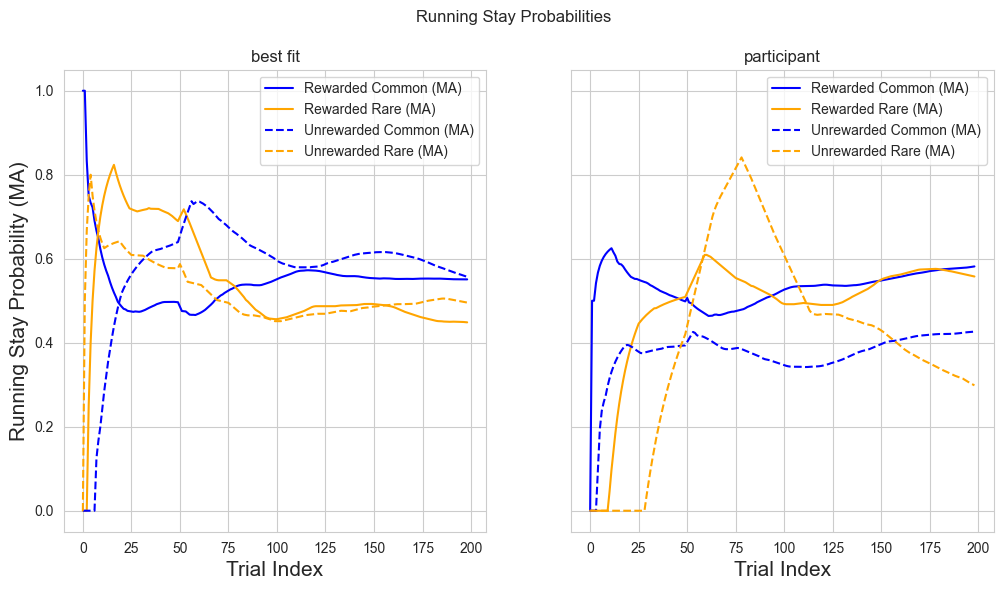

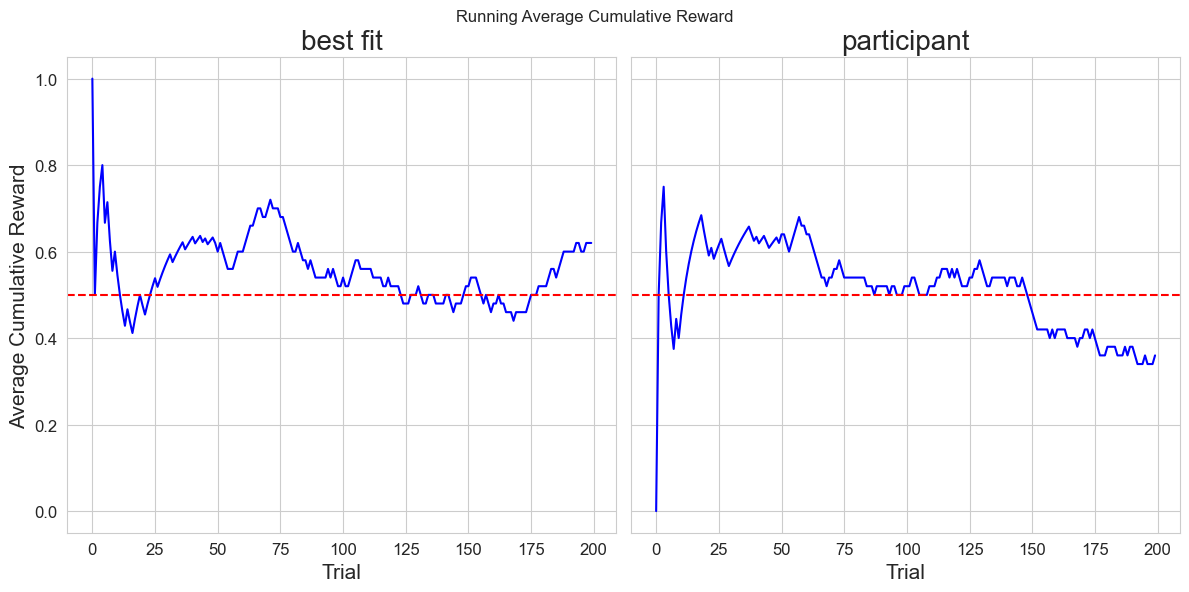

In [233]:
# plot the behavior of the best fitting model
task_dfs = {'model_free': data_best_mf, 'model_based': data_best_mb,
            'hybrid': data_best_hybrid,'hybrid_mf': data_best_hybrid_mf,
            'hybrid_mb': data_best_hybrid_mb}

display(data_best_fit_model)
# plot the stay probabilities of the best fitting model and the fitted data
calc_plot_stay_probabilities(dfs=[data_best_fit_model, data],labels=['best fit', 'participant'], title='Running Stay Probabilities',
                                    max_plots_per_row=2, return_df=False)

calc_plot_running_stay_probabilities(dfs=[data_best_fit_model, data], labels=['best fit', 'participant'], title='Running Stay Probabilities',
                                    max_plots_per_row=2, return_df=False)

# plot the running average cumulative reward of the best fitting model and the fitted data
calc_plot_running_average_cumulative_reward(dfs=[data_best_fit_model, data], labels=['best fit', 'participant'], title='Running Average Cumulative Reward',
                                    max_plots_per_row=2, return_df=False)